In [106]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import fisher_exact

import seaborn as sns
import matplotlib.pyplot as plt


In [107]:
# Load the three datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Perform a left join on 'patient_id' across the three datasets
merged_data = ab_test_data.merge(app_data, on='patient_id', how='left').merge(appointments_data, on='patient_id', how='left')

# Checking for missing values (NaNs) in all three dataframes

ab_test_na = ab_test_data.isna().sum()
app_data_na = app_data.isna().sum()
appointments_data_na = appointments_data.isna().sum()
merged_data_na = merged_data.isna().sum()
ab_test_na, app_data_na, appointments_data_na, merged_data_na


(patient_id        0
 group             0
 event_name        0
 event_datetime    0
 dtype: int64,
 patient_id        0
 traffic_source    0
 device            0
 dtype: int64,
 patient_id            0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64,
 patient_id            0
 group                 0
 event_name            0
 event_datetime        0
 traffic_source        0
 device                0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64)

In [3]:
ab_test_data

patient_id    group             event_name       event_datetime
0              1  Control   attended_appointment  2023-02-05 15:40:21
1              2     Test          reminder_sent  2023-05-07 09:19:13
2              2     Test        reminder_viewed  2023-05-08 04:25:10
3              2     Test  appointment_confirmed  2023-05-08 04:26:36
4              2     Test   attended_appointment  2023-05-09 10:34:13
...          ...      ...                    ...                  ...
5655        2673  Control   attended_appointment  2023-01-03 09:56:57
5656        2674  Control   attended_appointment  2023-07-18 10:42:54
5657        2675  Control   attended_appointment  2023-02-14 16:50:58
5658        2677  Control   attended_appointment  2023-05-21 13:26:23
5659        2678  Control   attended_appointment  2023-01-12 16:40:41

[5660 rows x 4 columns]

In [6]:
app_data

patient_id  traffic_source        device
0              1  Organic Search      IOS 17.4
1              2        Meta Ads      IOS 16.5
2              3          Direct   Android 8.3
3              4          Direct  Android 12.1
4              5          Direct      IOS 13.4
...          ...             ...           ...
2673        2674        Referral   Android 9.1
2674        2675        Meta Ads  Android 12.5
2675        2676  Organic Search  Android 10.3
2676        2677  Organic Search  Android 10.1
2677        2678        Meta Ads   Android 9.2

[2678 rows x 3 columns]

In [7]:
appointments_data

patient_id  age  gender   doctor_name   appointment_reason  \
0              1   38  Female     Dr. Smith  Screening for COVID   
1              2   53    Male     Dr. Brown           Ultrasound   
2              3   67  Female     Dr. Smith          Annual Exam   
3              4   63  Female   Dr. Johnson             Flu Shot   
4              5   77    Male     Dr. Jones    Allergy injection   
...          ...  ...     ...           ...                  ...   
2673        2674   31  Female     Dr. Smith    Allergy injection   
2674        2675   71    Male     Dr. Jones          Annual Exam   
2675        2676   75  Female      Dr.Brown  Screening for COVID   
2676        2677   74    Male  Dr. Williams           Ultrasound   
2677        2678   33  Female   Dr. Johnson             Flu Shot   

     appointment_date appointment_status  
0          2023-02-05           Attended  
1          2023-05-09           Attended  
2          2023-01-30           Attended  
3          2023-04-08       Not Attended  
4          2023-02-24       Not Attended  
...               ...                ...  
2673       2023-07-18           Attended  
2674       2023-02-14           Attended  
2675       2023-07-19       Not Attended  
2676       2023-05-21           Attended  
2677       2023-01-12           Attended  

[2678 rows x 7 columns]

In [8]:
# Inspect data
print(appointments_data.info())
print(ab_test_data.info())
print(app_data.info())

# Check for missing values
print(appointments_data.isnull().sum())
print(ab_test_data.isnull().sum())
print(app_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          2678 non-null   int64 
 1   age                 2678 non-null   int64 
 2   gender              2678 non-null   object
 3   doctor_name         2678 non-null   object
 4   appointment_reason  2678 non-null   object
 5   appointment_date    2678 non-null   object
 6   appointment_status  2678 non-null   object
dtypes: int64(2), object(5)
memory usage: 146.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   patient_id      5660 non-null   int64         
 1   group           5660 non-null   object        
 2   event_name      5660 non-null   object        
 3   event_datetime  5660 non-null   da

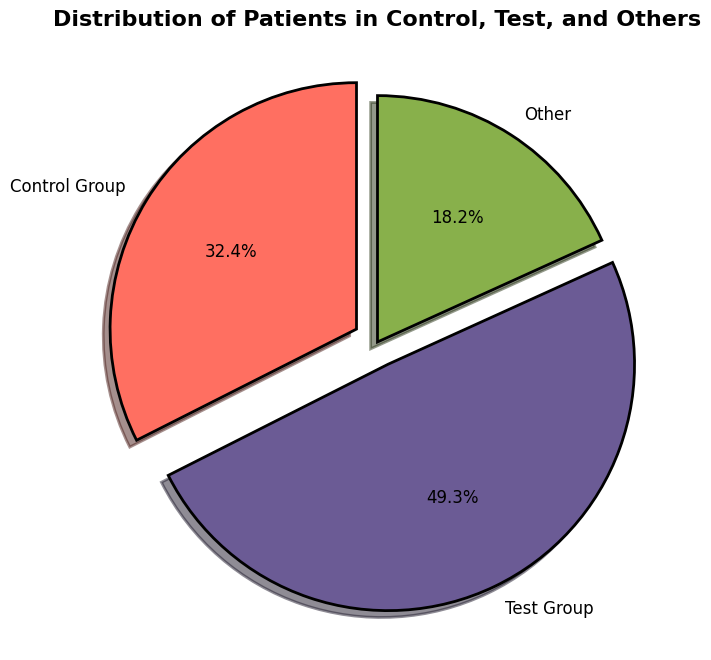

In [9]:

# Reload the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Count the number of unique patients in the appointment data
unique_patients_appointments = appointments_data['patient_id'].nunique()

# Count unique patients in the ab_test_data, separating by Control and Test groups
unique_patients_control = ab_test_data[ab_test_data['group'] == 'Control']['patient_id'].nunique()
unique_patients_test = ab_test_data[ab_test_data['group'] == 'Test']['patient_id'].nunique()

# Calculate percentages
total_patients = unique_patients_appointments
control_percentage = (unique_patients_control / total_patients) * 100
test_percentage = (unique_patients_test / total_patients) * 100
other_percentage = 100 - (control_percentage + test_percentage)

# Data for visualization
labels = ['Control Group', 'Test Group', 'Other']
sizes = [control_percentage, test_percentage, other_percentage]
attractive_colors = ['#ff6f61', '#6b5b95', '#88b04b']  

# Plotting the advanced pie chart with additional features and more attractive colors
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=attractive_colors, 
    explode=(0.1, 0.1, 0),
    shadow=True, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'linestyle': 'solid'}, 
    textprops={'color': 'black', 'fontsize': 12}  )
plt.title('Distribution of Patients in Control, Test, and Others', fontsize=16, weight='bold')
plt.show()

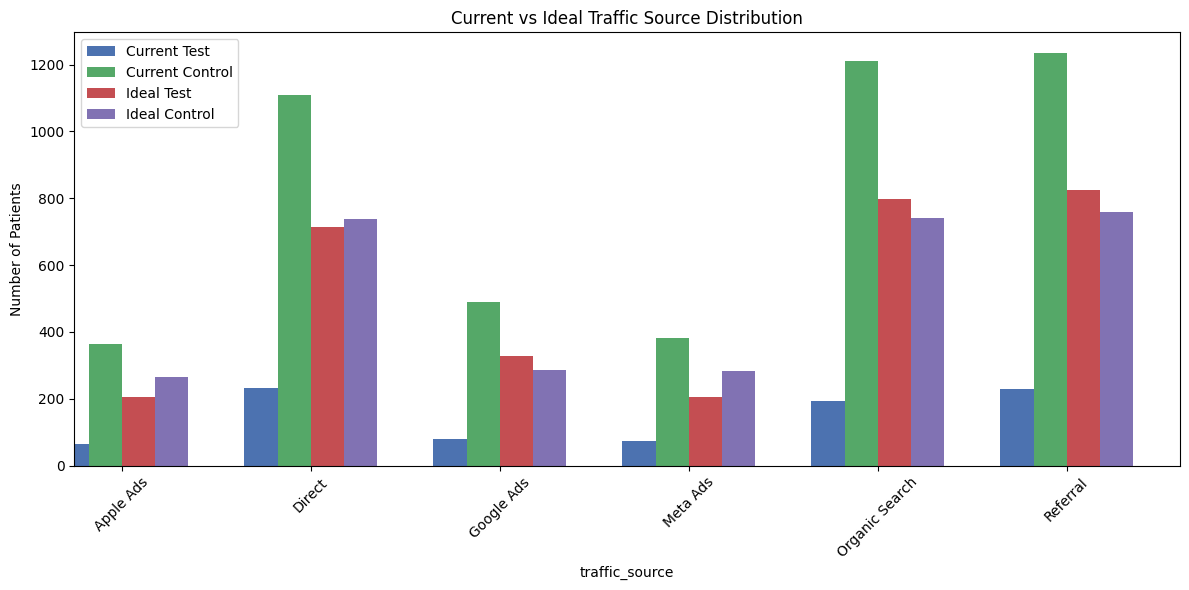

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3950803684.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  current_data = merged_data.groupby([param, 'group']).size().unstack(fill_value=0)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3950803684.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ideal_data = shuffled_data.groupby([param, 'ideal_group']).size().unstack(fill_value=0)


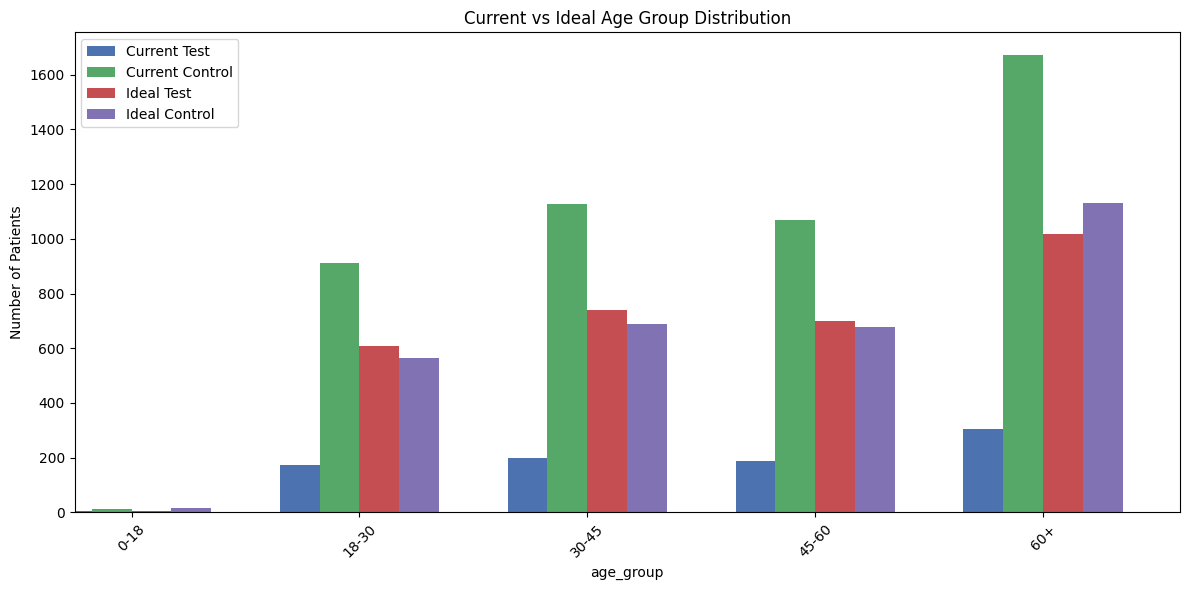

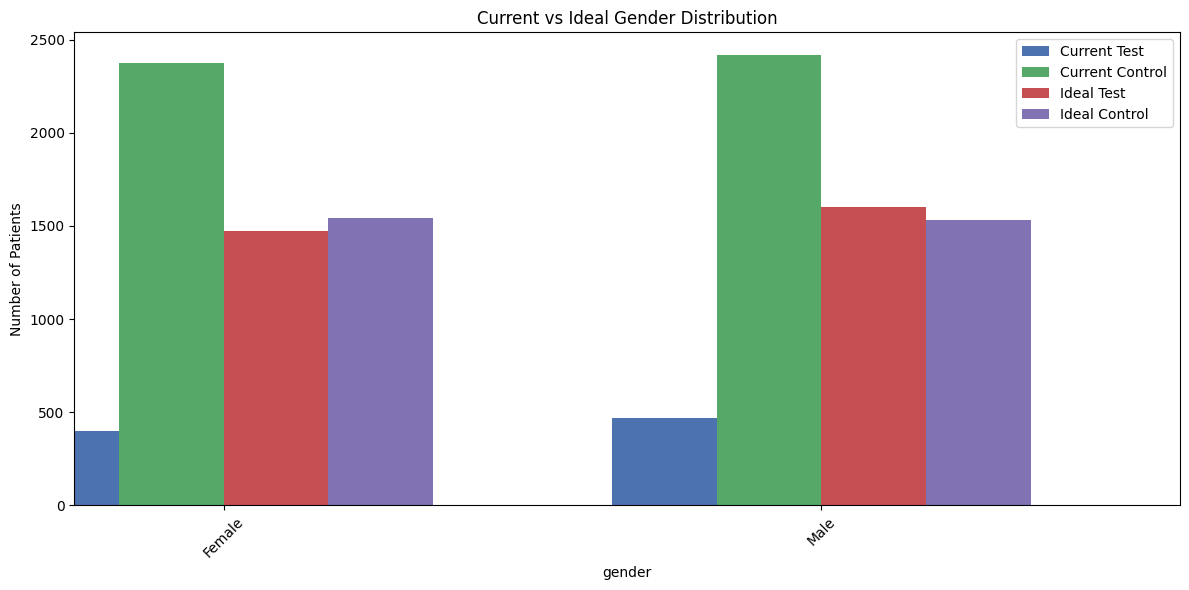

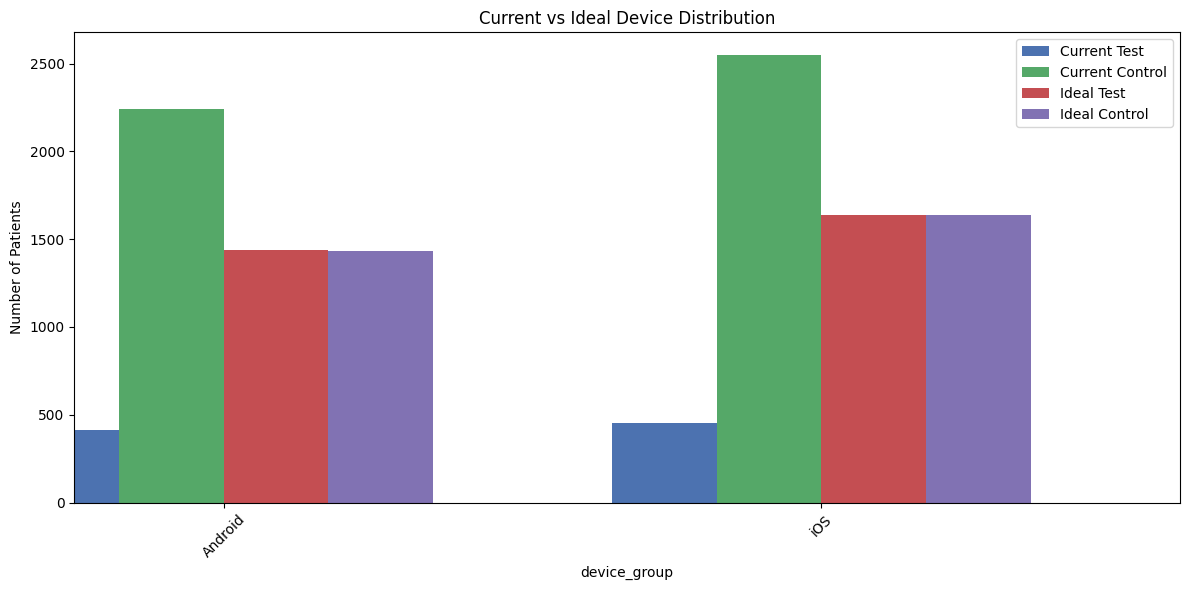

Current Group Sizes:
 group
Control     869
Test       1321
Name: patient_id, dtype: int64
Ideal Group Sizes:
 ideal_group
Control    1333
Test       1345
Name: patient_id, dtype: int64


In [115]:
# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices by iOS and Android
merged_data['device'] = merged_data['device'].str.lower()
merged_data['device_group'] = merged_data['device'].apply(lambda x: 'iOS' if 'ios' in x else ('Android' if 'android' in x else 'Other'))

# Define age groups for analysis
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '18-30', '30-45', '45-60', '60+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=age_bins, labels=age_labels, right=False)

# Shuffle the data to randomize assignment for ideal group creation
shuffled_data = merged_data.sample(frac=1, random_state=42)

# Ideal split: 50/50 between Test and Control groups
ideal_test_size = int(len(merged_data) * 0.5)

# Assign patients to Test and Control groups proportionally based on key parameters
shuffled_data['ideal_group'] = np.where(shuffled_data.index < ideal_test_size, 'Test', 'Control')

# Create a function to plot both current and ideal distributions with grouping
def plot_current_vs_ideal_grouped(param, title):
    # Group data for both current and ideal groups
    current_data = merged_data.groupby([param, 'group']).size().unstack(fill_value=0)
    ideal_data = shuffled_data.groupby([param, 'ideal_group']).size().unstack(fill_value=0)
    
    # Combine current and ideal for side-by-side comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35  # Width of bars
    
    # Plot current data
    current_data.plot(kind='bar', ax=ax, width=width, position=1, label='Current Distribution', color=['#4C72B0', '#55A868'])
    
    # Plot ideal data
    ideal_data.plot(kind='bar', ax=ax, width=width, position=0, label='Ideal Distribution', color=['#C44E52', '#8172B3'])
    
    plt.title(title)
    plt.ylabel('Number of Patients')
    plt.xlabel(param)
    plt.xticks(rotation=45)
    plt.legend(['Current Test', 'Current Control', 'Ideal Test', 'Ideal Control'])
    plt.tight_layout()
    plt.show()

# Plot comparisons for Traffic Source, Age Group, Gender, and Device Type with correct visuals
plot_current_vs_ideal_grouped('traffic_source', 'Current vs Ideal Traffic Source Distribution')
plot_current_vs_ideal_grouped('age_group', 'Current vs Ideal Age Group Distribution')
plot_current_vs_ideal_grouped('gender', 'Current vs Ideal Gender Distribution')
plot_current_vs_ideal_grouped('device_group', 'Current vs Ideal Device Distribution')

# Show the current and ideal distribution sizes for Test and Control groups
current_group_sizes = merged_data.groupby('group')['patient_id'].nunique()
ideal_group_sizes = shuffled_data.groupby('ideal_group')['patient_id'].nunique()

# Print the sizes for comparison
print("Current Group Sizes:\n", current_group_sizes)
print("Ideal Group Sizes:\n", ideal_group_sizes)

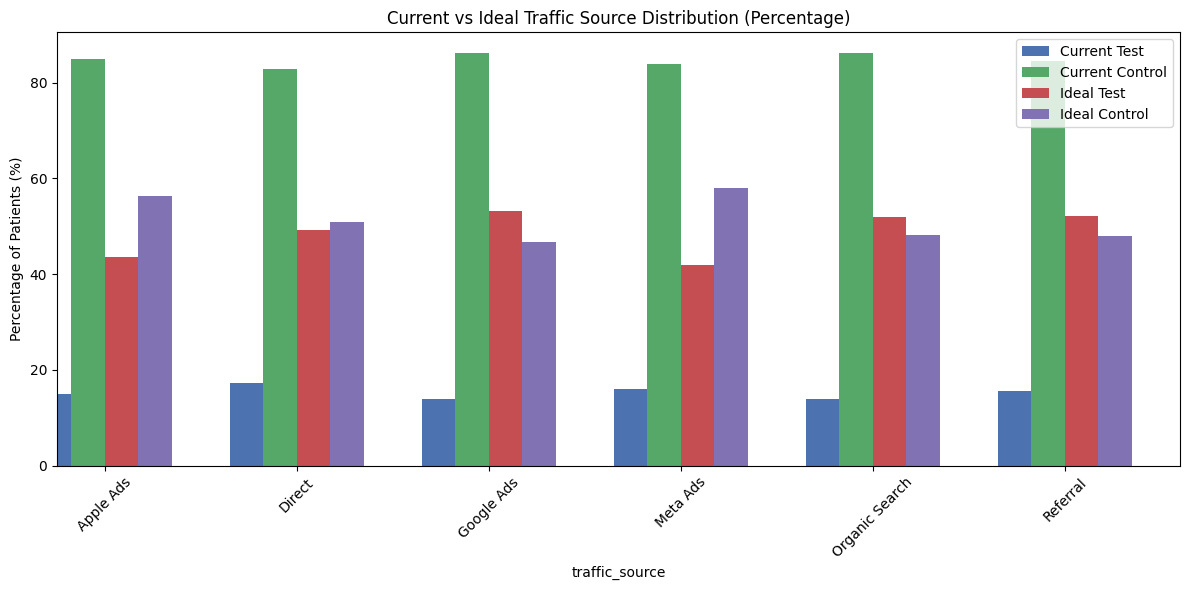

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/838962665.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  current_data = merged_data.groupby([param, 'group']).size().unstack(fill_value=0)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/838962665.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ideal_data = shuffled_data.groupby([param, 'ideal_group']).size().unstack(fill_value=0)


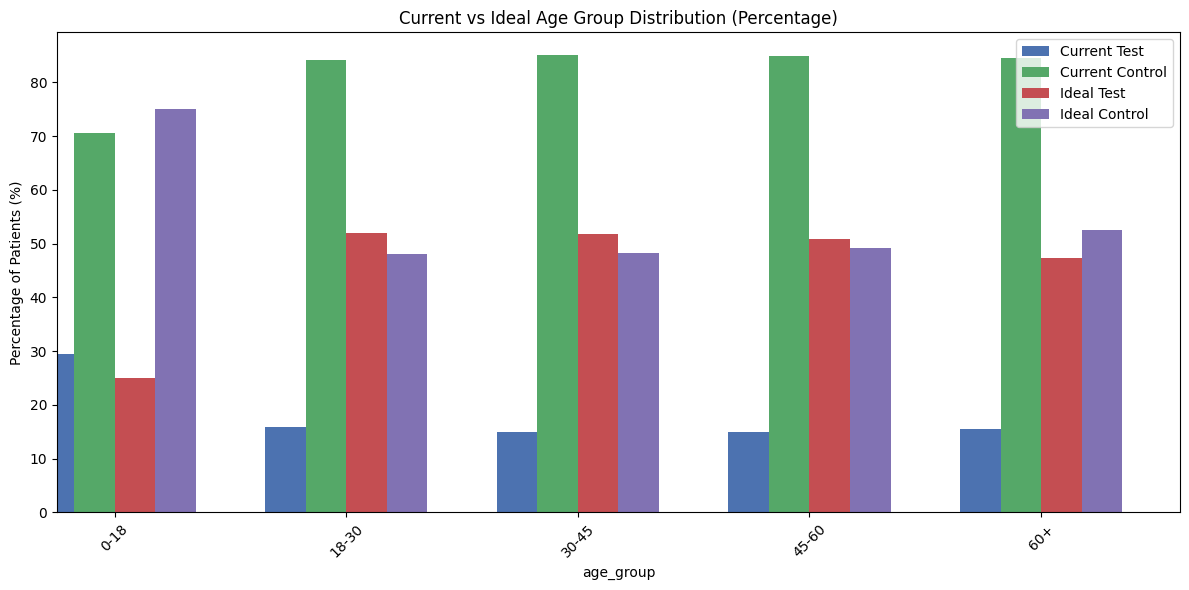

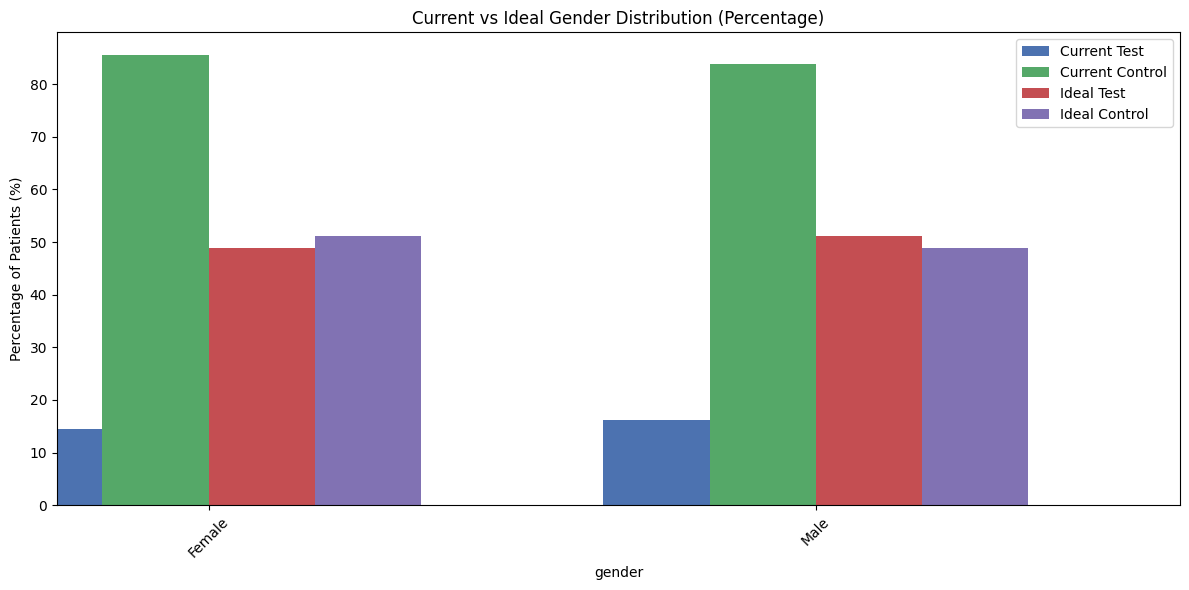

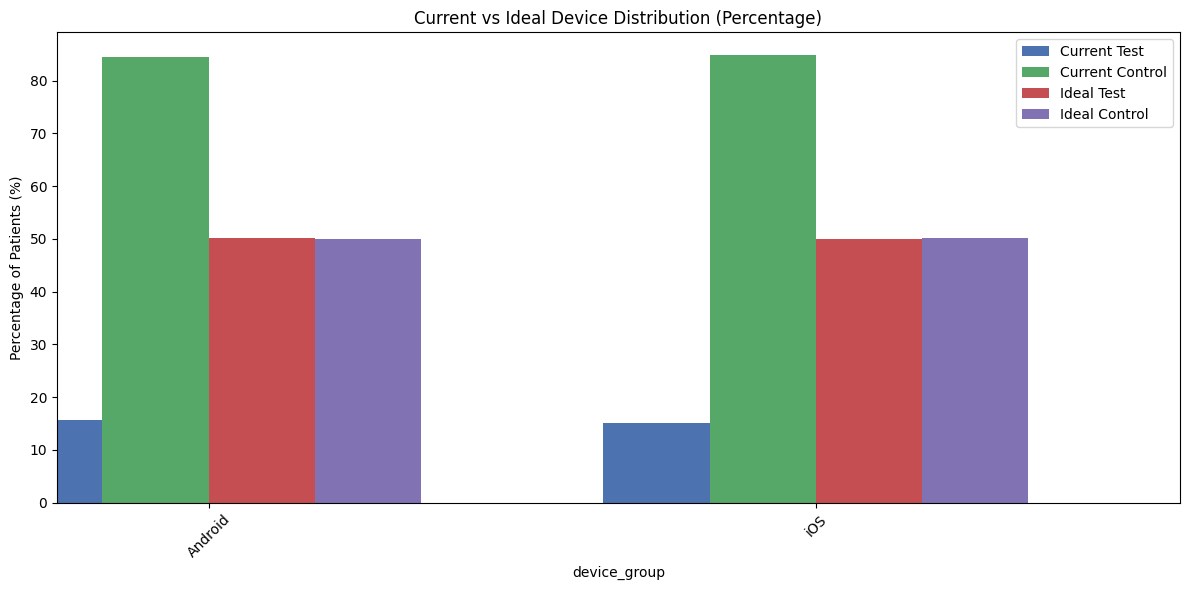


Current Group Sizes:
group
Control     869
Test       1321

Ideal Group Sizes:
ideal_group
Control    1333
Test       1345

Traffic Source Distribution (Current vs Ideal):
group           Control   Test
traffic_source                
Apple Ads         14.99  85.01
Direct            17.23  82.77
Google Ads        13.86  86.14
Meta Ads          16.08  83.92
Organic Search    13.81  86.19
Referral          15.58  84.42
ideal_group     Control   Test
traffic_source                
Apple Ads         43.62  56.38
Direct            49.17  50.83
Google Ads        53.26  46.74
Meta Ads          41.98  58.02
Organic Search    51.82  48.18
Referral          52.08  47.92

Age Group Distribution (Current vs Ideal):
group      Control   Test
age_group                
0-18         29.41  70.59
18-30        15.90  84.10
30-45        14.93  85.07
45-60        15.01  84.99
60+          15.44  84.56
ideal_group  Control   Test
age_group                  
0-18           25.00  75.00
18-30          52.00 

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices by iOS and Android
merged_data['device'] = merged_data['device'].str.lower()
merged_data['device_group'] = merged_data['device'].apply(lambda x: 'iOS' if 'ios' in x else ('Android' if 'android' in x else 'Other'))

# Define age groups for analysis
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '18-30', '30-45', '45-60', '60+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=age_bins, labels=age_labels, right=False)

# Shuffle the data to randomize assignment for ideal group creation
shuffled_data = merged_data.sample(frac=1, random_state=42)

# Ideal split: 50/50 between Test and Control groups
ideal_test_size = int(len(merged_data) * 0.5)

# Assign patients to Test and Control groups proportionally based on key parameters
shuffled_data['ideal_group'] = np.where(shuffled_data.index < ideal_test_size, 'Test', 'Control')

# Create a function to plot both current and ideal distributions with grouping (in percentages)
def plot_current_vs_ideal_grouped_percentage(param, title):
    # Group data for both current and ideal groups
    current_data = merged_data.groupby([param, 'group']).size().unstack(fill_value=0)
    ideal_data = shuffled_data.groupby([param, 'ideal_group']).size().unstack(fill_value=0)
    
    # Convert counts to percentages
    current_data_percentage = current_data.div(current_data.sum(axis=1), axis=0) * 100
    ideal_data_percentage = ideal_data.div(ideal_data.sum(axis=1), axis=0) * 100
    
    # Combine current and ideal for side-by-side comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35  # Width of bars
    
    # Plot current data percentages
    current_data_percentage.plot(kind='bar', ax=ax, width=width, position=1, label='Current Distribution', color=['#4C72B0', '#55A868'])
    
    # Plot ideal data percentages
    ideal_data_percentage.plot(kind='bar', ax=ax, width=width, position=0, label='Ideal Distribution', color=['#C44E52', '#8172B3'])
    
    plt.title(title)
    plt.ylabel('Percentage of Patients (%)')
    plt.xlabel(param)
    plt.xticks(rotation=45)
    plt.legend(['Current Test', 'Current Control', 'Ideal Test', 'Ideal Control'])
    plt.tight_layout()
    plt.show()
    
    # Return the DataFrames for both current and ideal percentage data
    return current_data_percentage, ideal_data_percentage

# Plot comparisons for Traffic Source, Age Group, Gender, and Device Type (percentage-based)
traffic_current, traffic_ideal = plot_current_vs_ideal_grouped_percentage('traffic_source', 'Current vs Ideal Traffic Source Distribution (Percentage)')
age_current, age_ideal = plot_current_vs_ideal_grouped_percentage('age_group', 'Current vs Ideal Age Group Distribution (Percentage)')
gender_current, gender_ideal = plot_current_vs_ideal_grouped_percentage('gender', 'Current vs Ideal Gender Distribution (Percentage)')
device_current, device_ideal = plot_current_vs_ideal_grouped_percentage('device_group', 'Current vs Ideal Device Distribution (Percentage)')

# Show the current and ideal distribution sizes for Test and Control groups
current_group_sizes = merged_data.groupby('group')['patient_id'].nunique()
ideal_group_sizes = shuffled_data.groupby('ideal_group')['patient_id'].nunique()

# Print the sizes for comparison
print("\nCurrent Group Sizes:")
print(current_group_sizes.to_string())

print("\nIdeal Group Sizes:")
print(ideal_group_sizes.to_string())

# Display the percentage DataFrames for traffic source, age group, gender, and device group in a more readable format
print("\nTraffic Source Distribution (Current vs Ideal):")
print(traffic_current.round(2).to_string())
print(traffic_ideal.round(2).to_string())

print("\nAge Group Distribution (Current vs Ideal):")
print(age_current.round(2).to_string())
print(age_ideal.round(2).to_string())

print("\nGender Distribution (Current vs Ideal):")
print(gender_current.round(2).to_string())
print(gender_ideal.round(2).to_string())

print("\nDevice Group Distribution (Current vs Ideal):")
print(device_current.round(2).to_string())
print(device_ideal.round(2).to_string())


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3518197055.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = merged_data.groupby(['age_group', 'group']).size().unstack(fill_value=0)


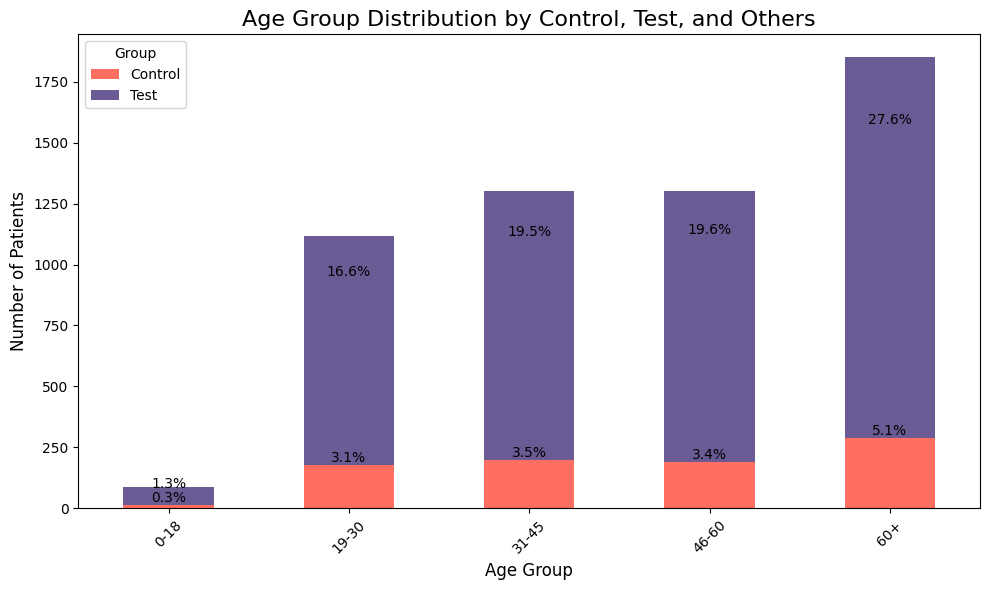

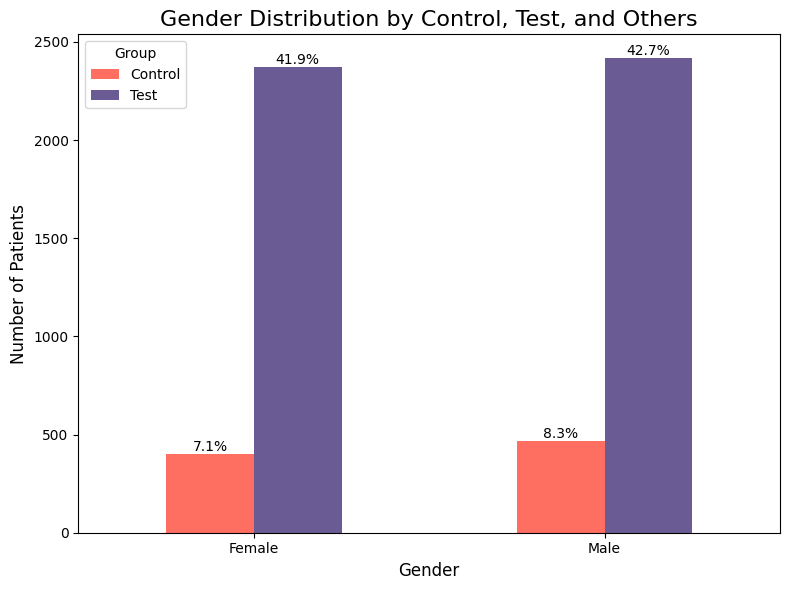

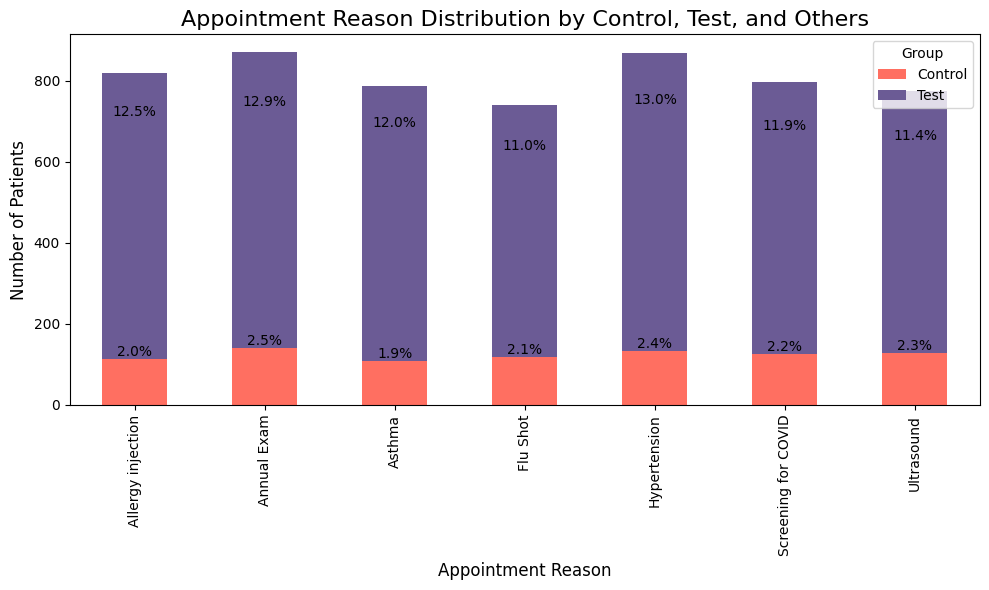

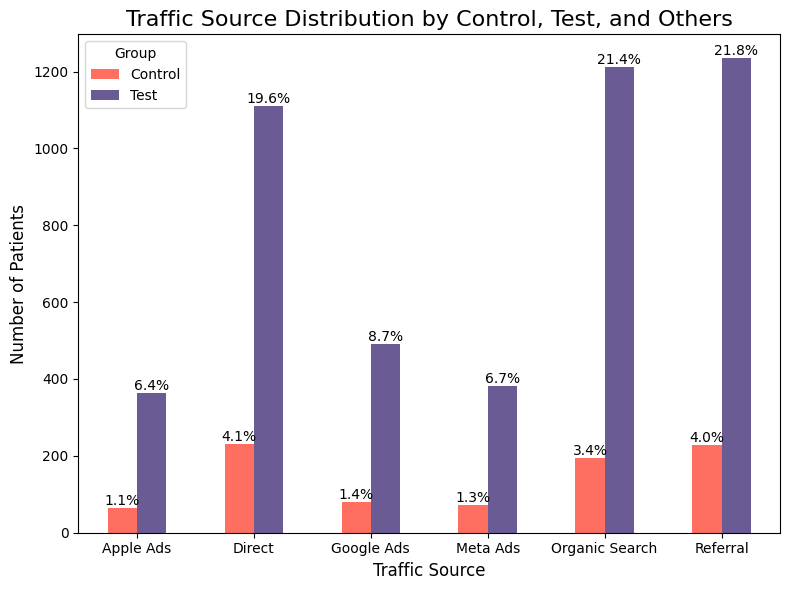

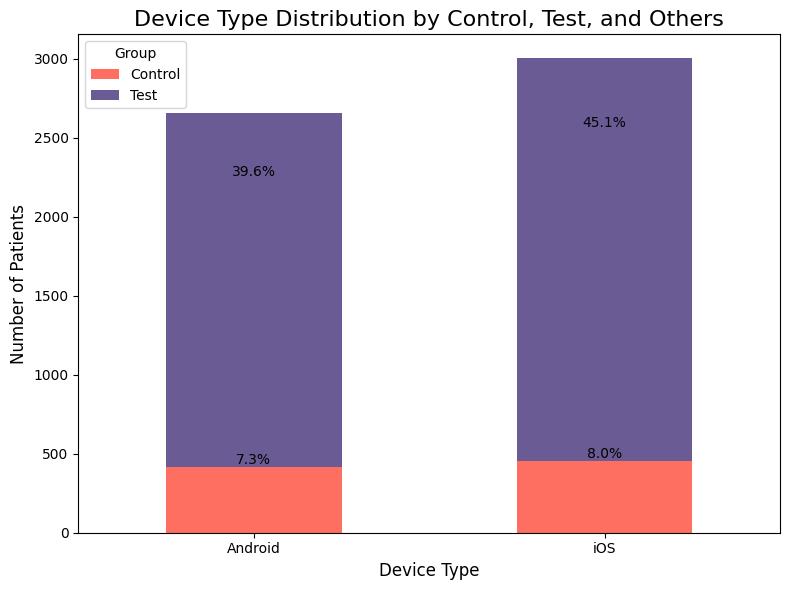

In [10]:
# Reload the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Step 1: Perform left join of appointments_data with app_data
merged_data = pd.merge(appointments_data, app_data, on='patient_id', how='left')

# Step 2: Perform left join of the result with ab_test_data
merged_data = pd.merge(merged_data, ab_test_data, on='patient_id', how='left')

# Use a more attractive color palette for visualizations
colors = ['#ff6f61', '#6b5b95', '#88b04b']

# Function to add percentage labels on the bar charts
def add_percentage(ax, total_counts):
    for p in ax.patches:
        percentage = f'{p.get_height() / total_counts * 100:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# 1. Age - Stacked Bar Chart with percentage
age_bins = [0, 18, 30, 45, 60, 100]
merged_data['age_group'] = pd.cut(merged_data['age'], bins=age_bins, labels=['0-18', '19-30', '31-45', '46-60', '60+'])

age_distribution = merged_data.groupby(['age_group', 'group']).size().unstack(fill_value=0)
ax = age_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
add_percentage(ax, age_distribution.sum().sum())
plt.title('Age Group Distribution by Control, Test, and Others', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Group', fontsize=10)
plt.tight_layout()
plt.show()

# 2. Gender - Grouped Bar Chart with percentage
gender_distribution = merged_data.groupby(['gender', 'group']).size().unstack(fill_value=0)
ax = gender_distribution.plot(kind='bar', color=colors, figsize=(8, 6))
add_percentage(ax, gender_distribution.sum().sum())
plt.title('Gender Distribution by Control, Test, and Others', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Group', fontsize=10)
plt.tight_layout()
plt.show()

# 3. Appointment Reason - Stacked Bar Chart with percentage
reason_distribution = merged_data.groupby(['appointment_reason', 'group']).size().unstack(fill_value=0)
ax = reason_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
add_percentage(ax, reason_distribution.sum().sum())
plt.title('Appointment Reason Distribution by Control, Test, and Others', fontsize=16)
plt.xlabel('Appointment Reason', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Group', fontsize=10)
plt.tight_layout()
plt.show()

# 4. Traffic Source - Grouped Bar Chart with percentage
traffic_distribution = merged_data.groupby(['traffic_source', 'group']).size().unstack(fill_value=0)
ax = traffic_distribution.plot(kind='bar', color=colors, figsize=(8, 6))
add_percentage(ax, traffic_distribution.sum().sum())
plt.title('Traffic Source Distribution by Control, Test, and Others', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Group', fontsize=10)
plt.tight_layout()
plt.show()

# 5. Device Type - Stacked Bar Chart with percentage
def map_device_type(device):
    device = device.lower()
    if 'ios' in device or 'iphone' in device or 'ipad' in device:
        return 'iOS'
    elif 'android' in device or 'samsung' in device:
        return 'Android'
    else:
        return 'Others'

# Apply the device mapping function to the 'device' column
if 'device' in merged_data.columns:
    merged_data['device'] = merged_data['device'].apply(map_device_type)

# Plot the device type distribution with percentages
device_distribution = merged_data.groupby(['device', 'group']).size().unstack(fill_value=0)
ax = device_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(8, 6))
add_percentage(ax, device_distribution.sum().sum())
plt.title('Device Type Distribution by Control, Test, and Others', fontsize=16)
plt.xlabel('Device Type', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Group', fontsize=10)
plt.tight_layout()
plt.show()



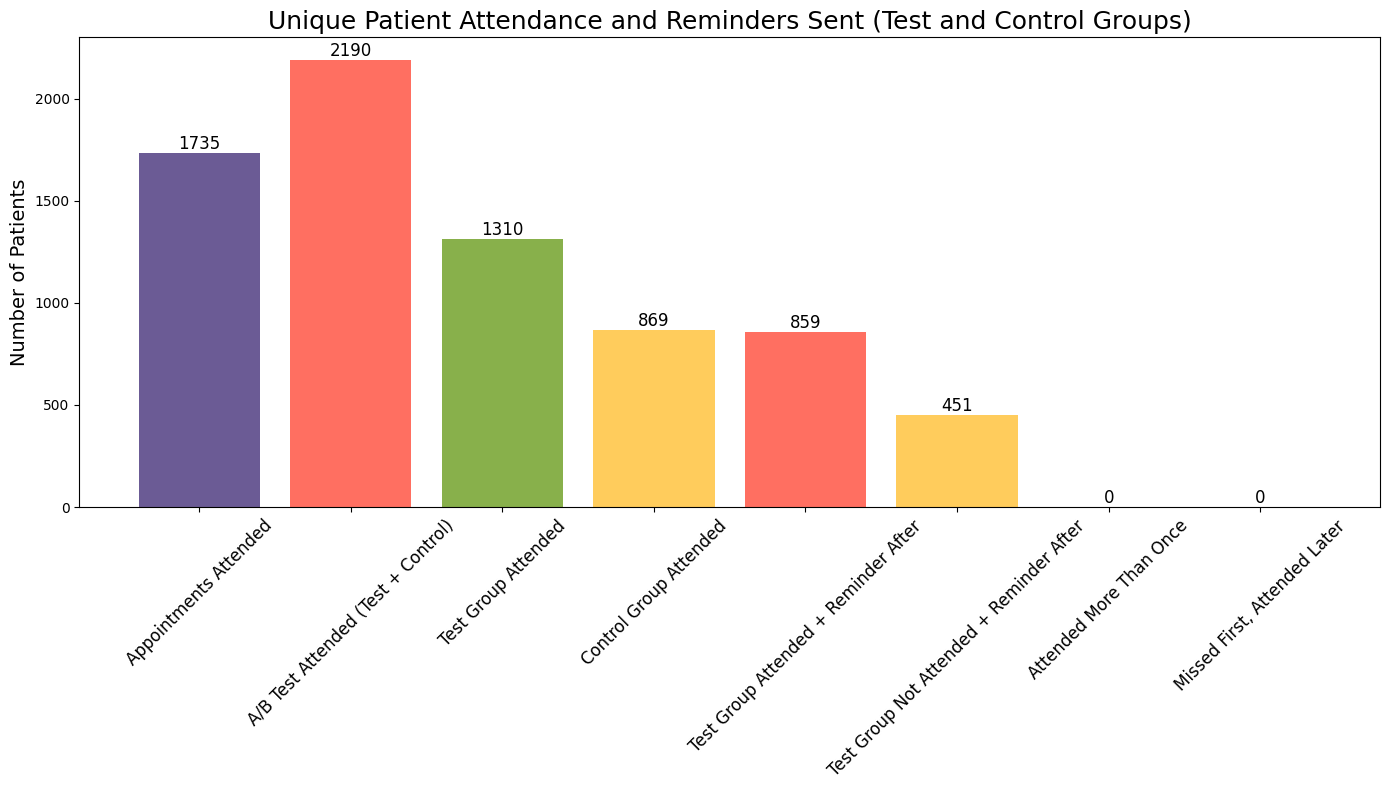

In [11]:

# Load the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Convert time-related columns to datetime format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Filter the Test group and Control group from ab_test_data
test_group_data = ab_test_data[ab_test_data['group'] == 'Test']
control_group_data = ab_test_data[ab_test_data['group'] == 'Control']

# Filter the reminder events from the Test group (Control group doesn't get reminders)
reminder_events_test_group = test_group_data[test_group_data['event_name'] == 'reminder_sent']

# 1. Unique Patients Attending in appointments_data (overall)
unique_patients_appointments_attended = appointments_data[appointments_data['appointment_status'] == 'Attended']['patient_id'].nunique()

# 2. Unique Patients Attending in Test Group (A/B Test Data)
unique_patients_test_attended = reminder_events_test_group['patient_id'].nunique()

# 3. Unique Patients Attending in Control Group (A/B Test Data)
unique_patients_control_attended = control_group_data['patient_id'].nunique()

# 4. Unique Patients Attending in the A/B Test Data (Test and Control combined)
unique_patients_ab_test_attended = ab_test_data['patient_id'].nunique()

# 5. Merge appointments_data with filtered reminder data (Test group only)
merged_data = pd.merge(appointments_data, reminder_events_test_group, on='patient_id', how='left')

# 6. Patients who attended the appointment in the Test group and received reminders after
attended_patients = merged_data[merged_data['appointment_status'] == 'Attended']

# Select reminders sent before the appointment date
attended_reminder_after = attended_patients[attended_patients['event_datetime'] < attended_patients['appointment_date']]
unique_attended_reminder_after = attended_reminder_after['patient_id'].nunique()

# 7. Patients who did not attend the appointment in the Test group and received reminders after
not_attended_patients = merged_data[merged_data['appointment_status'] != 'Attended']
not_attended_reminder_after = not_attended_patients[not_attended_patients['event_datetime'] < not_attended_patients['appointment_date']]
unique_not_attended_reminder_after = not_attended_reminder_after['patient_id'].nunique()

# --- New Part: Identifying Patients Attending More Than Once ---

# Group by patient_id and count how many times each patient attended appointments
appointment_counts = appointments_data.groupby('patient_id')['appointment_status'].value_counts().unstack(fill_value=0)

# Identify patients who attended more than one appointment
multiple_appointments = appointment_counts[appointment_counts['Attended'] > 1].index.nunique()

# Identify patients who did not attend the first time but attended in a later appointment
missed_first_but_attended_later = appointment_counts[(appointment_counts['Attended'] >= 1) & (appointment_counts['Not Attended'] >= 1)].index.nunique()

# Data for plotting
labels = ['Appointments Attended', 'A/B Test Attended (Test + Control)', 'Test Group Attended', 'Control Group Attended', 
          'Test Group Attended + Reminder After', 'Test Group Not Attended + Reminder After', 'Attended More Than Once', 
          'Missed First, Attended Later']
values = [unique_patients_appointments_attended, unique_patients_ab_test_attended, unique_patients_test_attended, 
          unique_patients_control_attended, unique_attended_reminder_after, unique_not_attended_reminder_after, 
          multiple_appointments, missed_first_but_attended_later]

# Create a larger bar chart with counts
plt.figure(figsize=(14, 8))  # Increased size
bars = plt.bar(labels, values, color=['#6b5b95', '#ff6f61', '#88b04b', '#ffcc5c', '#ff6f61', '#ffcc5c', '#6b5b95', '#ffcc5c'])
plt.title('Unique Patient Attendance and Reminders Sent (Test and Control Groups)', fontsize=18)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


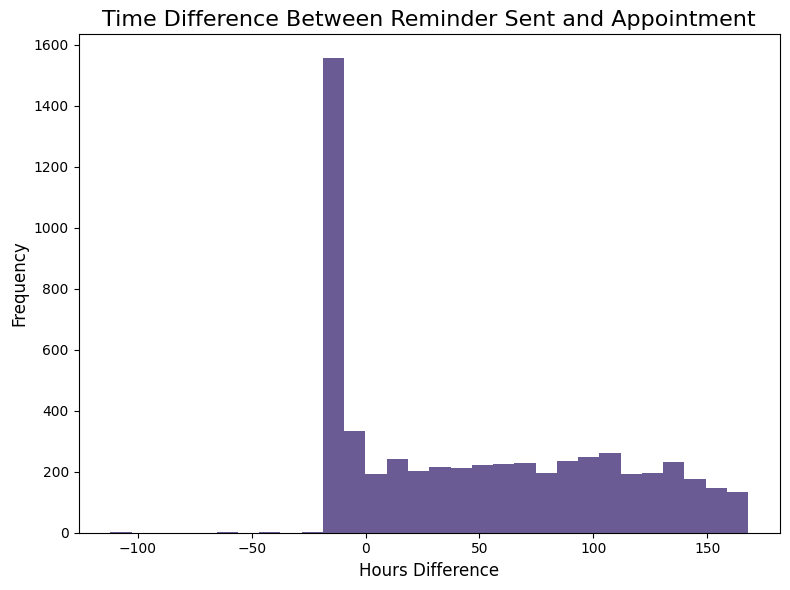

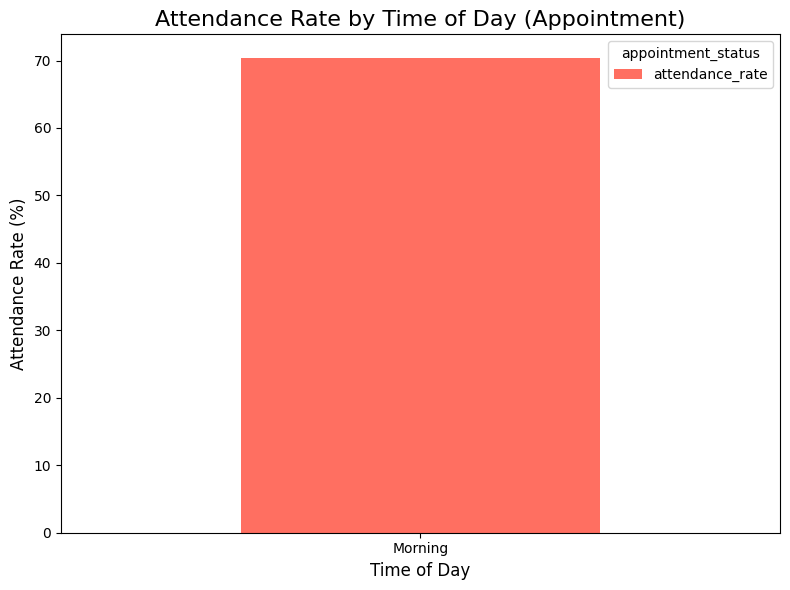

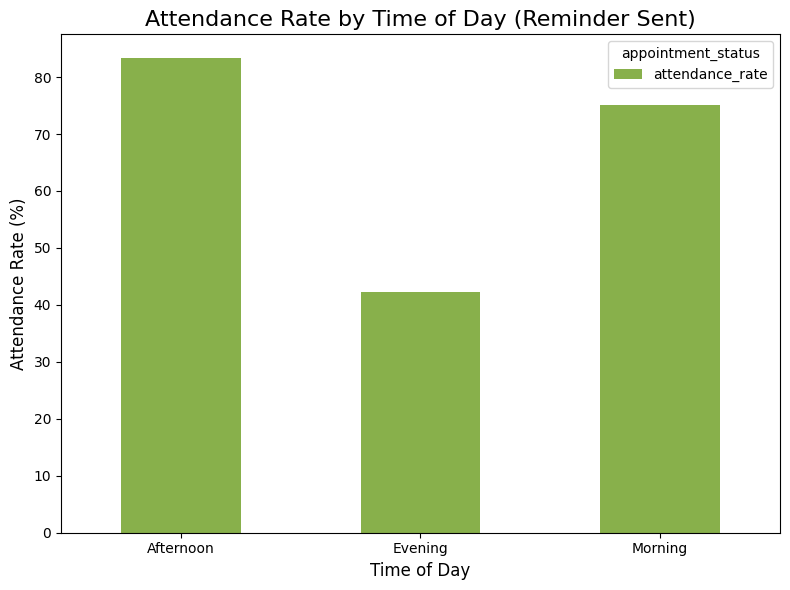

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/44031504.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_by_time_diff = merged_data.groupby(['time_diff_group', 'appointment_status']).size().unstack(fill_value=0)


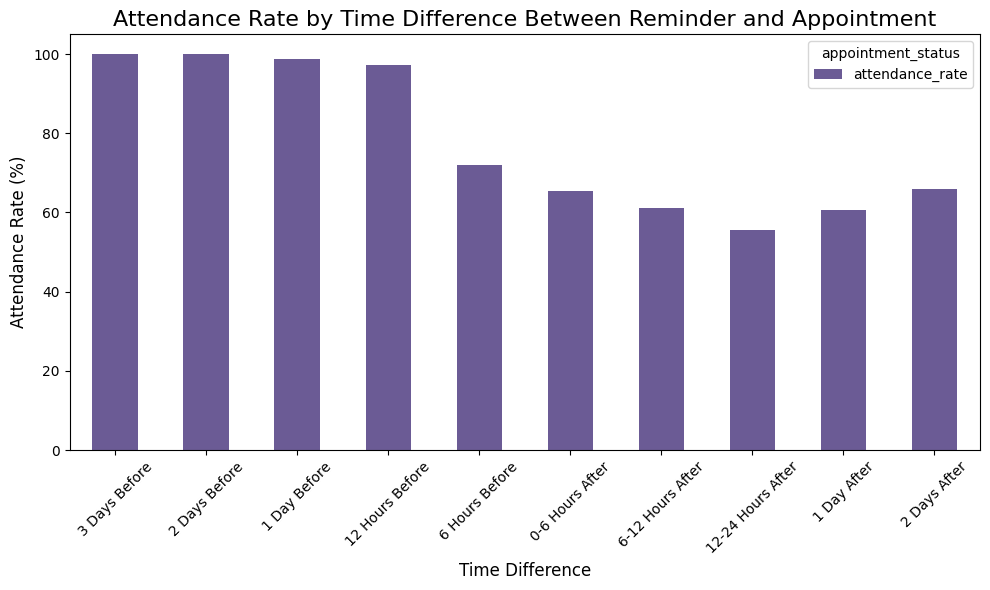

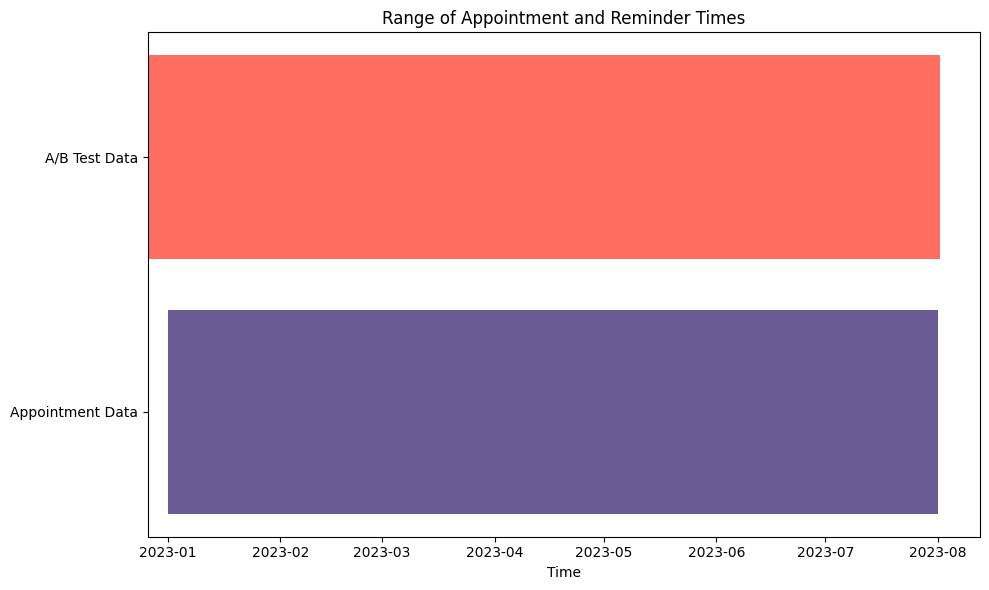

In [13]:

# Reload the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merge the datasets
merged_data = pd.merge(appointments_data, app_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, ab_test_data, on='patient_id', how='left')

# Convert time-related columns to datetime format
merged_data['appointment_time'] = pd.to_datetime(merged_data['appointment_date'])
merged_data['reminder_sent_time'] = pd.to_datetime(merged_data['event_datetime'])

# 1. Time Difference between Reminder and Appointment
merged_data['time_diff_hours'] = (merged_data['appointment_time'] - merged_data['reminder_sent_time']).dt.total_seconds() / 3600

# Plot the distribution of time difference (how many hours/days before the reminder was sent)
merged_data['time_diff_hours'].plot(kind='hist', bins=30, color='#6b5b95', figsize=(8, 6))
plt.title('Time Difference Between Reminder Sent and Appointment', fontsize=16)
plt.xlabel('Hours Difference', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Time of Day Analysis (Appointment Time)
def get_time_of_day(hour):
    if hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

merged_data['appointment_hour'] = merged_data['appointment_time'].dt.hour
merged_data['appointment_time_of_day'] = merged_data['appointment_hour'].apply(get_time_of_day)

# Plot attendance rate based on the time of day
attendance_by_time_of_day = merged_data.groupby(['appointment_time_of_day', 'appointment_status']).size().unstack(fill_value=0)
attendance_by_time_of_day['attendance_rate'] = (attendance_by_time_of_day['Attended'] / attendance_by_time_of_day.sum(axis=1)) * 100

attendance_by_time_of_day[['attendance_rate']].plot(kind='bar', color='#ff6f61', figsize=(8, 6))
plt.title('Attendance Rate by Time of Day (Appointment)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Reminder Sent Time vs Attendance (Hour Analysis)
merged_data['reminder_hour'] = merged_data['reminder_sent_time'].dt.hour
merged_data['reminder_time_of_day'] = merged_data['reminder_hour'].apply(get_time_of_day)

# Plot attendance rate based on the time of day the reminder was sent
attendance_by_reminder_time_of_day = merged_data.groupby(['reminder_time_of_day', 'appointment_status']).size().unstack(fill_value=0)
attendance_by_reminder_time_of_day['attendance_rate'] = (attendance_by_reminder_time_of_day['Attended'] / attendance_by_reminder_time_of_day.sum(axis=1)) * 100

attendance_by_reminder_time_of_day[['attendance_rate']].plot(kind='bar', color='#88b04b', figsize=(8, 6))
plt.title('Attendance Rate by Time of Day (Reminder Sent)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Detailed Analysis of Time Difference Impact on Attendance
time_diff_bins = [-72, -48, -24, -12, -6, 0, 6, 12, 24, 48, 72]
time_diff_labels = ['3 Days Before', '2 Days Before', '1 Day Before', '12 Hours Before', '6 Hours Before', '0-6 Hours After', '6-12 Hours After', '12-24 Hours After', '1 Day After', '2 Days After']

merged_data['time_diff_group'] = pd.cut(merged_data['time_diff_hours'], bins=time_diff_bins, labels=time_diff_labels)

# Plot attendance rate based on time difference groups
attendance_by_time_diff = merged_data.groupby(['time_diff_group', 'appointment_status']).size().unstack(fill_value=0)
attendance_by_time_diff['attendance_rate'] = (attendance_by_time_diff['Attended'] / attendance_by_time_diff.sum(axis=1)) * 100

attendance_by_time_diff[['attendance_rate']].plot(kind='bar', color='#6b5b95', figsize=(10, 6))
plt.title('Attendance Rate by Time Difference Between Reminder and Appointment', fontsize=16)
plt.xlabel('Time Difference', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional Analysis: Min and Max Date for Appointments and Reminders
# Convert to datetime for min/max analysis
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Min and Max appointment_time
min_appointment_time = appointments_data['appointment_date'].min()
max_appointment_time = appointments_data['appointment_date'].max()

# Min and Max reminder_sent_time
min_reminder_sent_time = ab_test_data['event_datetime'].min()
max_reminder_sent_time = ab_test_data['event_datetime'].max()

# Combined Visual
fig, ax = plt.subplots(figsize=(10, 6))

# Plot appointment time range
ax.barh('Appointment Data', left=min_appointment_time, width=max_appointment_time - min_appointment_time, color='#6b5b95')

# Plot reminder sent time range
ax.barh('A/B Test Data', left=min_reminder_sent_time, width=max_reminder_sent_time - min_reminder_sent_time, color='#ff6f61')

# Adding title and labels
ax.set_xlabel('Time')
ax.set_title('Range of Appointment and Reminder Times')
plt.tight_layout()
plt.show()


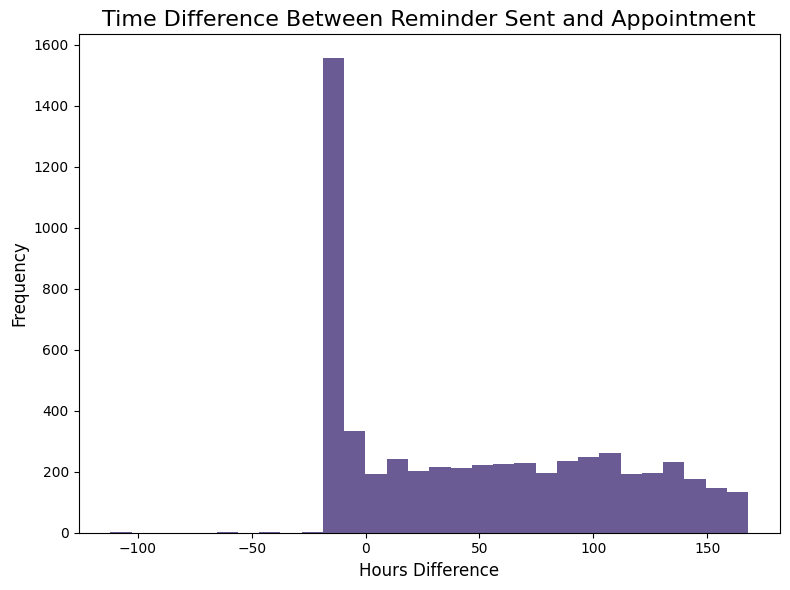

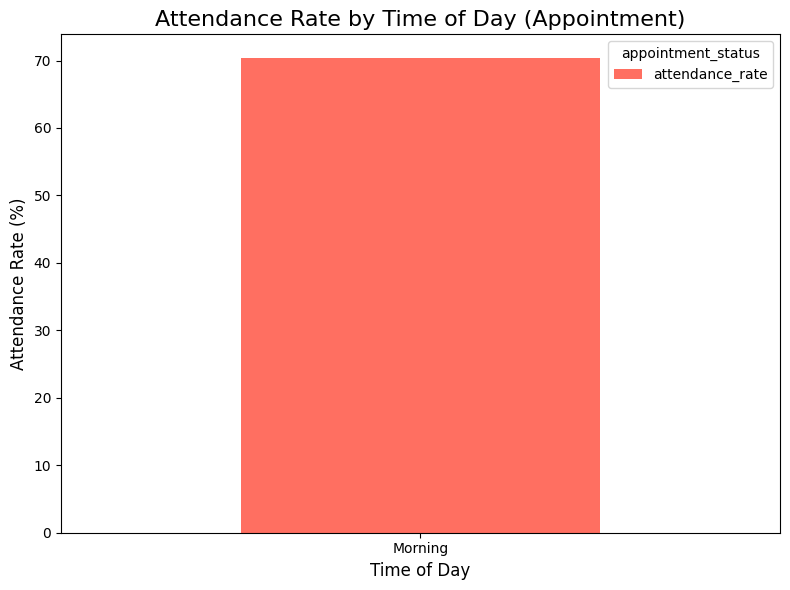

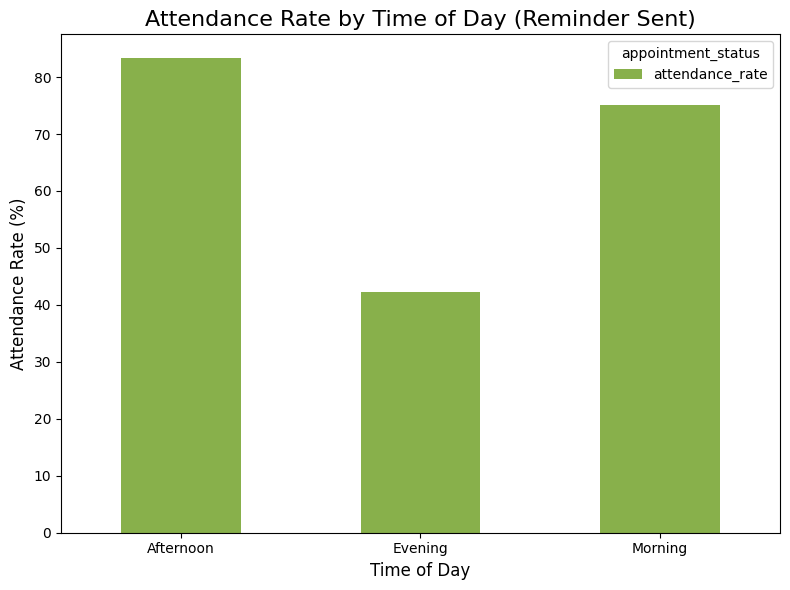

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2567588193.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_by_time_diff = merged_data.groupby(['time_diff_group', 'appointment_status']).size().unstack(fill_value=0)


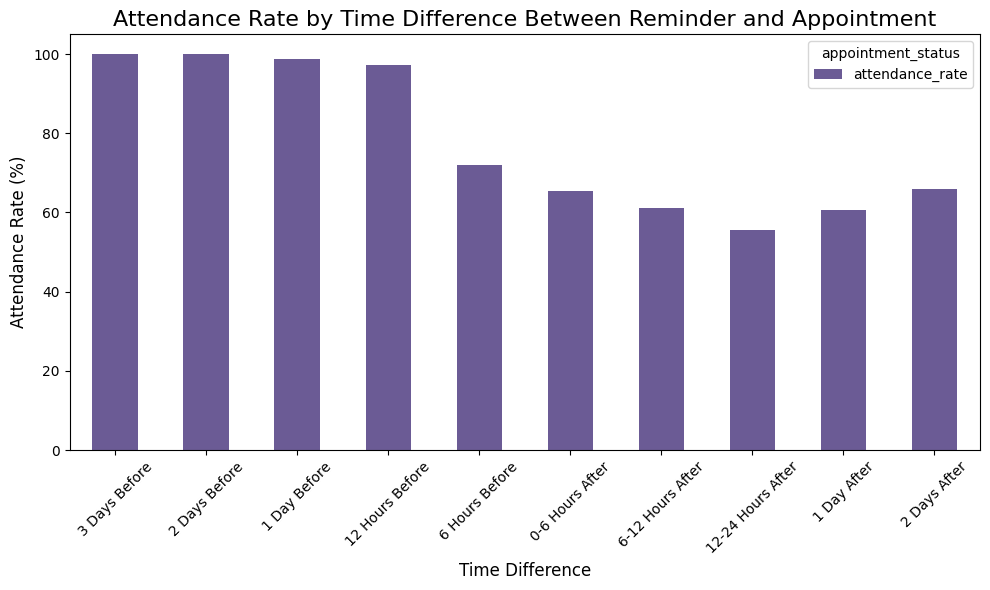

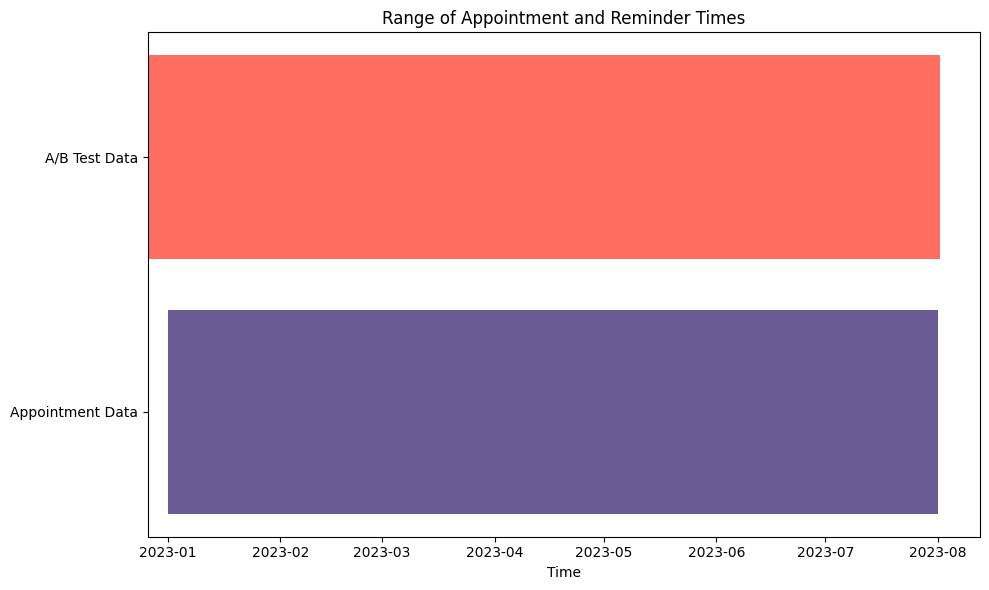

In [14]:

# Reload the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merge the datasets
merged_data = pd.merge(appointments_data, app_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, ab_test_data, on='patient_id', how='left')

# Convert time-related columns to datetime format
merged_data['appointment_time'] = pd.to_datetime(merged_data['appointment_date'])
merged_data['reminder_sent_time'] = pd.to_datetime(merged_data['event_datetime'])

# 1. Time Difference between Reminder and Appointment
merged_data['time_diff_hours'] = (merged_data['appointment_time'] - merged_data['reminder_sent_time']).dt.total_seconds() / 3600

# Plot the distribution of time difference (how many hours/days before the reminder was sent)
merged_data['time_diff_hours'].plot(kind='hist', bins=30, color='#6b5b95', figsize=(8, 6))
plt.title('Time Difference Between Reminder Sent and Appointment', fontsize=16)
plt.xlabel('Hours Difference', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Time of Day Analysis (Appointment Time)
def get_time_of_day(hour):
    if hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

merged_data['appointment_hour'] = merged_data['appointment_time'].dt.hour
merged_data['appointment_time_of_day'] = merged_data['appointment_hour'].apply(get_time_of_day)

# Plot attendance rate based on the time of day
attendance_by_time_of_day = merged_data.groupby(['appointment_time_of_day', 'appointment_status']).size().unstack(fill_value=0)
attendance_by_time_of_day['attendance_rate'] = (attendance_by_time_of_day['Attended'] / attendance_by_time_of_day.sum(axis=1)) * 100

attendance_by_time_of_day[['attendance_rate']].plot(kind='bar', color='#ff6f61', figsize=(8, 6))
plt.title('Attendance Rate by Time of Day (Appointment)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Reminder Sent Time vs Attendance (Hour Analysis)
merged_data['reminder_hour'] = merged_data['reminder_sent_time'].dt.hour
merged_data['reminder_time_of_day'] = merged_data['reminder_hour'].apply(get_time_of_day)

# Plot attendance rate based on the time of day the reminder was sent
attendance_by_reminder_time_of_day = merged_data.groupby(['reminder_time_of_day', 'appointment_status']).size().unstack(fill_value=0)
attendance_by_reminder_time_of_day['attendance_rate'] = (attendance_by_reminder_time_of_day['Attended'] / attendance_by_reminder_time_of_day.sum(axis=1)) * 100

attendance_by_reminder_time_of_day[['attendance_rate']].plot(kind='bar', color='#88b04b', figsize=(8, 6))
plt.title('Attendance Rate by Time of Day (Reminder Sent)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Detailed Analysis of Time Difference Impact on Attendance
time_diff_bins = [-72, -48, -24, -12, -6, 0, 6, 12, 24, 48, 72]
time_diff_labels = ['3 Days Before', '2 Days Before', '1 Day Before', '12 Hours Before', '6 Hours Before', '0-6 Hours After', '6-12 Hours After', '12-24 Hours After', '1 Day After', '2 Days After']

merged_data['time_diff_group'] = pd.cut(merged_data['time_diff_hours'], bins=time_diff_bins, labels=time_diff_labels)

# Plot attendance rate based on time difference groups
attendance_by_time_diff = merged_data.groupby(['time_diff_group', 'appointment_status']).size().unstack(fill_value=0)
attendance_by_time_diff['attendance_rate'] = (attendance_by_time_diff['Attended'] / attendance_by_time_diff.sum(axis=1)) * 100

attendance_by_time_diff[['attendance_rate']].plot(kind='bar', color='#6b5b95', figsize=(10, 6))
plt.title('Attendance Rate by Time Difference Between Reminder and Appointment', fontsize=16)
plt.xlabel('Time Difference', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Convert to datetime for min/max analysis
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Min and Max appointment_time
min_appointment_time = appointments_data['appointment_date'].min()
max_appointment_time = appointments_data['appointment_date'].max()

# Min and Max reminder_sent_time
min_reminder_sent_time = ab_test_data['event_datetime'].min()
max_reminder_sent_time = ab_test_data['event_datetime'].max()

# Combined Visual
fig, ax = plt.subplots(figsize=(10, 6))

# Plot appointment time range
ax.barh('Appointment Data', left=min_appointment_time, width=max_appointment_time - min_appointment_time, color='#6b5b95')

# Plot reminder sent time range
ax.barh('A/B Test Data', left=min_reminder_sent_time, width=max_reminder_sent_time - min_reminder_sent_time, color='#ff6f61')

# Adding title and labels
ax.set_xlabel('Time')
ax.set_title('Range of Appointment and Reminder Times')
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2262707796.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = merged_data.groupby(['age_group', 'group']).size().unstack(fill_value=0)


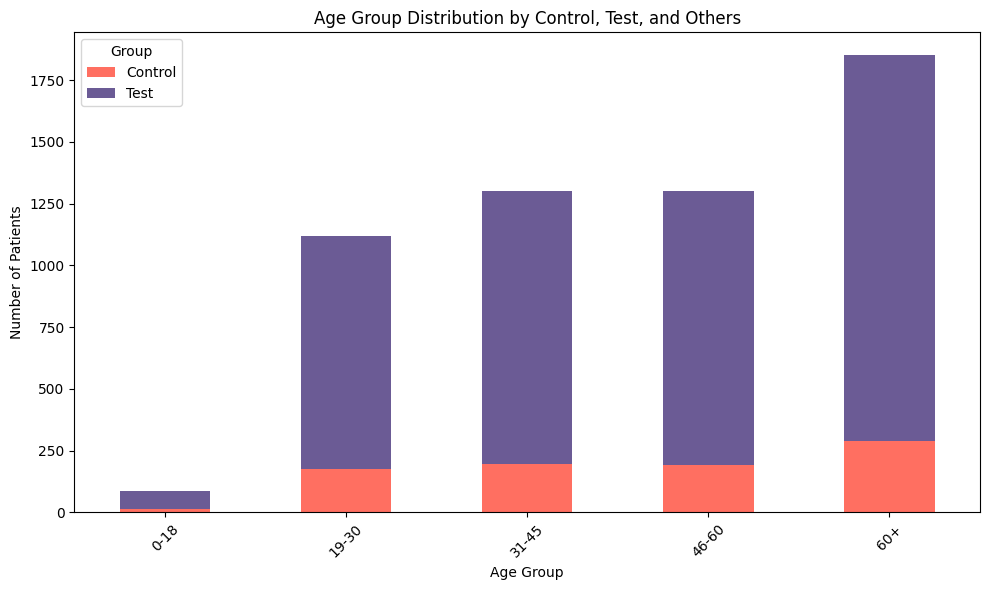

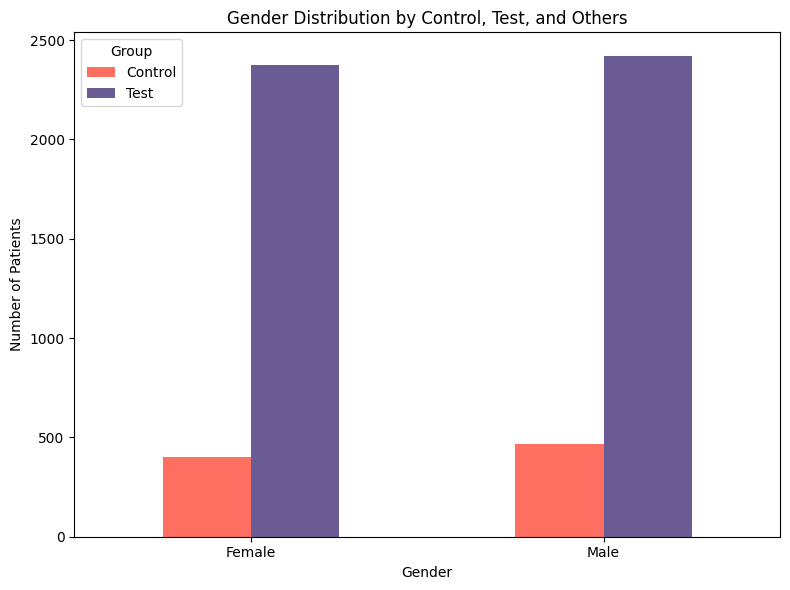

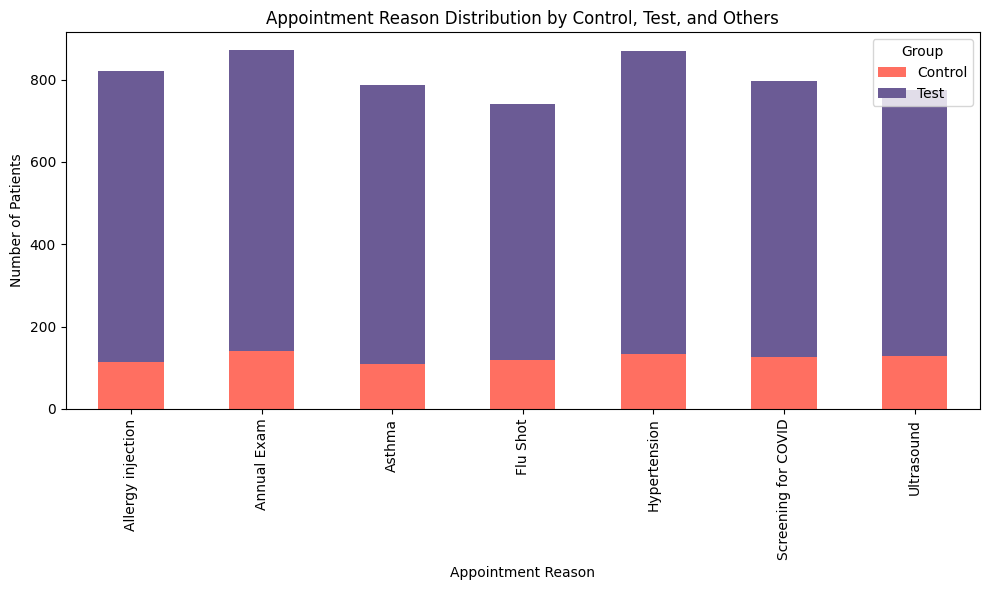

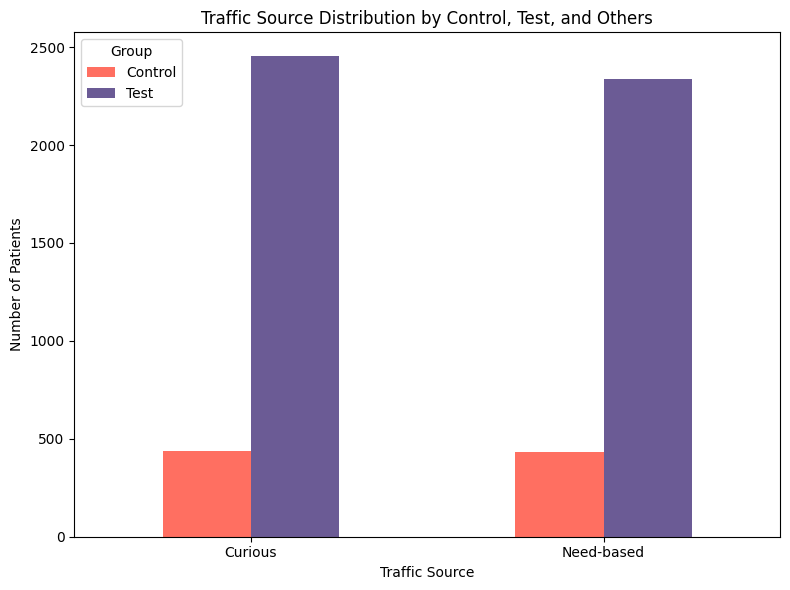

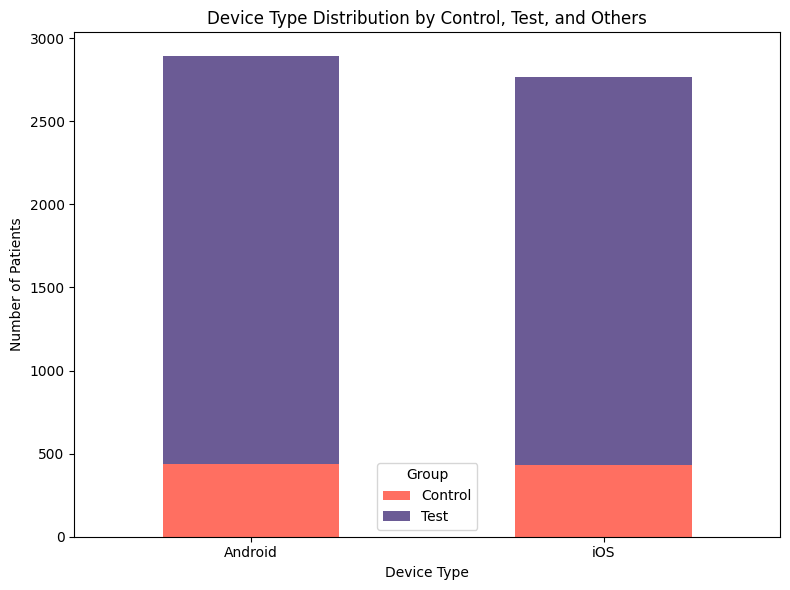

In [15]:

# Load the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merge the datasets on patient_id to get full information
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='inner')

# Define the colors for control, test, and others
colors = ['#ff6f61', '#6b5b95', '#88b04b']

# 1. Age - Stacked Bar Chart
age_bins = [0, 18, 30, 45, 60, 100]
merged_data['age_group'] = pd.cut(merged_data['age'], bins=age_bins, labels=['0-18', '19-30', '31-45', '46-60', '60+'])

age_distribution = merged_data.groupby(['age_group', 'group']).size().unstack(fill_value=0)
age_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
plt.title('Age Group Distribution by Control, Test, and Others')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# 2. Gender - Grouped Bar Chart
gender_distribution = merged_data.groupby(['gender', 'group']).size().unstack(fill_value=0)
gender_distribution.plot(kind='bar', color=colors, figsize=(8, 6))
plt.title('Gender Distribution by Control, Test, and Others')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# 3. Appointment Reason - Stacked Bar Chart
reason_distribution = merged_data.groupby(['appointment_reason', 'group']).size().unstack(fill_value=0)
reason_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
plt.title('Appointment Reason Distribution by Control, Test, and Others')
plt.xlabel('Appointment Reason')
plt.ylabel('Number of Patients')
plt.xticks(rotation=90)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# 4. Traffic Source - Grouped Bar Chart
# Assuming traffic source is available in the data (modify if needed)
merged_data['traffic_source'] = merged_data['patient_id'].apply(lambda x: 'Need-based' if x % 2 == 0 else 'Curious')
traffic_distribution = merged_data.groupby(['traffic_source', 'group']).size().unstack(fill_value=0)
traffic_distribution.plot(kind='bar', color=colors, figsize=(8, 6))
plt.title('Traffic Source Distribution by Control, Test, and Others')
plt.xlabel('Traffic Source')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# 5. Device Type - Stacked Bar Chart
# Assuming device type is available in the data (modify if needed)
merged_data['device_type'] = merged_data['patient_id'].apply(lambda x: 'iOS' if x % 2 == 0 else 'Android')
device_distribution = merged_data.groupby(['device_type', 'group']).size().unstack(fill_value=0)
device_distribution.plot(kind='bar', stacked=True, color=colors, figsize=(8, 6))
plt.title('Device Type Distribution by Control, Test, and Others')
plt.xlabel('Device Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Group')
plt.tight_layout()
plt.show()


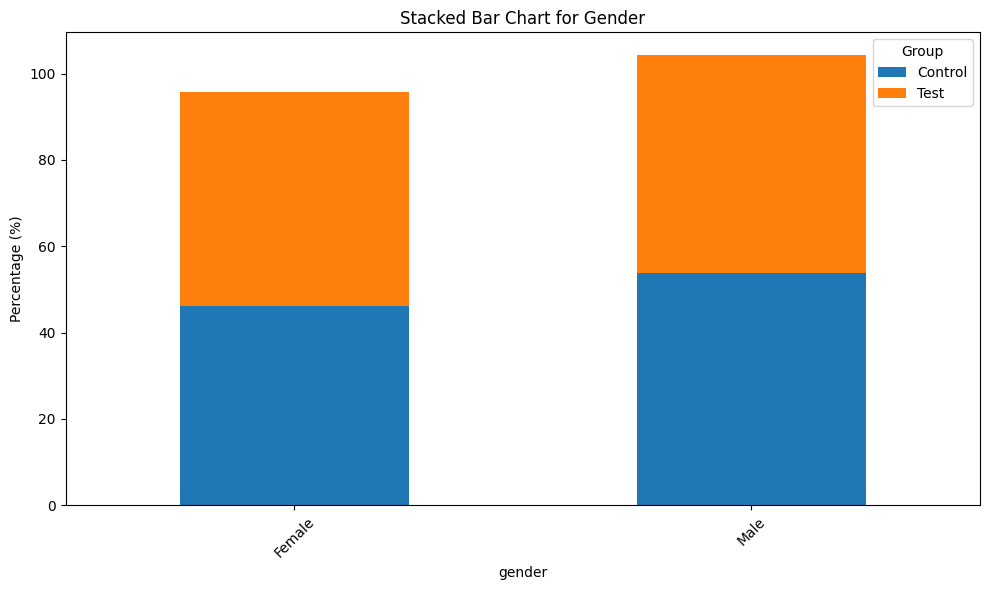

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/837653777.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_share = merged_data.groupby(['group', parameter]).size().reset_index(name='count')
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/837653777.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = group_share_percentage.pivot_table(index=parameter, columns='group', values='percentage', fill_value=0)


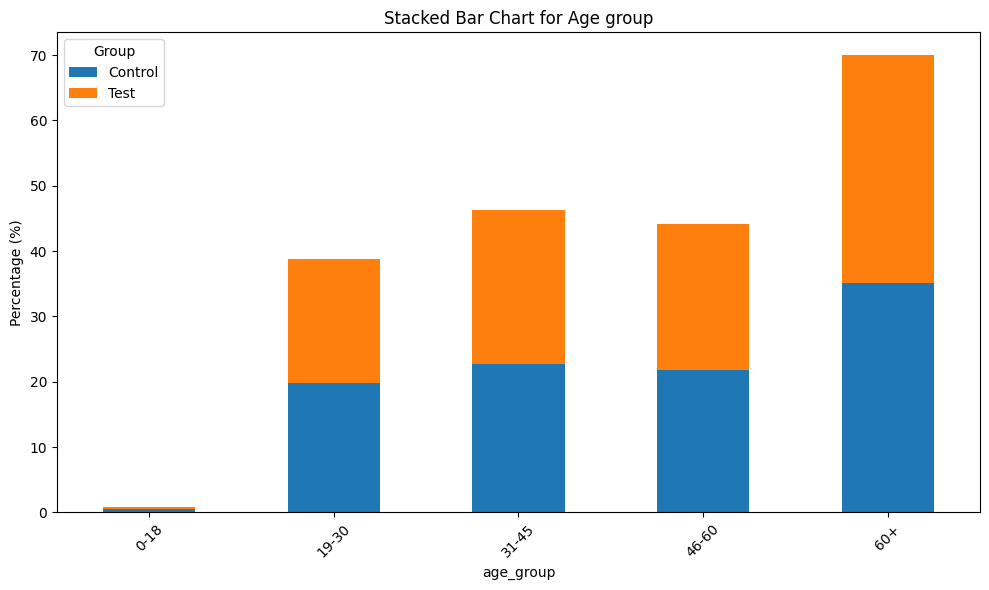

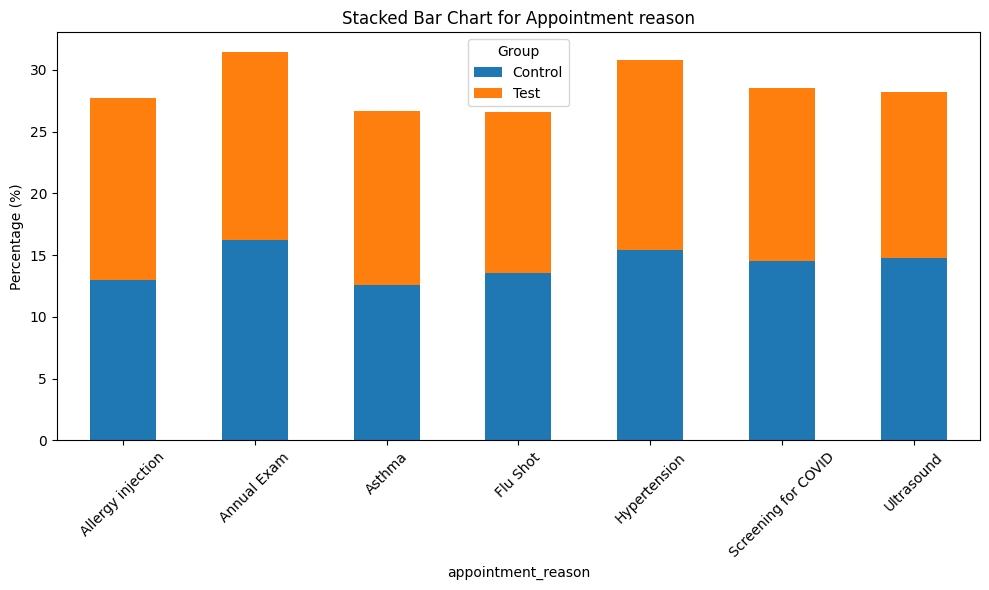

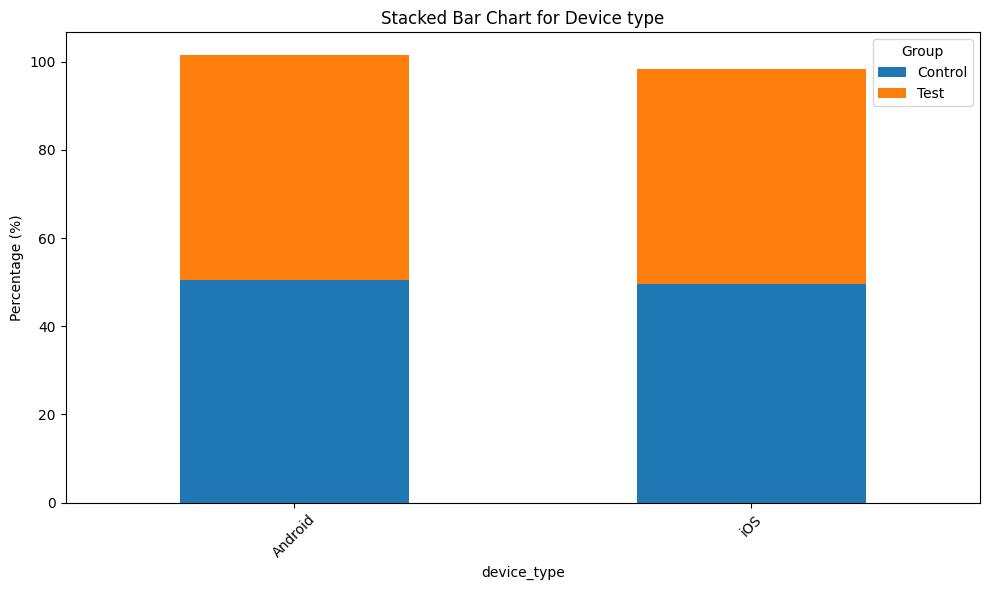

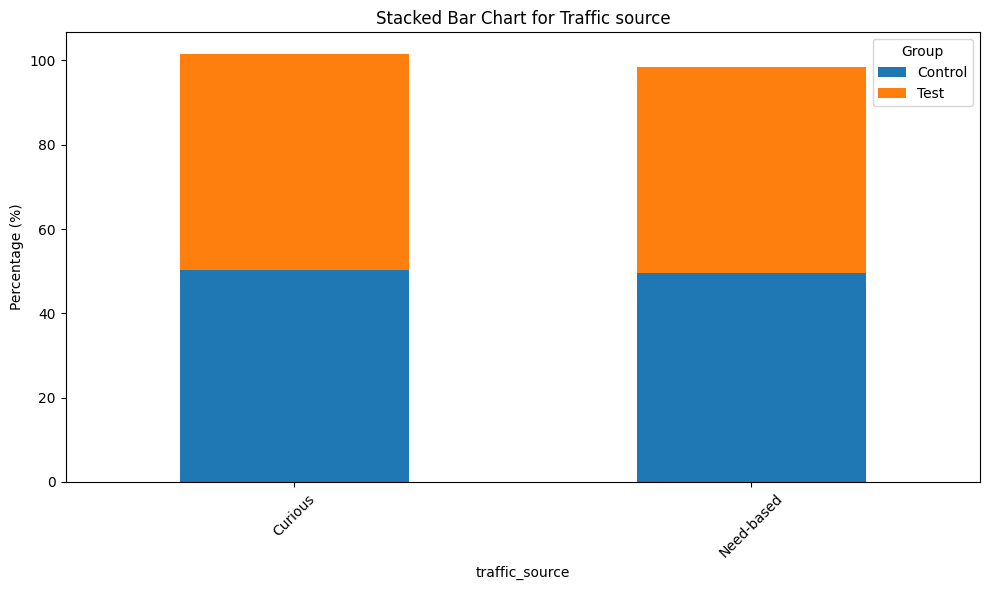

<Figure size 1000x600 with 0 Axes>

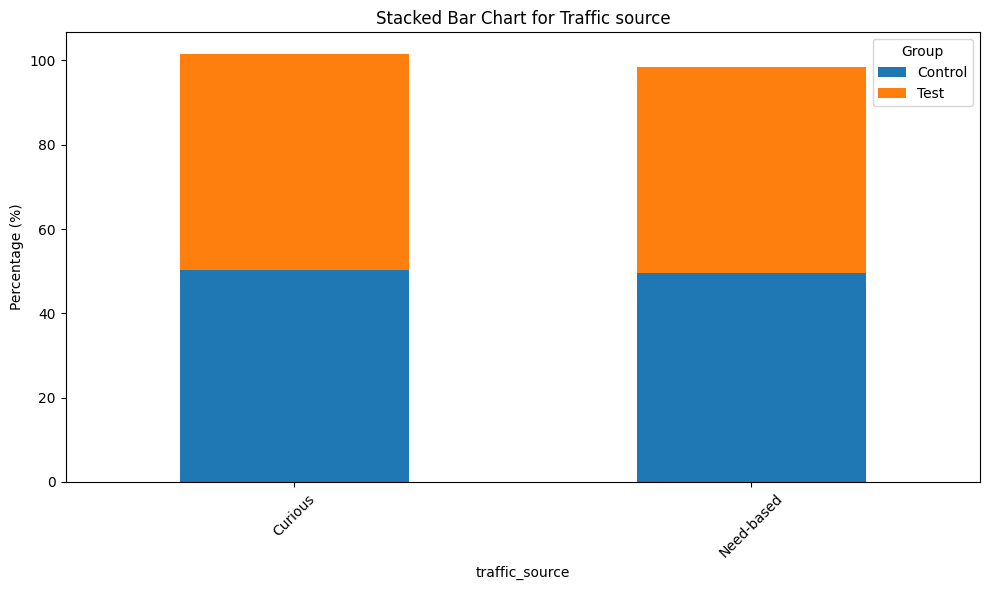

In [16]:

# Load the datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on 'patient_id' to get a combined view
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='inner')

# Add placeholder columns for 'device_type' and 'traffic_source' if these exist in the dataset
# If not, they can be added manually or from another dataset
if 'device_type' not in merged_data.columns:
    merged_data['device_type'] = merged_data['patient_id'].apply(lambda x: 'iOS' if x % 2 == 0 else 'Android')  # Example grouping logic
if 'traffic_source' not in merged_data.columns:
    merged_data['traffic_source'] = merged_data['patient_id'].apply(lambda x: 'Need-based' if x % 2 == 0 else 'Curious')  # Example grouping logic

# Create age groups
bins = [0, 18, 30, 45, 60, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '60+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Calculate the total count for Test and Control groups
total_counts = merged_data.groupby('group').size().reset_index(name='total_count')

# Parameters to visualize
parameters = ['gender', 'age_group', 'appointment_reason', 'device_type', 'traffic_source']

# Function to plot stacked bar chart
def plot_stacked_bar_chart(group_share_percentage, parameter):
    pivot_df = group_share_percentage.pivot_table(index=parameter, columns='group', values='percentage', fill_value=0)
    
    # Plot stacked bar chart
    pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    plt.ylabel('Percentage (%)')
    plt.title(f'Stacked Bar Chart for {parameter.replace("_", " ").capitalize()}')
    plt.xticks(rotation=45)
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

# Group by 'group' and each parameter separately, calculate percentages, and plot the stacked bar charts
for parameter in parameters:
    group_share = merged_data.groupby(['group', parameter]).size().reset_index(name='count')
    group_share_percentage = pd.merge(group_share, total_counts, on='group')
    group_share_percentage['percentage'] = (group_share_percentage['count'] / group_share_percentage['total_count']) * 100
    
    # Plot stacked bar chart for each parameter
    plot_stacked_bar_chart(group_share_percentage, parameter)

# Ungrouped traffic source (without age grouping)
plt.figure(figsize=(10, 6))
group_share_ungrouped = merged_data.groupby(['group', 'traffic_source']).size().reset_index(name='count')
group_share_percentage_ungrouped = pd.merge(group_share_ungrouped, total_counts, on='group')
group_share_percentage_ungrouped['percentage'] = (group_share_percentage_ungrouped['count'] / group_share_percentage_ungrouped['total_count']) * 100

# Plot stacked bar chart for ungrouped traffic source
plot_stacked_bar_chart(group_share_percentage_ungrouped, 'traffic_source')


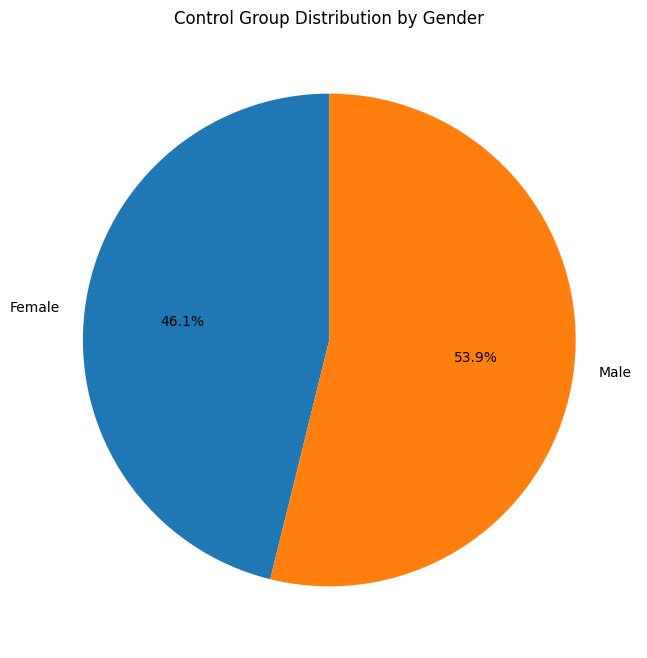

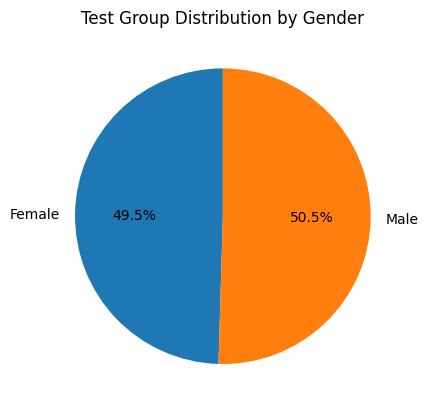

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/71135533.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_share = merged_data.groupby(['group', parameter]).size().reset_index(name='count')


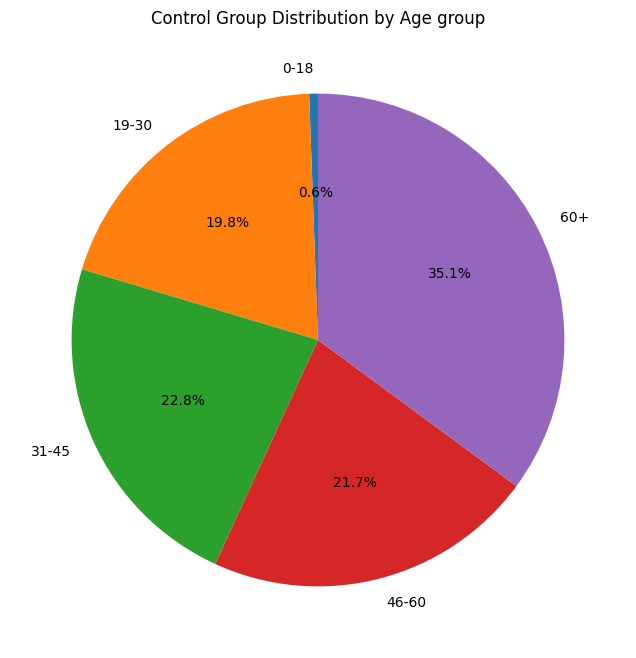

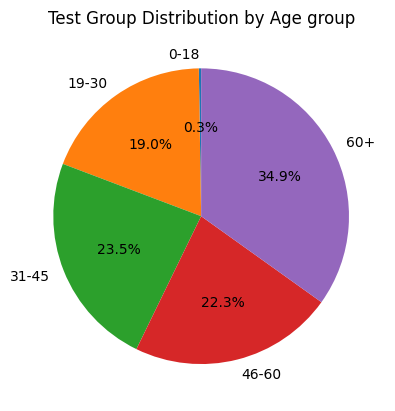

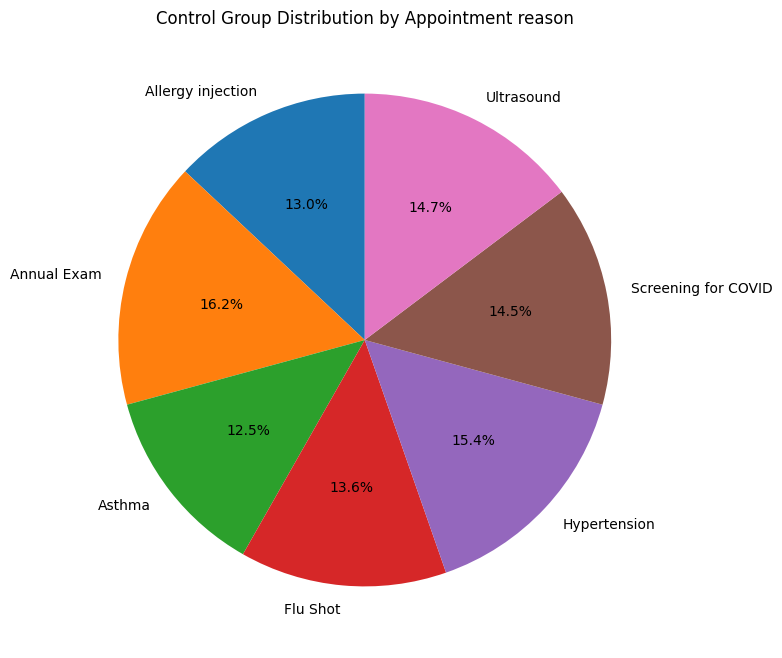

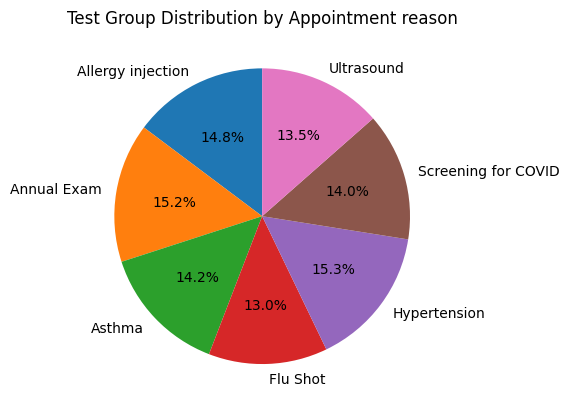

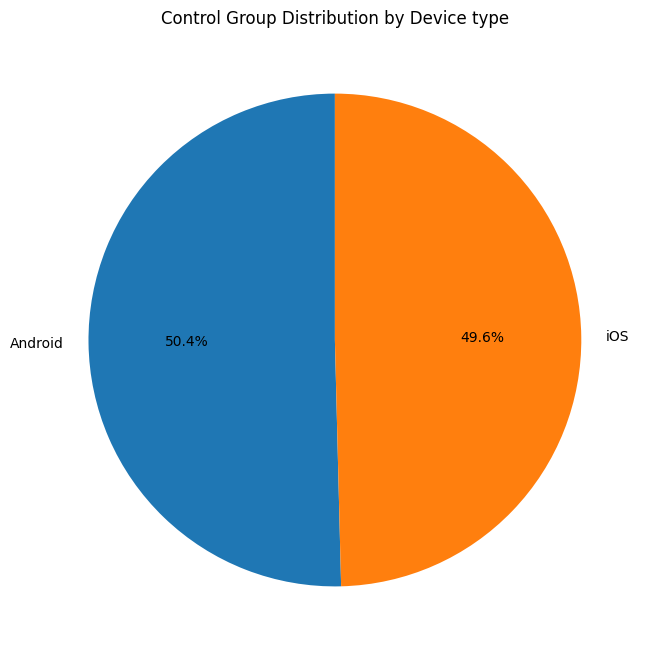

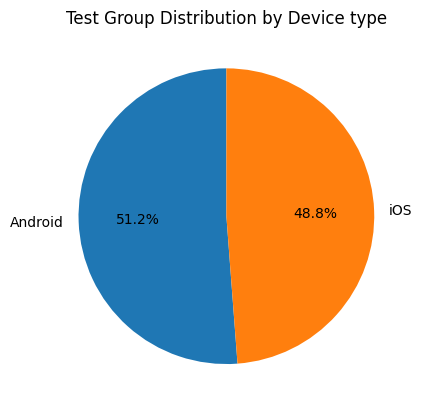

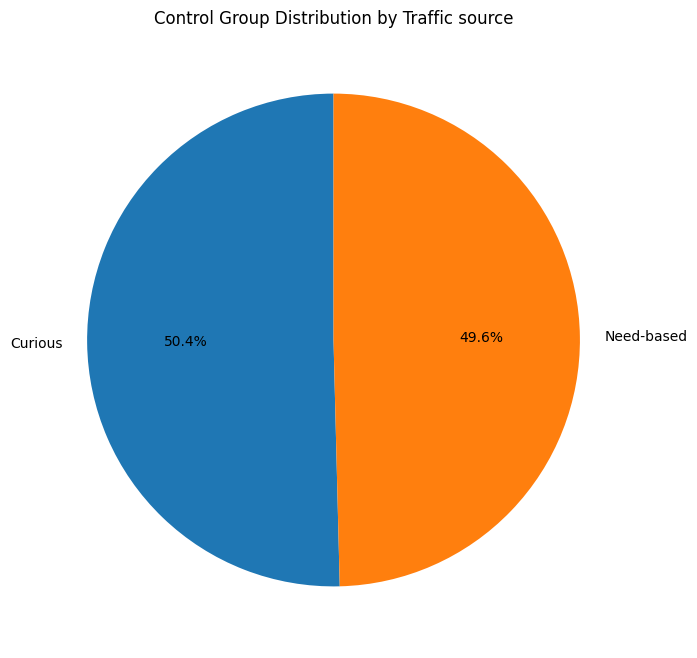

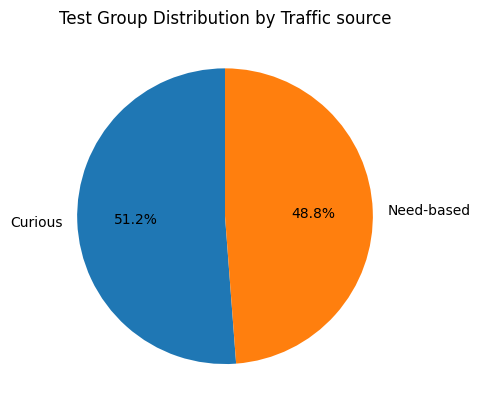

<Figure size 800x800 with 0 Axes>

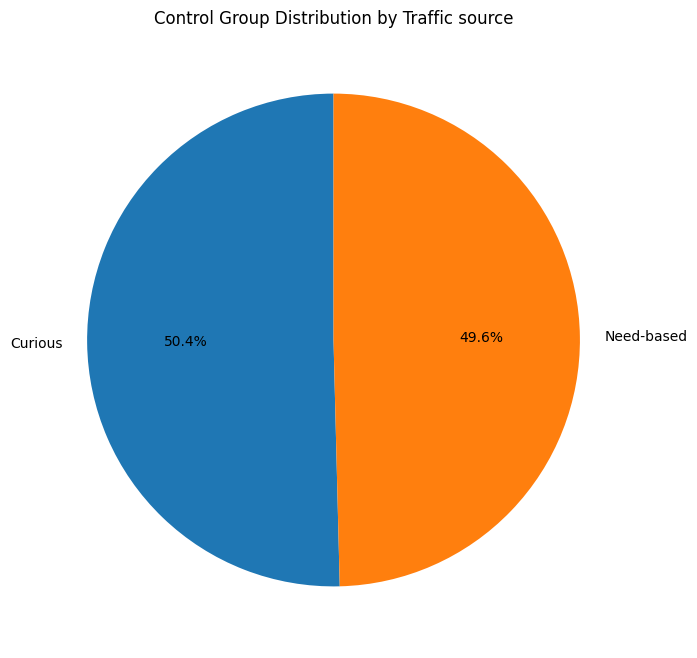

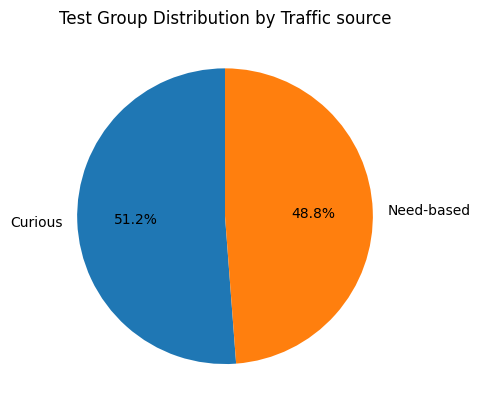

In [17]:

# Load the datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on 'patient_id' to get a combined view
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='inner')

# Add placeholder columns for 'device_type' and 'traffic_source' if these exist in the dataset
# If not, they can be added manually or from another dataset
if 'device_type' not in merged_data.columns:
    merged_data['device_type'] = merged_data['patient_id'].apply(lambda x: 'iOS' if x % 2 == 0 else 'Android')  # Example grouping logic
if 'traffic_source' not in merged_data.columns:
    merged_data['traffic_source'] = merged_data['patient_id'].apply(lambda x: 'Need-based' if x % 2 == 0 else 'Curious')  # Example grouping logic

# Create age groups
bins = [0, 18, 30, 45, 60, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '60+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Calculate the total count for Test and Control groups
total_counts = merged_data.groupby('group').size().reset_index(name='total_count')

# Parameters to visualize (adding ungrouped traffic source as a separate parameter)
parameters = ['gender', 'age_group', 'appointment_reason', 'device_type', 'traffic_source']

# Function to plot pie charts
def plot_pie_chart(group_share_percentage, parameter):
    plt.figure(figsize=(8, 8))
    for group in group_share_percentage['group'].unique():
        subset = group_share_percentage[group_share_percentage['group'] == group]
        plt.pie(subset['percentage'], labels=subset[parameter].astype(str), autopct='%1.1f%%', startangle=90)
        plt.title(f'{group} Group Distribution by {parameter.replace("_", " ").capitalize()}')
        plt.show()

# Group by 'group' and each parameter separately, calculate percentages, and plot the pie charts
for parameter in parameters:
    group_share = merged_data.groupby(['group', parameter]).size().reset_index(name='count')
    group_share_percentage = pd.merge(group_share, total_counts, on='group')
    group_share_percentage['percentage'] = (group_share_percentage['count'] / group_share_percentage['total_count']) * 100
    
    # Plot pie chart for each parameter
    plot_pie_chart(group_share_percentage, parameter)

# Ungrouped traffic source (without age grouping)
plt.figure(figsize=(8, 8))
group_share_ungrouped = merged_data.groupby(['group', 'traffic_source']).size().reset_index(name='count')
group_share_percentage_ungrouped = pd.merge(group_share_ungrouped, total_counts, on='group')
group_share_percentage_ungrouped['percentage'] = (group_share_percentage_ungrouped['count'] / group_share_percentage_ungrouped['total_count']) * 100

# Plot pie chart for ungrouped traffic source
plot_pie_chart(group_share_percentage_ungrouped, 'traffic_source')


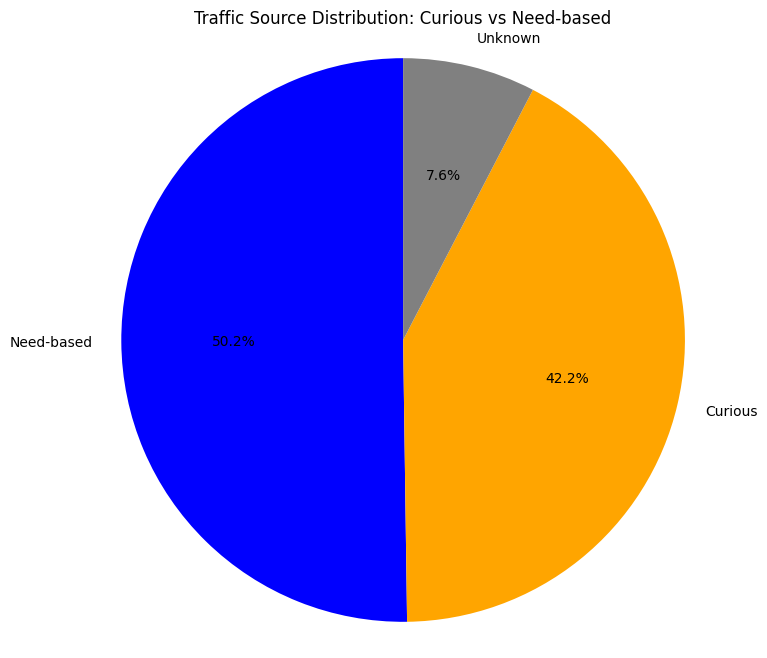

In [18]:
# Load the newly uploaded datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the app_data with ab_test_data to get traffic source information
merged_data_with_traffic = pd.merge(appointments_data, app_data, how='left', on='patient_id')

# Now, let's categorize the traffic sources into two groups:
# 1. Curious (Meta Ads, Google Ads, Organic Search)
# 2. Need-based (Referral, Direct)

curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

# Create a new column to categorize the traffic sources
merged_data_with_traffic['traffic_category'] = merged_data_with_traffic['traffic_source'].apply(
    lambda x: 'Curious' if x in curious_sources else 'Need-based' if x in need_sources else 'Unknown'
)

# Let's calculate the distribution of traffic categories (Curious vs Need-based)
traffic_distribution = merged_data_with_traffic['traffic_category'].value_counts()

# Plot a pie chart for the traffic distribution
labels = traffic_distribution.index
sizes = traffic_distribution.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'gray'])
plt.title('Traffic Source Distribution: Curious vs Need-based')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


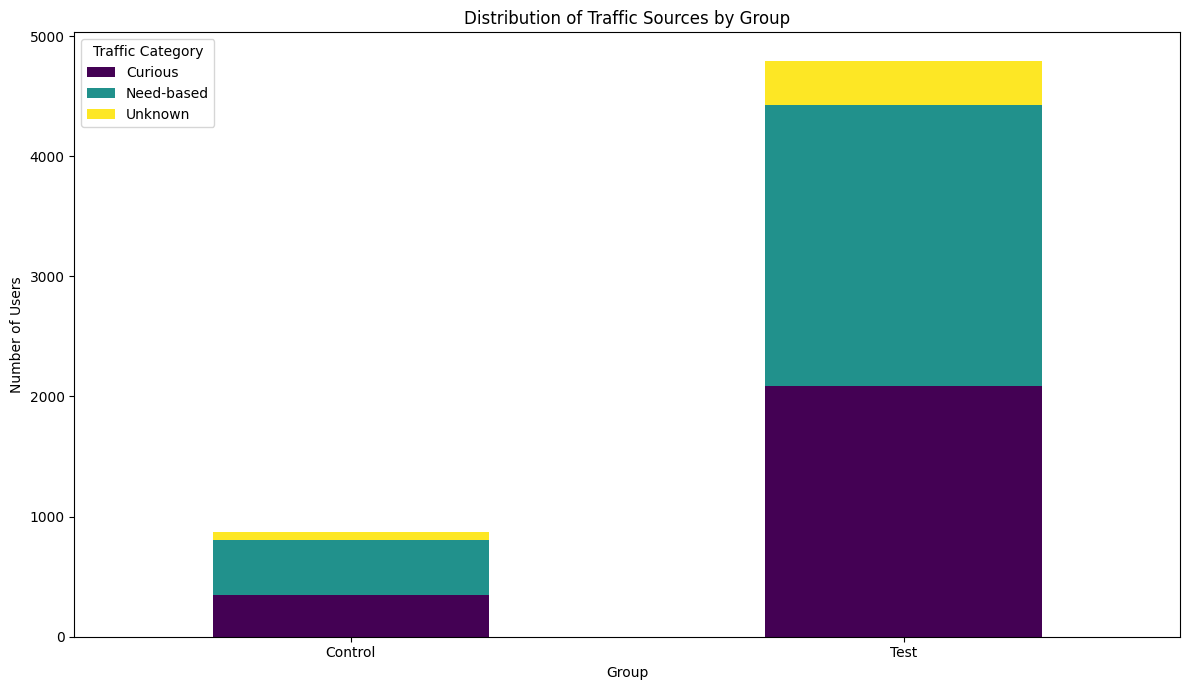

In [19]:

ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets on 'patient_id'
merged_data = pd.merge(ab_test_data, app_data, how='left', on='patient_id')

# Categorize traffic sources into three groups:
# 1. Curious (Meta Ads, Google Ads, Organic Search)
# 2. Need-based (Referral, Direct)
# 3. Unknown (if there are any entries without a defined source)
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

# Create a new column to categorize the traffic sources
merged_data['traffic_category'] = merged_data['traffic_source'].apply(
    lambda x: 'Curious' if x in curious_sources else 'Need-based' if x in need_sources else 'Unknown'
)

# Group by Control/Test group and traffic category
group_traffic_distribution = merged_data.groupby(['group', 'traffic_category']).size().unstack(fill_value=0)

# Plotting the results
group_traffic_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')

# Adding title and labels
plt.title('Distribution of Traffic Sources by Group')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.legend(title='Traffic Category')
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()


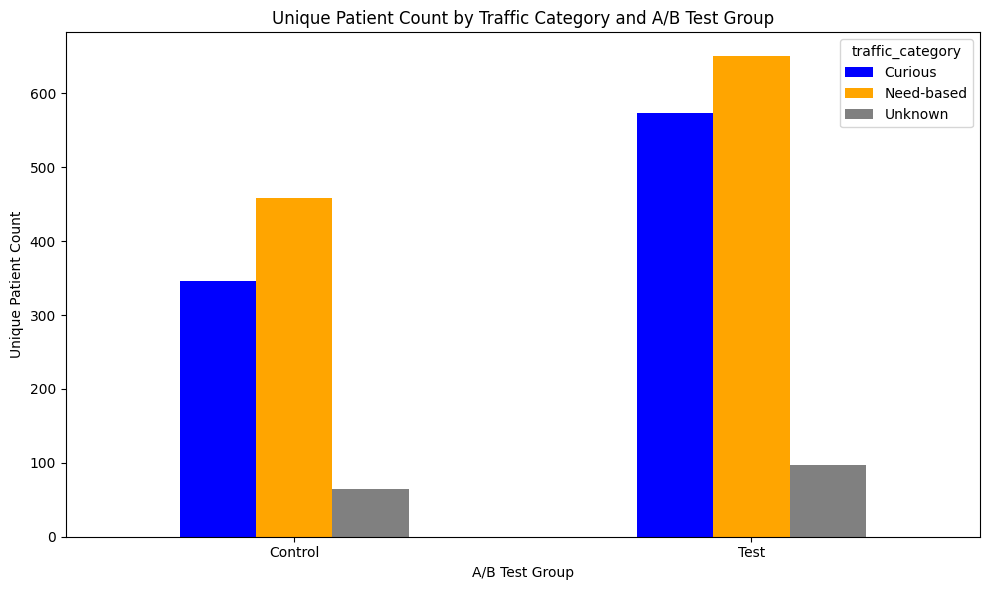

In [20]:

# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merge the datasets: appointments, app, and A/B test data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')
merged_data = pd.merge(merged_data, ab_test_data, how='left', on='patient_id')

# Categorize traffic sources into two groups: Curious and Need-based
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Create a new column to categorize the traffic sources
merged_data['traffic_category'] = merged_data['traffic_source'].apply(categorize_traffic)

# Calculate count of unique patients by traffic category and A/B test group
unique_patient_count_traffic = merged_data.groupby(['group', 'traffic_category'])['patient_id'].nunique().unstack()

# Plotting unique patient count for traffic categories
plt.figure(figsize=(10, 6))
unique_patient_count_traffic.plot(kind='bar', stacked=False, color=['blue', 'orange', 'gray'], ax=plt.gca())
plt.title('Unique Patient Count by Traffic Category and A/B Test Group')
plt.xlabel('A/B Test Group')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3771270371.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group_data['traffic_category'] = test_group_data['traffic_source'].apply(categorize_traffic)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3771270371.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group_data['age_group'] = test_group_data['age'].apply(categorize_age)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3771270371.py:56: 

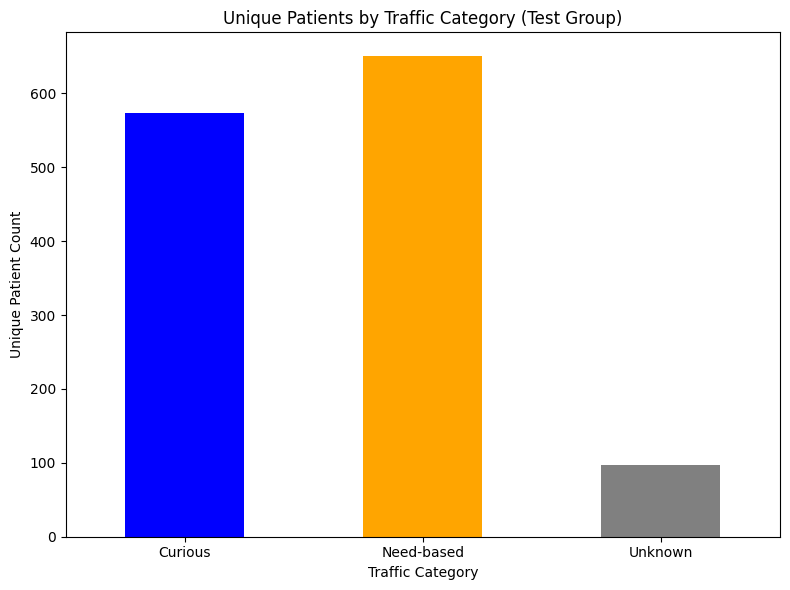

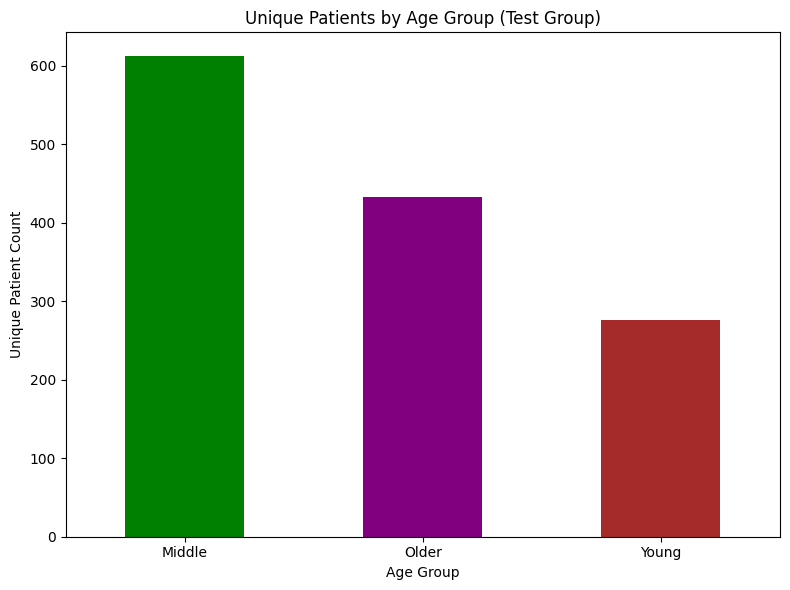

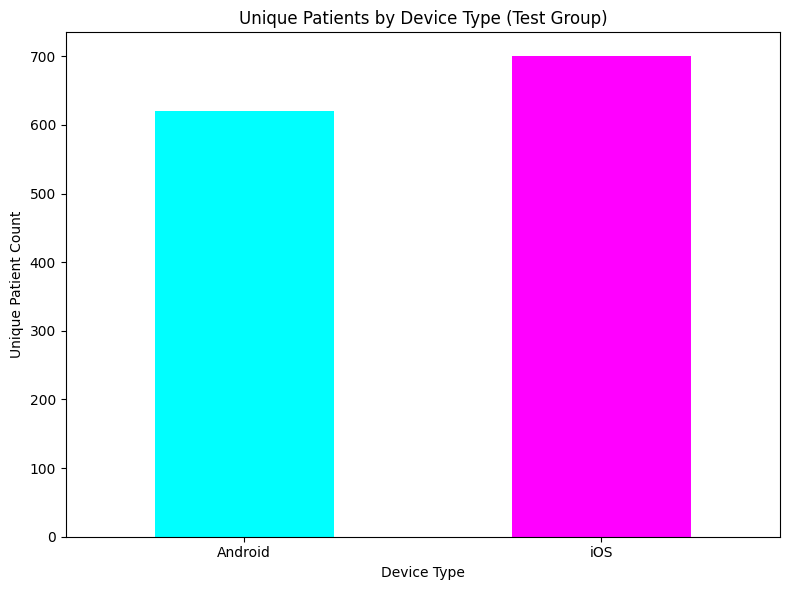

In [21]:

# Load the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')  # Load the app data that contains traffic_source

# Perform a left join on 'patient_id' to merge appointments data with A/B test data
merged_data = pd.merge(appointments_data, ab_test_data, how='left', on='patient_id')
merged_data = pd.merge(merged_data, app_data, how='left', on='patient_id')  # Merge app_data for traffic source

# Filter for the Test group only
test_group_data = merged_data[merged_data['group'] == 'Test']

# Categorize traffic sources into Need-based and Curious
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Apply traffic source categorization
test_group_data['traffic_category'] = test_group_data['traffic_source'].apply(categorize_traffic)

# Define age groups: Young (0-30), Middle (31-60), Older (61+)
def categorize_age(age):
    if age <= 30:
        return 'Young'
    elif 31 <= age <= 60:
        return 'Middle'
    else:
        return 'Older'

# Apply the age group categorization
test_group_data['age_group'] = test_group_data['age'].apply(categorize_age)

# Categorize devices into iOS, Android, Other
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Apply device categorization
test_group_data['device_type'] = test_group_data['device'].apply(categorize_device)

# Calculate unique patient counts for traffic category, age group, and device type
unique_patients_traffic = test_group_data.groupby('traffic_category')['patient_id'].nunique()
unique_patients_age = test_group_data.groupby('age_group')['patient_id'].nunique()
unique_patients_device = test_group_data.groupby('device_type')['patient_id'].nunique()

# Plotting unique patient counts by Traffic Category
plt.figure(figsize=(8, 6))
unique_patients_traffic.plot(kind='bar', color=['blue', 'orange', 'gray'])
plt.title('Unique Patients by Traffic Category (Test Group)')
plt.xlabel('Traffic Category')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting unique patient counts by Age Group
plt.figure(figsize=(8, 6))
unique_patients_age.plot(kind='bar', color=['green', 'purple', 'brown'])
plt.title('Unique Patients by Age Group (Test Group)')
plt.xlabel('Age Group')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting unique patient counts by Device Type
plt.figure(figsize=(8, 6))
unique_patients_device.plot(kind='bar', color=['cyan', 'magenta', 'yellow', 'gray'])
plt.title('Unique Patients by Device Type (Test Group)')
plt.xlabel('Device Type')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2890174483.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group_data['traffic_category'] = control_group_data['traffic_source'].apply(categorize_traffic)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2890174483.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group_data['age_group'] = control_group_data['age'].apply(categorize_age)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/289017

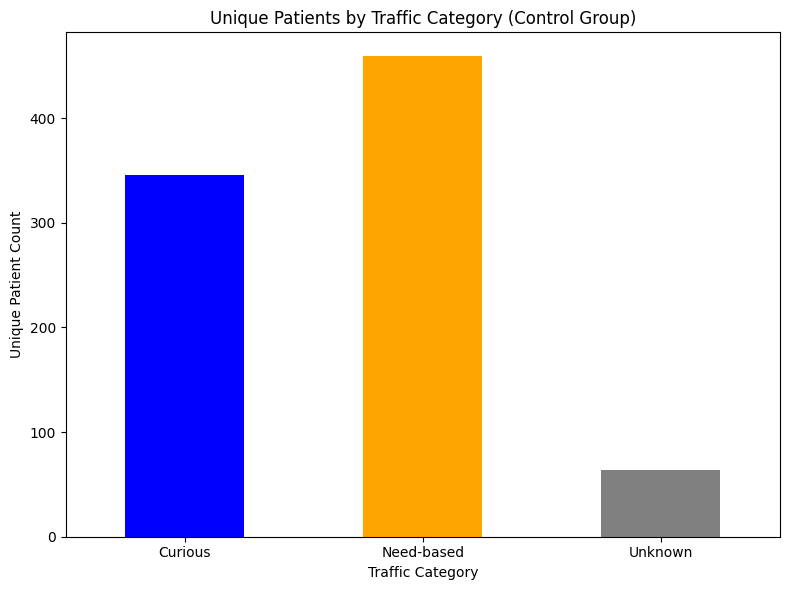

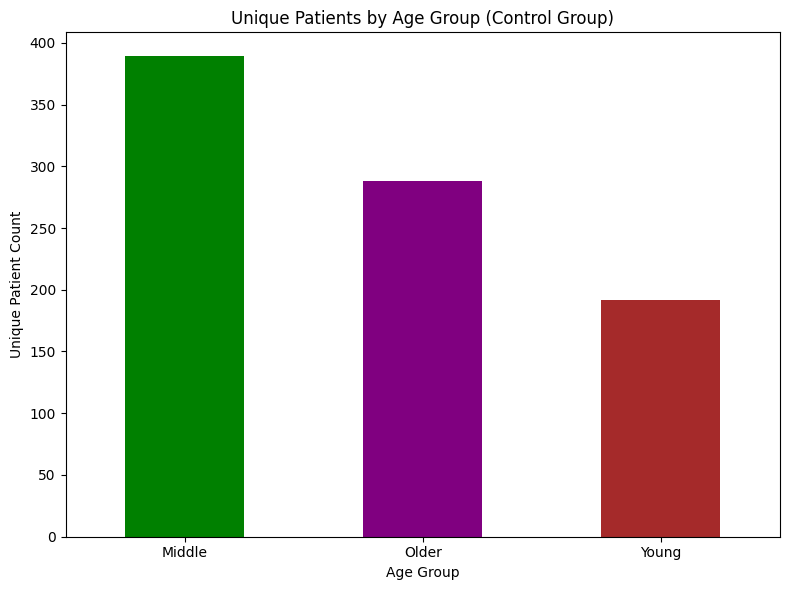

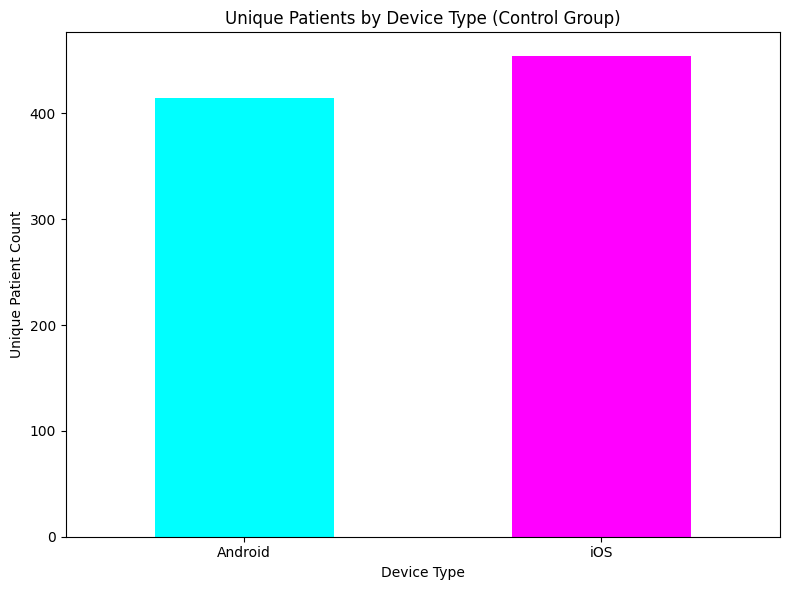

Unique Patients by Traffic Category (Control Group):
traffic_category
Curious       346
Need-based    459
Unknown        64
Name: patient_id, dtype: int64

Unique Patients by Age Group (Control Group):
age_group
Middle    389
Older     288
Young     192
Name: patient_id, dtype: int64

Unique Patients by Device Type (Control Group):
device_type
Android    415
iOS        454
Name: patient_id, dtype: int64


In [22]:

# Load the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')  # Load the app data that contains traffic_source

# Perform a left join on 'patient_id' to merge appointments data with A/B test data
merged_data = pd.merge(appointments_data, ab_test_data, how='left', on='patient_id')
merged_data = pd.merge(merged_data, app_data, how='left', on='patient_id')  # Merge app_data for traffic source

# Filter for the Control group only
control_group_data = merged_data[merged_data['group'] == 'Control']

# Categorize traffic sources into Need-based and Curious
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Apply traffic source categorization
control_group_data['traffic_category'] = control_group_data['traffic_source'].apply(categorize_traffic)

# Define age groups: Young (0-30), Middle (31-60), Older (61+)
def categorize_age(age):
    if age <= 30:
        return 'Young'
    elif 31 <= age <= 60:
        return 'Middle'
    else:
        return 'Older'

# Apply the age group categorization
control_group_data['age_group'] = control_group_data['age'].apply(categorize_age)

# Categorize devices into iOS, Android, Other
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Apply device categorization
control_group_data['device_type'] = control_group_data['device'].apply(categorize_device)

# Calculate unique patient counts for traffic category, age group, and device type
unique_patients_traffic = control_group_data.groupby('traffic_category')['patient_id'].nunique()
unique_patients_age = control_group_data.groupby('age_group')['patient_id'].nunique()
unique_patients_device = control_group_data.groupby('device_type')['patient_id'].nunique()

# Plotting unique patient counts by Traffic Category
plt.figure(figsize=(8, 6))
unique_patients_traffic.plot(kind='bar', color=['blue', 'orange', 'gray'])
plt.title('Unique Patients by Traffic Category (Control Group)')
plt.xlabel('Traffic Category')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting unique patient counts by Age Group
plt.figure(figsize=(8, 6))
unique_patients_age.plot(kind='bar', color=['green', 'purple', 'brown'])
plt.title('Unique Patients by Age Group (Control Group)')
plt.xlabel('Age Group')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting unique patient counts by Device Type
plt.figure(figsize=(8, 6))
unique_patients_device.plot(kind='bar', color=['cyan', 'magenta', 'yellow', 'gray'])
plt.title('Unique Patients by Device Type (Control Group)')
plt.xlabel('Device Type')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Output the unique counts for further analysis
print("Unique Patients by Traffic Category (Control Group):")
print(unique_patients_traffic)

print("\nUnique Patients by Age Group (Control Group):")
print(unique_patients_age)

print("\nUnique Patients by Device Type (Control Group):")
print(unique_patients_device)


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2044288990.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group_data['traffic_category'] = test_group_data['traffic_source'].apply(categorize_traffic)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2044288990.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group_data['traffic_category'] = control_group_data['traffic_source'].apply(categorize_traffic)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipyke

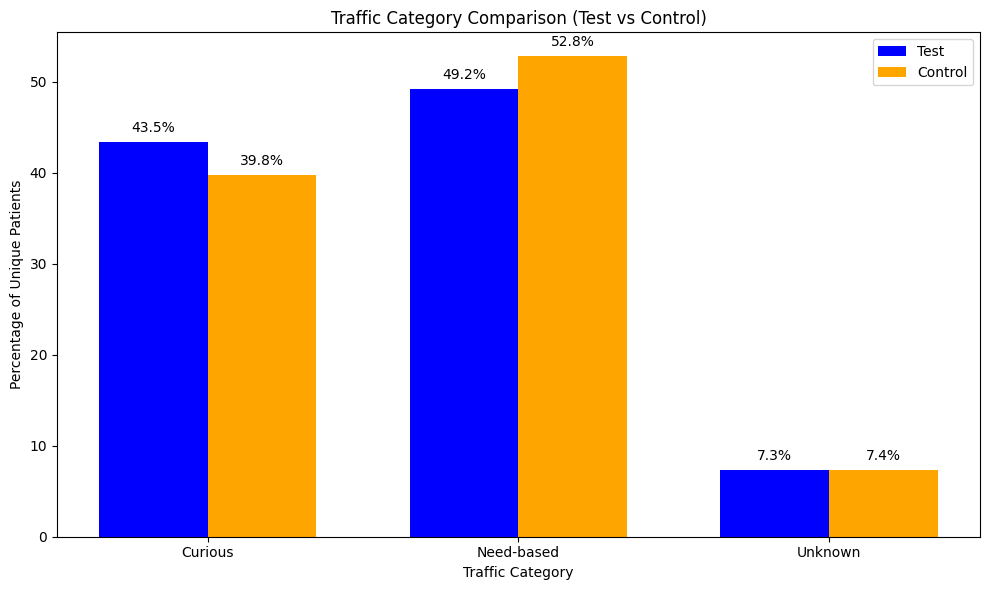

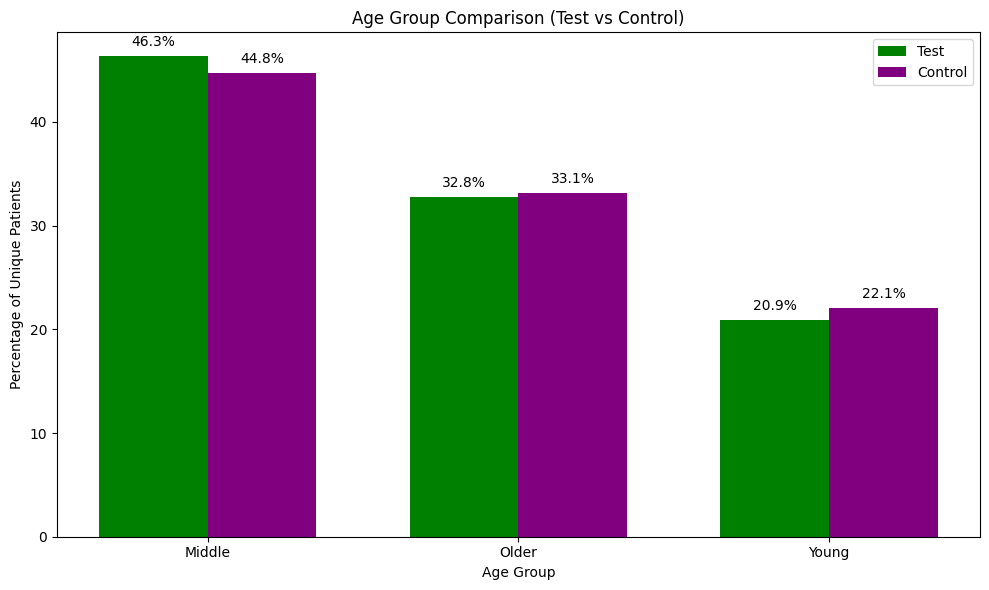

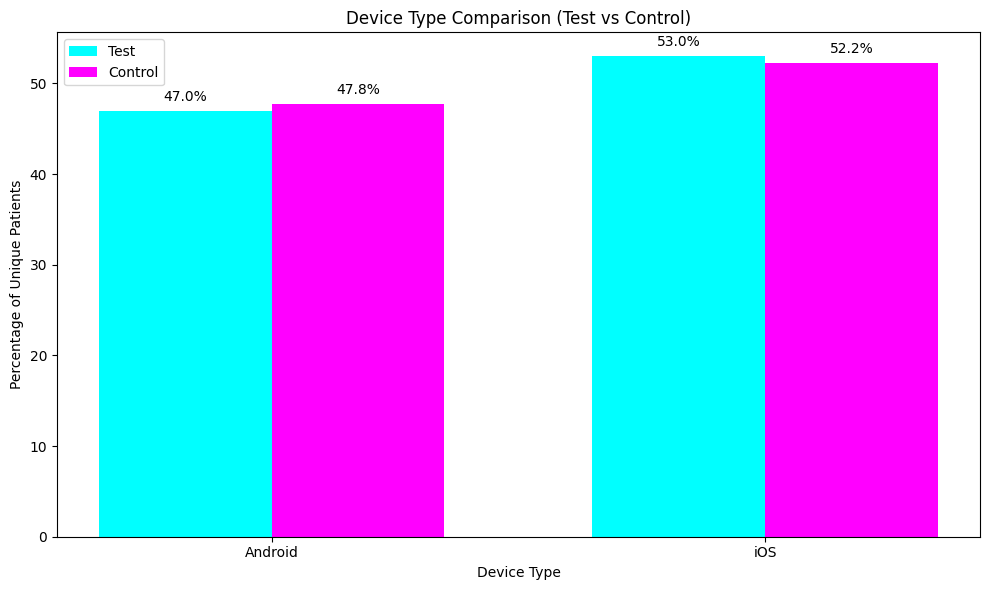

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')  # Load the app data that contains traffic_source

# Perform a left join on 'patient_id' to merge appointments data with A/B test data
merged_data = pd.merge(appointments_data, ab_test_data, how='left', on='patient_id')
merged_data = pd.merge(merged_data, app_data, how='left', on='patient_id')  # Merge app_data for traffic source

# Filter for Test and Control groups
test_group_data = merged_data[merged_data['group'] == 'Test']
control_group_data = merged_data[merged_data['group'] == 'Control']

# Categorize traffic sources into Need-based and Curious
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Apply traffic source categorization to both groups
test_group_data['traffic_category'] = test_group_data['traffic_source'].apply(categorize_traffic)
control_group_data['traffic_category'] = control_group_data['traffic_source'].apply(categorize_traffic)

# Define age groups: Young (0-30), Middle (31-60), Older (61+)
def categorize_age(age):
    if age <= 30:
        return 'Young'
    elif 31 <= age <= 60:
        return 'Middle'
    else:
        return 'Older'

# Apply the age group categorization to both groups
test_group_data['age_group'] = test_group_data['age'].apply(categorize_age)
control_group_data['age_group'] = control_group_data['age'].apply(categorize_age)

# Categorize devices into iOS, Android, Other
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Apply device categorization to both groups
test_group_data['device_type'] = test_group_data['device'].apply(categorize_device)
control_group_data['device_type'] = control_group_data['device'].apply(categorize_device)

# Calculate unique patient counts for each category in both Test and Control groups
unique_patients_test_traffic = test_group_data.groupby('traffic_category')['patient_id'].nunique()
unique_patients_control_traffic = control_group_data.groupby('traffic_category')['patient_id'].nunique()

unique_patients_test_age = test_group_data.groupby('age_group')['patient_id'].nunique()
unique_patients_control_age = control_group_data.groupby('age_group')['patient_id'].nunique()

unique_patients_test_device = test_group_data.groupby('device_type')['patient_id'].nunique()
unique_patients_control_device = control_group_data.groupby('device_type')['patient_id'].nunique()

# Calculate total unique patients in Test and Control groups
total_test_patients = test_group_data['patient_id'].nunique()
total_control_patients = control_group_data['patient_id'].nunique()

# Calculate percentages for each category
test_traffic_percent = (unique_patients_test_traffic / total_test_patients) * 100
control_traffic_percent = (unique_patients_control_traffic / total_control_patients) * 100

test_age_percent = (unique_patients_test_age / total_test_patients) * 100
control_age_percent = (unique_patients_control_age / total_control_patients) * 100

test_device_percent = (unique_patients_test_device / total_test_patients) * 100
control_device_percent = (unique_patients_control_device / total_control_patients) * 100

# Function to add percentage labels on bars
def add_labels(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Plot side-by-side bar charts with percentage labels for comparison

# Traffic Category
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(test_traffic_percent))
width = 0.35  # Bar width

rects1 = ax.bar(index - width/2, test_traffic_percent, width, label='Test', color='blue')
rects2 = ax.bar(index + width/2, control_traffic_percent, width, label='Control', color='orange')

# Add percentage labels
add_labels(rects1, ax)
add_labels(rects2, ax)

ax.set_xticks(index)
ax.set_xticklabels(test_traffic_percent.index)
ax.set_xlabel('Traffic Category')
ax.set_ylabel('Percentage of Unique Patients')
ax.set_title('Traffic Category Comparison (Test vs Control)')
ax.legend()

plt.tight_layout()
plt.show()

# Age Group
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(test_age_percent))

rects1 = ax.bar(index - width/2, test_age_percent, width, label='Test', color='green')
rects2 = ax.bar(index + width/2, control_age_percent, width, label='Control', color='purple')

# Add percentage labels
add_labels(rects1, ax)
add_labels(rects2, ax)

ax.set_xticks(index)
ax.set_xticklabels(test_age_percent.index)
ax.set_xlabel('Age Group')
ax.set_ylabel('Percentage of Unique Patients')
ax.set_title('Age Group Comparison (Test vs Control)')
ax.legend()

plt.tight_layout()
plt.show()

# Device Type
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(test_device_percent))

rects1 = ax.bar(index - width/2, test_device_percent, width, label='Test', color='cyan')
rects2 = ax.bar(index + width/2, control_device_percent, width, label='Control', color='magenta')

# Add percentage labels
add_labels(rects1, ax)
add_labels(rects2, ax)

ax.set_xticks(index)
ax.set_xticklabels(test_device_percent.index)
ax.set_xlabel('Device Type')
ax.set_ylabel('Percentage of Unique Patients')
ax.set_title('Device Type Comparison (Test vs Control)')
ax.legend()

plt.tight_layout()
plt.show()


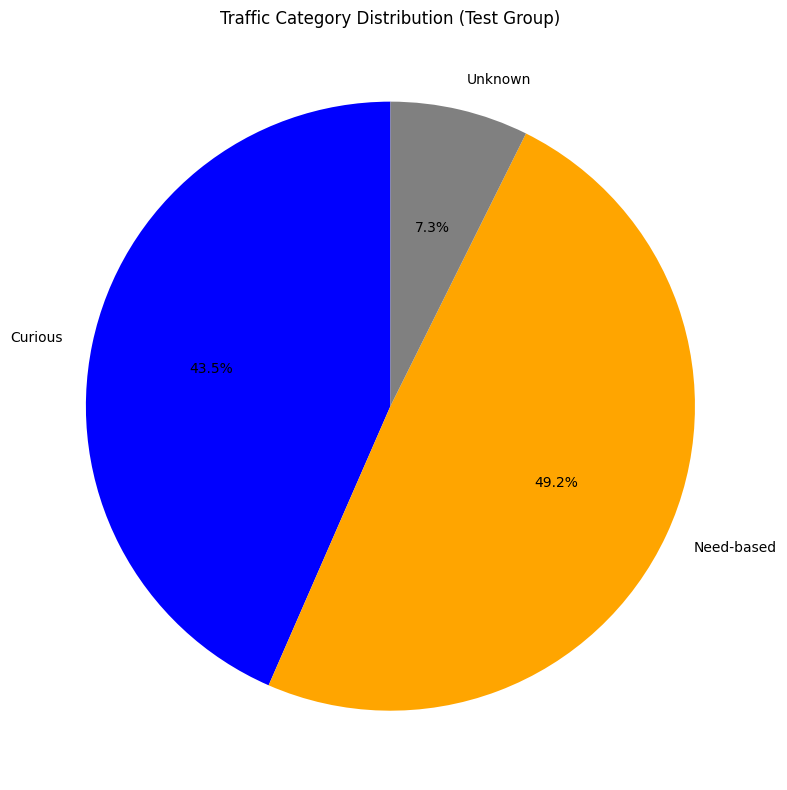

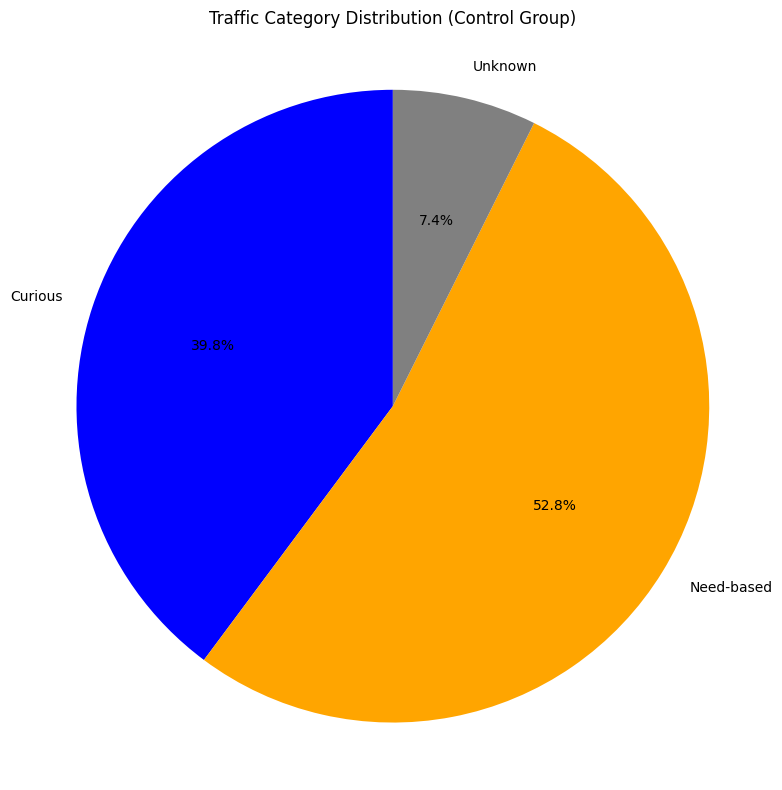

In [24]:

# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merge the datasets: appointments, app, and A/B test data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')
merged_data = pd.merge(merged_data, ab_test_data, how='left', on='patient_id')

# Categorize traffic sources into two groups: Curious and Need-based
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Create a new column to categorize the traffic sources
merged_data['traffic_category'] = merged_data['traffic_source'].apply(categorize_traffic)

# Filter the data for Test and Control groups
test_group_data = merged_data[merged_data['group'] == 'Test']
control_group_data = merged_data[merged_data['group'] == 'Control']

# Calculate the unique patient count by traffic category for both groups
test_unique_traffic = test_group_data.groupby('traffic_category')['patient_id'].nunique()
control_unique_traffic = control_group_data.groupby('traffic_category')['patient_id'].nunique()

# Plotting the pie chart for the Test group
plt.figure(figsize=(8, 8))
plt.pie(test_unique_traffic, labels=test_unique_traffic.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'gray'])
plt.title('Traffic Category Distribution (Test Group)')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()

# Plotting the pie chart for the Control group
plt.figure(figsize=(8, 8))
plt.pie(control_unique_traffic, labels=control_unique_traffic.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'gray'])
plt.title('Traffic Category Distribution (Control Group)')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()


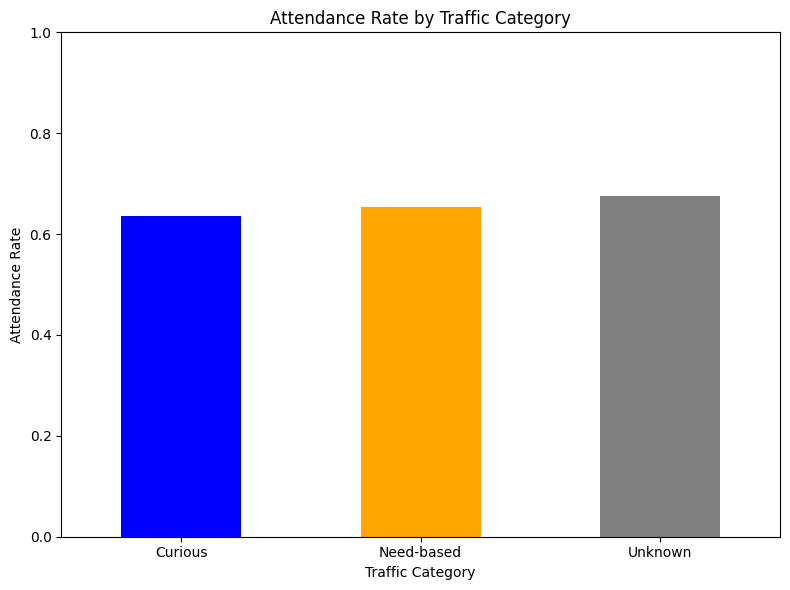

In [25]:

# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the app data with the appointment data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')

# Categorize traffic sources into three groups
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Create a new column to categorize the traffic sources
merged_data['traffic_category'] = merged_data['traffic_source'].apply(categorize_traffic)

# Calculate attendance rate (attended/total) for each traffic category
attendance_summary = merged_data.groupby('traffic_category')['appointment_status'].apply(lambda x: (x == 'Attended').mean())

# Plotting the results
plt.figure(figsize=(8, 6))
attendance_summary.plot(kind='bar', color=['blue', 'orange', 'gray'])

# Adding title and labels
plt.title('Attendance Rate by Traffic Category')
plt.xlabel('Traffic Category')
plt.ylabel('Attendance Rate')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()


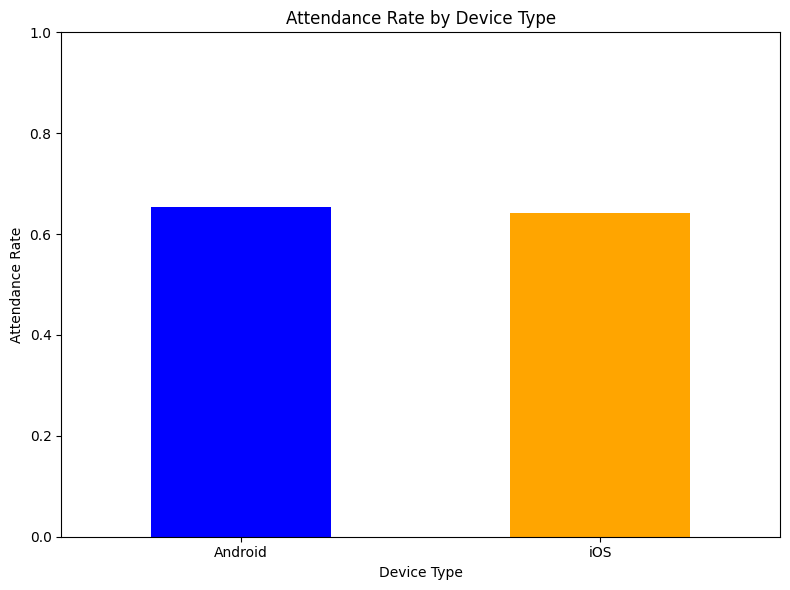

In [26]:

# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the app data with the appointment data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')

# Standardize device names into broader categories
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()  # Convert to lowercase for uniformity
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Create a new column to categorize the devices
merged_data['device_type'] = merged_data['device'].apply(categorize_device)

# Calculate attendance rate (attended/total) for each device type
attendance_summary = merged_data.groupby('device_type')['appointment_status'].apply(lambda x: (x == 'Attended').mean())

# Plotting the results
plt.figure(figsize=(8, 6))
attendance_summary.plot(kind='bar', color=['blue', 'orange', 'gray'])

# Adding title and labels
plt.title('Attendance Rate by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Attendance Rate')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()


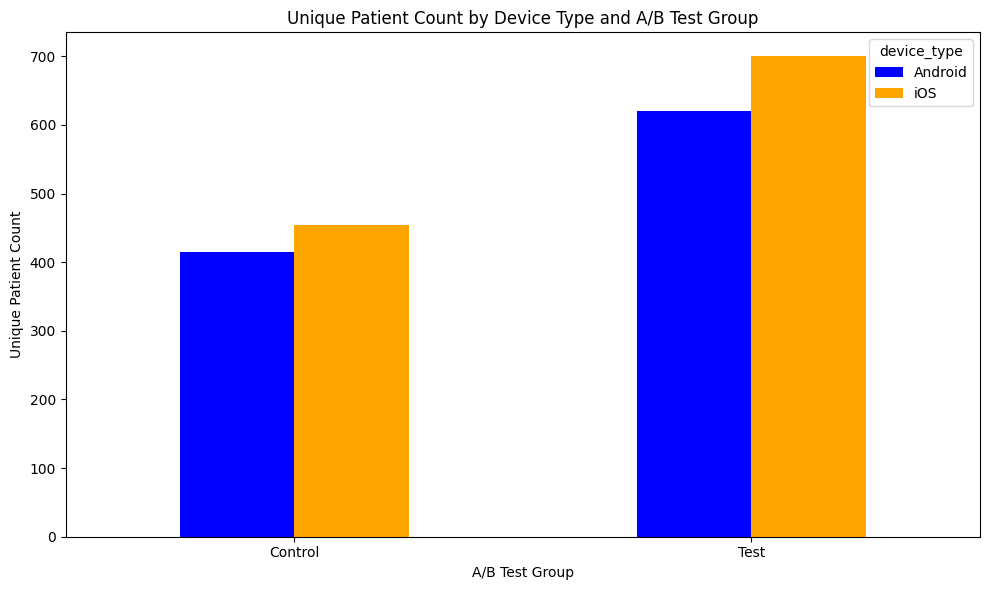

In [27]:

# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Merge the datasets: appointments, app, and A/B test data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')
merged_data = pd.merge(merged_data, ab_test_data, how='left', on='patient_id')

# Standardize device names into broader categories
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()  # Convert to lowercase for uniformity
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Create a new column to categorize the devices
merged_data['device_type'] = merged_data['device'].apply(categorize_device)

# Calculate attendance rate (attended/total) for each device type and A/B test group
attendance_rate = merged_data.groupby(['group', 'device_type'])['appointment_status'].apply(lambda x: (x == 'Attended').mean()).unstack()

# Calculate count of unique patients by device type and A/B test group
unique_patient_count = merged_data.groupby(['group', 'device_type'])['patient_id'].nunique().unstack()

# # Plotting attendance rate
# plt.figure(figsize=(10, 6))
# attendance_rate.plot(kind='bar', stacked=False, color=['blue', 'orange', 'gray'], ax=plt.gca())
# plt.title('Attendance Rate by Device Type and A/B Test Group')
# plt.xlabel('A/B Test Group')
# plt.ylabel('Attendance Rate')
# plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()

# Plotting unique patient count
plt.figure(figsize=(10, 6))
unique_patient_count.plot(kind='bar', stacked=False, color=['blue', 'orange', 'gray'], ax=plt.gca())
plt.title('Unique Patient Count by Device Type and A/B Test Group')
plt.xlabel('A/B Test Group')
plt.ylabel('Unique Patient Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1200x700 with 0 Axes>

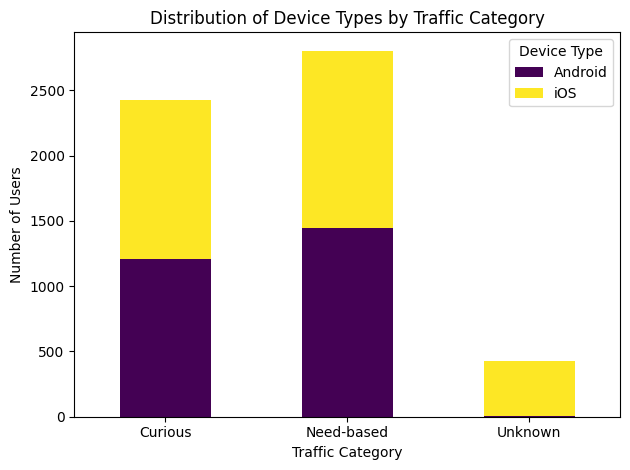

In [28]:

# Load the datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets on 'patient_id'
merged_data = pd.merge(ab_test_data, app_data, how='left', on='patient_id')

# Standardize device names into broader categories
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()  # Convert to lowercase for uniformity
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Create a new column to categorize the devices
merged_data['device_type'] = merged_data['device'].apply(categorize_device)

# Categorize traffic sources into three groups
curious_sources = ['Meta Ads', 'Google Ads', 'Organic Search']
need_sources = ['Referral', 'Direct']

def categorize_traffic(source):
    if pd.isna(source):
        return 'Unknown'
    source = source.lower()  # Convert to lowercase for uniformity
    if source in map(str.lower, curious_sources):
        return 'Curious'
    elif source in map(str.lower, need_sources):
        return 'Need-based'
    else:
        return 'Unknown'

# Create a new column to categorize the traffic sources
merged_data['traffic_category'] = merged_data['traffic_source'].apply(categorize_traffic)

# Group by traffic category and device type
category_device_distribution = merged_data.groupby(['traffic_category', 'device_type']).size().unstack(fill_value=0)

# Plotting the results
plt.figure(figsize=(12, 7))
category_device_distribution.plot(kind='bar', stacked=True, colormap='viridis')

# Adding title and labels
plt.title('Distribution of Device Types by Traffic Category')
plt.xlabel('Traffic Category')
plt.ylabel('Number of Users')
plt.legend(title='Device Type')
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()


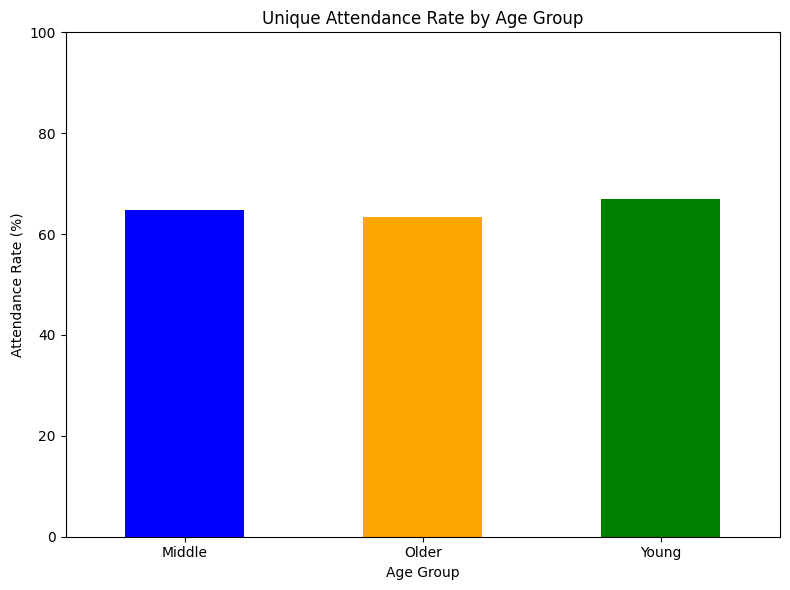

age_group
Middle    64.827018
Older     63.299663
Young     67.015707
Name: patient_id, dtype: float64


In [29]:
# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets: appointments and app data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')

# Define age groups: Young (0-30), Middle (31-60), Older (61+)
def categorize_age(age):
    if age <= 30:
        return 'Young'
    elif 31 <= age <= 60:
        return 'Middle'
    else:
        return 'Older'

# Apply the age group categorization
merged_data['age_group'] = merged_data['age'].apply(categorize_age)

# Calculate unique count of attended patients for each age group
unique_attendance_counts_age = merged_data[merged_data['appointment_status'] == 'Attended'].groupby('age_group')['patient_id'].nunique()

# Calculate total unique patients for each age group
total_unique_counts_age = merged_data.groupby('age_group')['patient_id'].nunique()

# Calculate unique attendance rate as a percentage for each age group
unique_attendance_rate_age = (unique_attendance_counts_age / total_unique_counts_age) * 100

# Plotting the unique attendance rate by age group in a bar chart
plt.figure(figsize=(8, 6))
unique_attendance_rate_age.plot(kind='bar', color=['blue', 'orange', 'green'])

# Adding title and labels
plt.title('Unique Attendance Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Attendance Rate (%)')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100 for percentage
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

# Print unique attendance rate percentages for each age group
print(unique_attendance_rate_age)


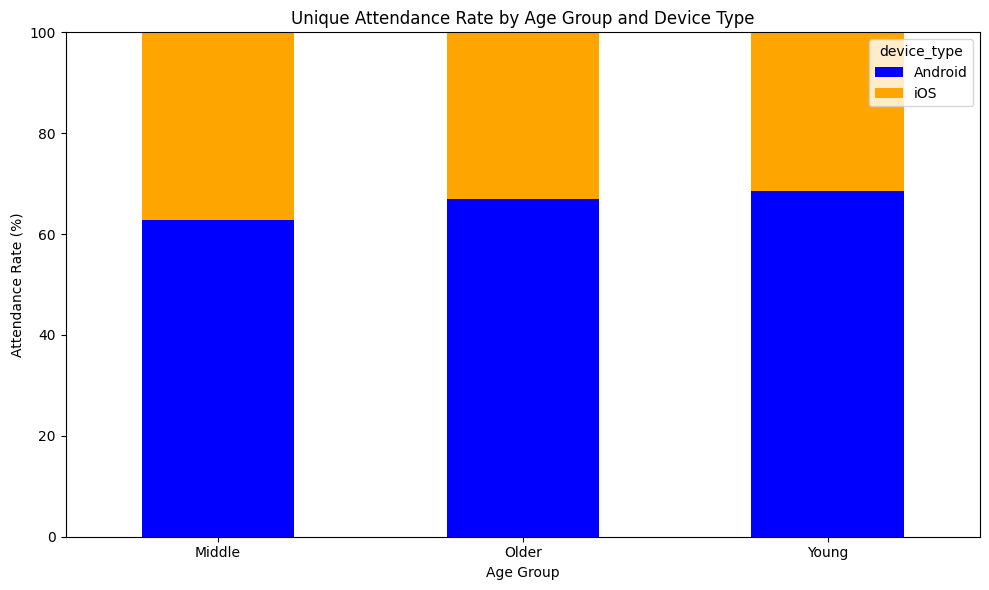

age_group  device_type
Middle     Android        62.807018
           iOS            66.614907
Older      Android        66.915423
           iOS            60.327198
Young      Android        68.571429
           iOS            65.529010
Name: patient_id, dtype: float64


In [30]:

# Load the datasets from the 'data/' directory
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets: appointments and app data on 'patient_id'
merged_data = pd.merge(appointments_data, app_data, how='left', on='patient_id')

# Define age groups: Young (0-30), Middle (31-60), Older (61+)
def categorize_age(age):
    if age <= 30:
        return 'Young'
    elif 31 <= age <= 60:
        return 'Middle'
    else:
        return 'Older'

# Apply the age group categorization
merged_data['age_group'] = merged_data['age'].apply(categorize_age)

# Standardize device names into broader categories (iOS, Android, Other)
def categorize_device(device_name):
    if pd.isna(device_name):
        return 'Unknown'
    device_name = device_name.lower()
    if 'ios' in device_name:
        return 'iOS'
    elif 'android' in device_name:
        return 'Android'
    else:
        return 'Other'

# Apply the device categorization
merged_data['device_type'] = merged_data['device'].apply(categorize_device)

# Calculate unique count of attended patients for each age group and device type
unique_attendance_counts = merged_data[merged_data['appointment_status'] == 'Attended'].groupby(['age_group', 'device_type'])['patient_id'].nunique()

# Calculate total unique patients for each age group and device type
total_unique_counts = merged_data.groupby(['age_group', 'device_type'])['patient_id'].nunique()

# Calculate unique attendance rate as a percentage for each age group and device type
unique_attendance_rate = (unique_attendance_counts / total_unique_counts) * 100

# Plotting the unique attendance rate by age group and device type in a bar chart
plt.figure(figsize=(10, 6))
unique_attendance_rate.unstack().plot(kind='bar', stacked=True, color=['blue', 'orange', 'green', 'gray'], ax=plt.gca())

# Adding title and labels
plt.title('Unique Attendance Rate by Age Group and Device Type')
plt.xlabel('Age Group')
plt.ylabel('Attendance Rate (%)')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100 for percentage
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

# Print unique attendance rate percentages for each age group and device type
print(unique_attendance_rate)


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2686152862.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group_attendance['event_datetime'] = pd.to_datetime(control_group_attendance['event_datetime'])
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2686152862.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group_attendance['event_datetime'] = pd.to_datetime(test_group_attendance['event_datetime'])
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipyke

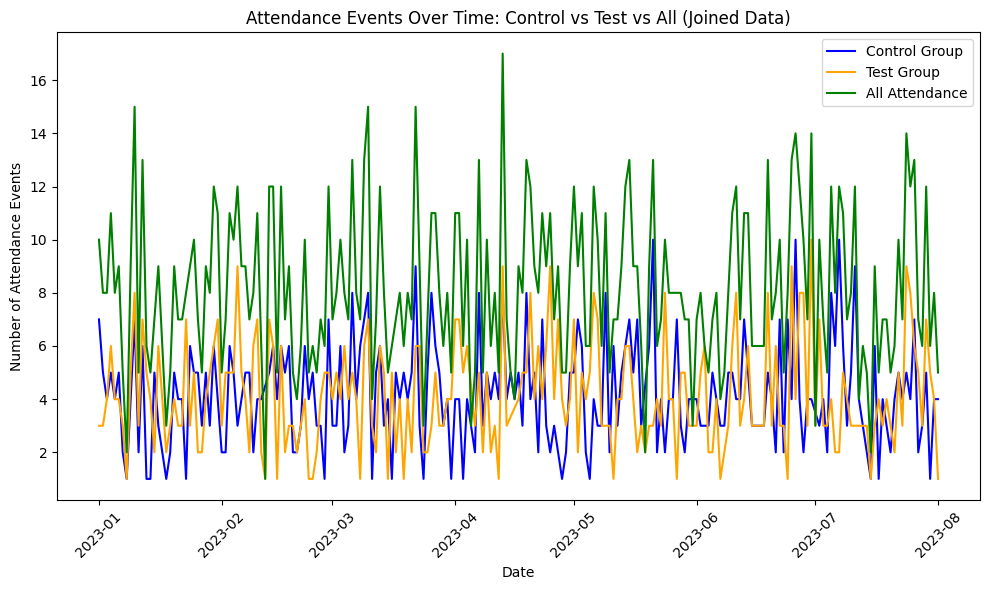

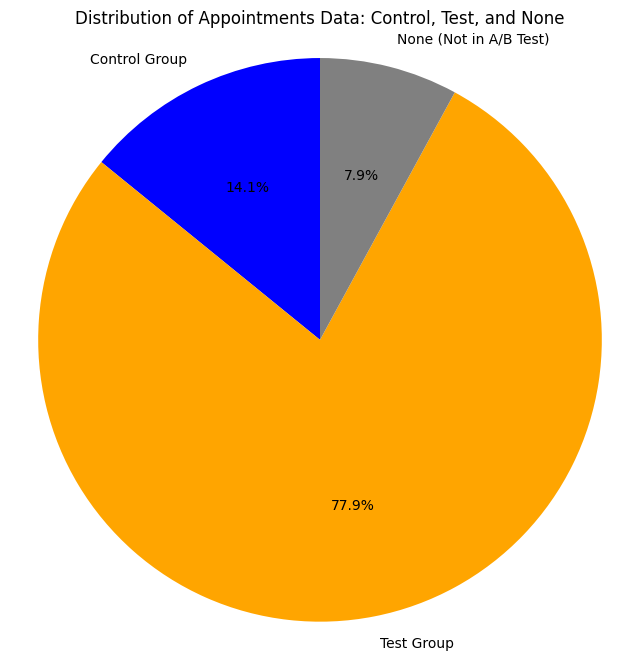

In [31]:
# Load the newly uploaded datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Perform a left join between appointments_data and ab_test_data on 'patient_id'
merged_data = pd.merge(appointments_data, ab_test_data, how='left', on='patient_id')

# Filter for attended appointments in the merged data
attendance_events = merged_data[merged_data['event_name'] == 'attended_appointment']

# Separate into Control and Test groups
control_group_attendance = attendance_events[attendance_events['group'] == 'Control']
test_group_attendance = attendance_events[attendance_events['group'] == 'Test']
all_attendance = attendance_events  # This is without filtering for any group

# Convert 'event_datetime' to datetime for proper time-based grouping
control_group_attendance['event_datetime'] = pd.to_datetime(control_group_attendance['event_datetime'])
test_group_attendance['event_datetime'] = pd.to_datetime(test_group_attendance['event_datetime'])
all_attendance['event_datetime'] = pd.to_datetime(all_attendance['event_datetime'])

# Group by date and count the number of attendance events for each day in all three cases
control_attendance_count = control_group_attendance.groupby(control_group_attendance['event_datetime'].dt.date).size()
test_attendance_count = test_group_attendance.groupby(test_group_attendance['event_datetime'].dt.date).size()
all_attendance_count = all_attendance.groupby(all_attendance['event_datetime'].dt.date).size()

# Plot the historical data (actual events over time for Control, Test, and All groups)
plt.figure(figsize=(10, 6))
plt.plot(control_attendance_count.index, control_attendance_count.values, label="Control Group", color='blue')
plt.plot(test_attendance_count.index, test_attendance_count.values, label="Test Group", color='orange')
plt.plot(all_attendance_count.index, all_attendance_count.values, label="All Attendance", color='green')

# Adding title and labels
plt.title("Attendance Events Over Time: Control vs Test vs All (Joined Data)")
plt.xlabel("Date")
plt.ylabel("Number of Attendance Events")
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# First, let's calculate the distribution of appointments in the merged data
# We want to see how many are in the Control group, Test group, and how many are in neither group

# Count of Control, Test, and None
control_count = merged_data[merged_data['group'] == 'Control'].shape[0]
test_count = merged_data[merged_data['group'] == 'Test'].shape[0]
none_count = merged_data[merged_data['group'].isna()].shape[0]  # Patients not in either group

# Create a pie chart to visualize the distribution
labels = ['Control Group', 'Test Group', 'None (Not in A/B Test)']
sizes = [control_count, test_count, none_count]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'gray'])
plt.title('Distribution of Appointments Data: Control, Test, and None')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()



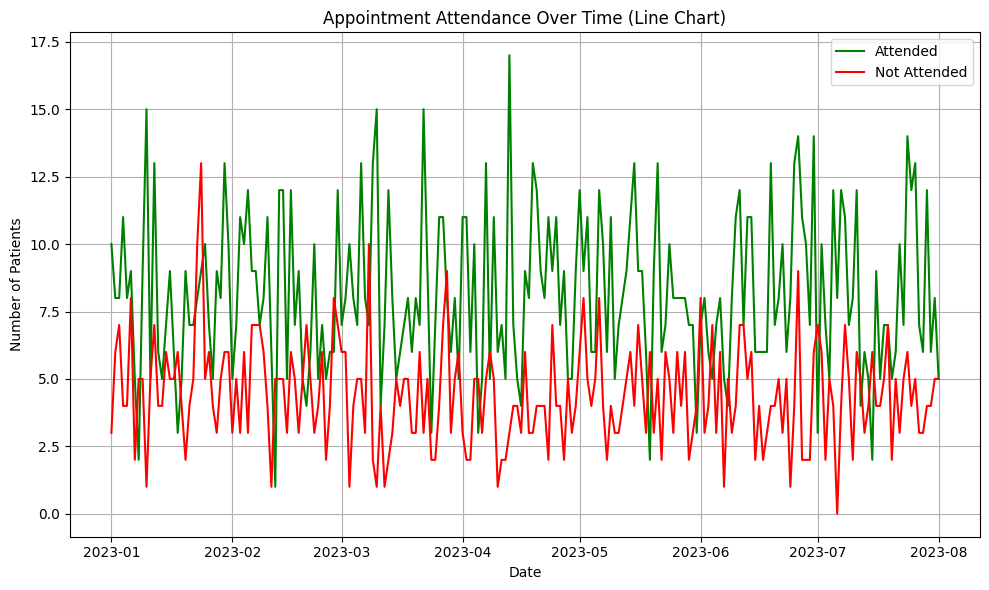

In [32]:

appointments_data = pd.read_csv('data/appointments_data.csv')

# Convert 'appointment_date' to datetime
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Group by date and appointment status to get the count of attended and not attended appointments
attendance_over_time = appointments_data.groupby(['appointment_date', 'appointment_status'])['patient_id'].count().unstack().fillna(0)

# Line chart for attendance and non-attendance over time
plt.figure(figsize=(10, 6))

# Plot 'Attended' line
plt.plot(attendance_over_time.index, attendance_over_time['Attended'], label='Attended', color='green')

# Plot 'Not Attended' line
plt.plot(attendance_over_time.index, attendance_over_time['Not Attended'], label='Not Attended', color='red')

# Add titles and labels
plt.title('Appointment Attendance Over Time (Line Chart)')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.grid(True)

# Add legend
plt.legend()

# Show line chart
plt.tight_layout()
plt.show()

# # Bar chart for attendance and non-attendance over time
# plt.figure(figsize=(10, 6))

# # Plot 'Attended' bar
# attendance_over_time['Attended'].plot(kind='bar', color='green', label='Attended', width=0.4, position=1)

# # Plot 'Not Attended' bar
# attendance_over_time['Not Attended'].plot(kind='bar', color='red', label='Not Attended', width=0.4, position=0)

# # Add titles and labels
# plt.title('Appointment Attendance Over Time (Bar Chart)')
# plt.xlabel('Date')
# plt.ylabel('Number of Patients')
# plt.xticks(rotation=90)
# plt.grid(True, axis='y')

# # Add legend
# plt.legend()

# # Show bar chart
# plt.tight_layout()
# plt.show()


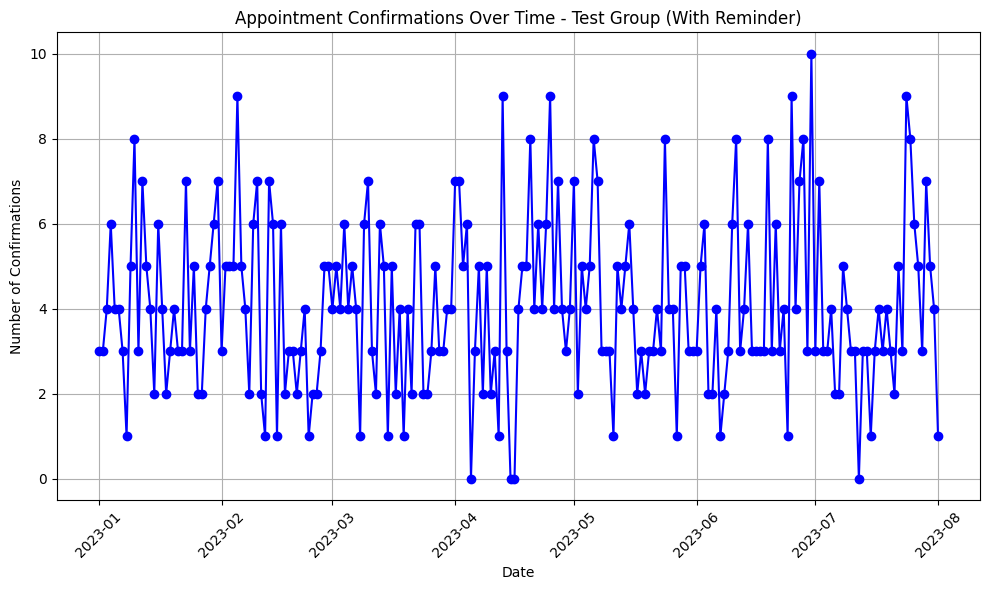

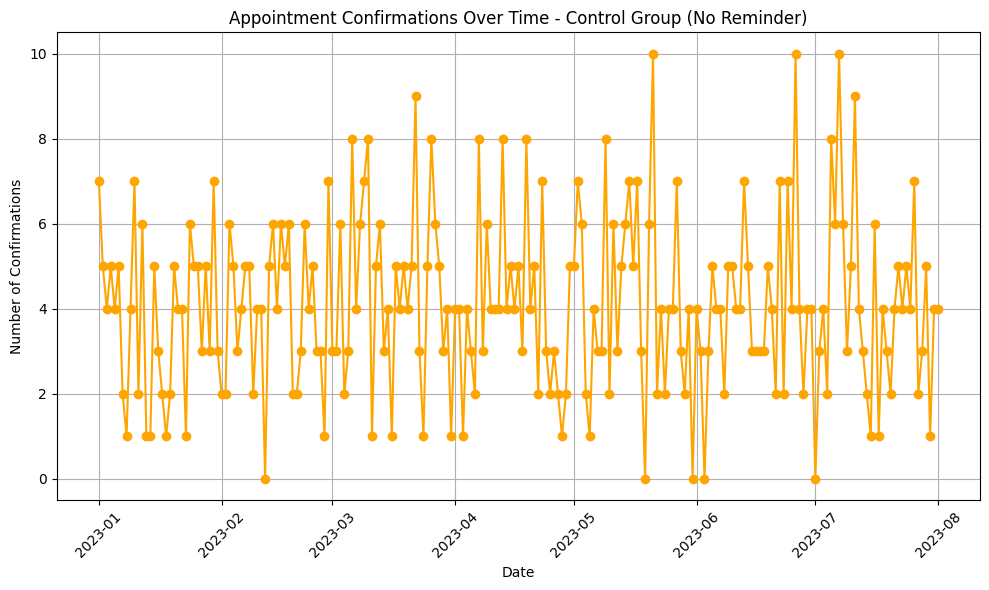

group             Control  Test
appointment_date               
2023-01-01            7.0   3.0
2023-01-02            5.0   3.0
2023-01-03            4.0   4.0
2023-01-04            5.0   6.0
2023-01-05            4.0   4.0
...                   ...   ...
2023-07-28            3.0   3.0
2023-07-29            5.0   7.0
2023-07-30            1.0   5.0
2023-07-31            4.0   4.0
2023-08-01            4.0   1.0

[213 rows x 2 columns]


In [33]:
# Load your datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge datasets on 'patient_id'
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Convert 'appointment_date' to datetime
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Filter for 'Attended' status (confirmed appointments)
confirmed_data = merged_data[merged_data['appointment_status'] == 'Attended']

# Group by date and A/B test group to count the number of confirmations per day
confirmation_over_time = confirmed_data.groupby([confirmed_data['appointment_date'].dt.date, 'group'])['patient_id'].nunique().unstack().fillna(0)

# Plot for Test Group
plt.figure(figsize=(10, 6))
plt.plot(confirmation_over_time.index, confirmation_over_time['Test'], label='Test Group (With Reminder)', color='blue', marker='o')
plt.title('Appointment Confirmations Over Time - Test Group (With Reminder)')
plt.xlabel('Date')
plt.ylabel('Number of Confirmations')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Control Group
plt.figure(figsize=(10, 6))
plt.plot(confirmation_over_time.index, confirmation_over_time['Control'], label='Control Group (No Reminder)', color='orange', marker='o')
plt.title('Appointment Confirmations Over Time - Control Group (No Reminder)')
plt.xlabel('Date')
plt.ylabel('Number of Confirmations')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the result for inspection
print(confirmation_over_time)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       381
           1       0.78      1.00      0.87      1317

    accuracy                           0.78      1698
   macro avg       0.39      0.50      0.44      1698
weighted avg       0.60      0.78      0.68      1698



/Users/ismatsamadov/kyla_ProductAnalyst/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ismatsamadov/kyla_ProductAnalyst/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ismatsamadov/kyla_ProductAnalyst/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

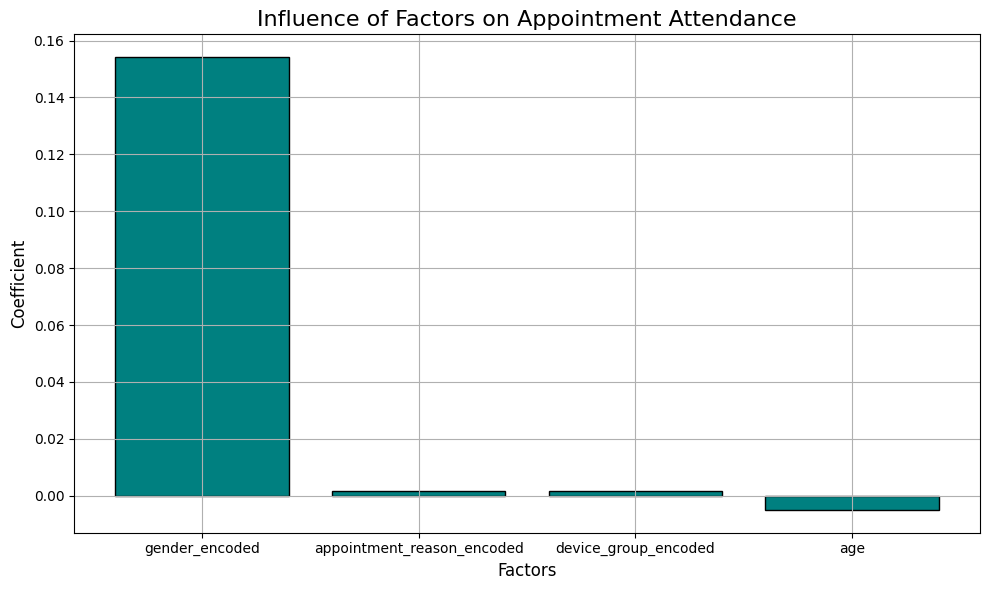

                       Factor  Coefficient
1              gender_encoded     0.154240
2  appointment_reason_encoded     0.001515
3        device_group_encoded     0.001509
0                         age    -0.005010


In [34]:

# Load the datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Encode categorical variables (e.g., gender, appointment reason, device group)
le_gender = LabelEncoder()
merged_data['gender_encoded'] = le_gender.fit_transform(merged_data['gender'])

le_appointment_reason = LabelEncoder()
merged_data['appointment_reason_encoded'] = le_appointment_reason.fit_transform(merged_data['appointment_reason'])

le_device_group = LabelEncoder()
merged_data['device_group_encoded'] = le_device_group.fit_transform(merged_data['device'])

# Create a feature matrix X and target vector y
X = merged_data[['age', 'gender_encoded', 'appointment_reason_encoded', 'device_group_encoded']]
y = merged_data['appointment_status'].apply(lambda x: 1 if x == 'Attended' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Display a classification report
print(classification_report(y_test, y_pred))

# Display the coefficients to interpret the influence of factors
coefficients = pd.DataFrame({"Factor": X.columns, "Coefficient": model.coef_[0]})
coefficients.sort_values(by="Coefficient", ascending=False, inplace=True)

# Plot the coefficients for each factor
plt.figure(figsize=(10, 6))
plt.bar(coefficients['Factor'], coefficients['Coefficient'], color='teal', edgecolor='black')
plt.title('Influence of Factors on Appointment Attendance', fontsize=16)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the sorted coefficients for further interpretation
print(coefficients)


Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61       381
           1       0.88      0.90      0.89      1317

    accuracy                           0.83      1698
   macro avg       0.76      0.75      0.75      1698
weighted avg       0.83      0.83      0.83      1698

Accuracy Score:  0.8303886925795053


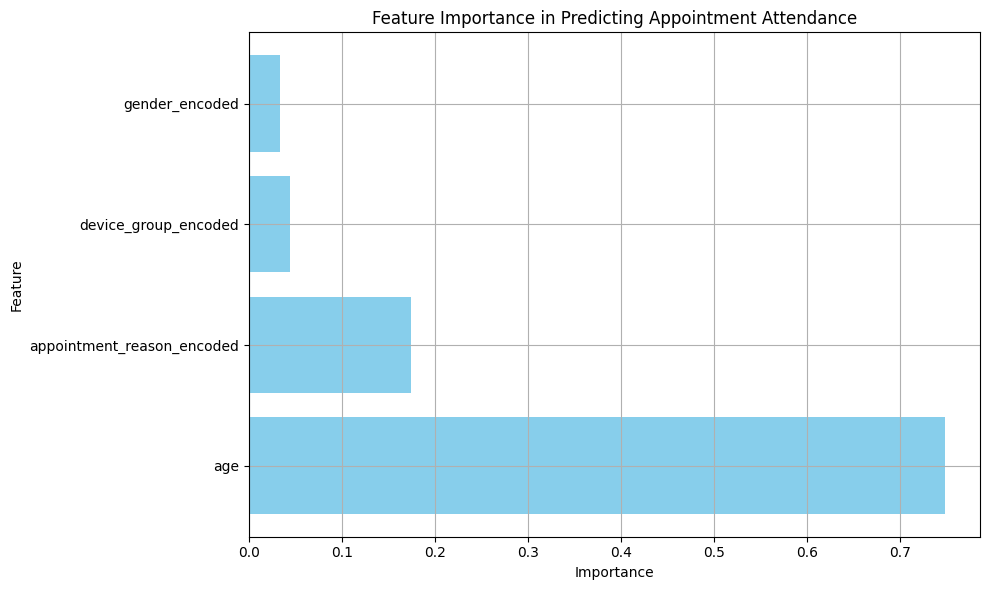

In [35]:
# Reload the necessary data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Encode categorical variables (gender, appointment reason, device group)
le_gender = LabelEncoder()
merged_data['gender_encoded'] = le_gender.fit_transform(merged_data['gender'])

le_appointment_reason = LabelEncoder()
merged_data['appointment_reason_encoded'] = le_appointment_reason.fit_transform(merged_data['appointment_reason'])

le_device_group = LabelEncoder()
merged_data['device_group_encoded'] = le_device_group.fit_transform(merged_data['device_group'])

# Create the feature matrix X and target vector y
X = merged_data[['age', 'gender_encoded', 'appointment_reason_encoded', 'device_group_encoded']]
y = merged_data['appointment_status'].apply(lambda x: 1 if x == 'Attended' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Display a classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# Get feature importance from the model
feature_importance = rf_model.feature_importances_

# Create a DataFrame to visualize feature importance
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance in Predicting Appointment Attendance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


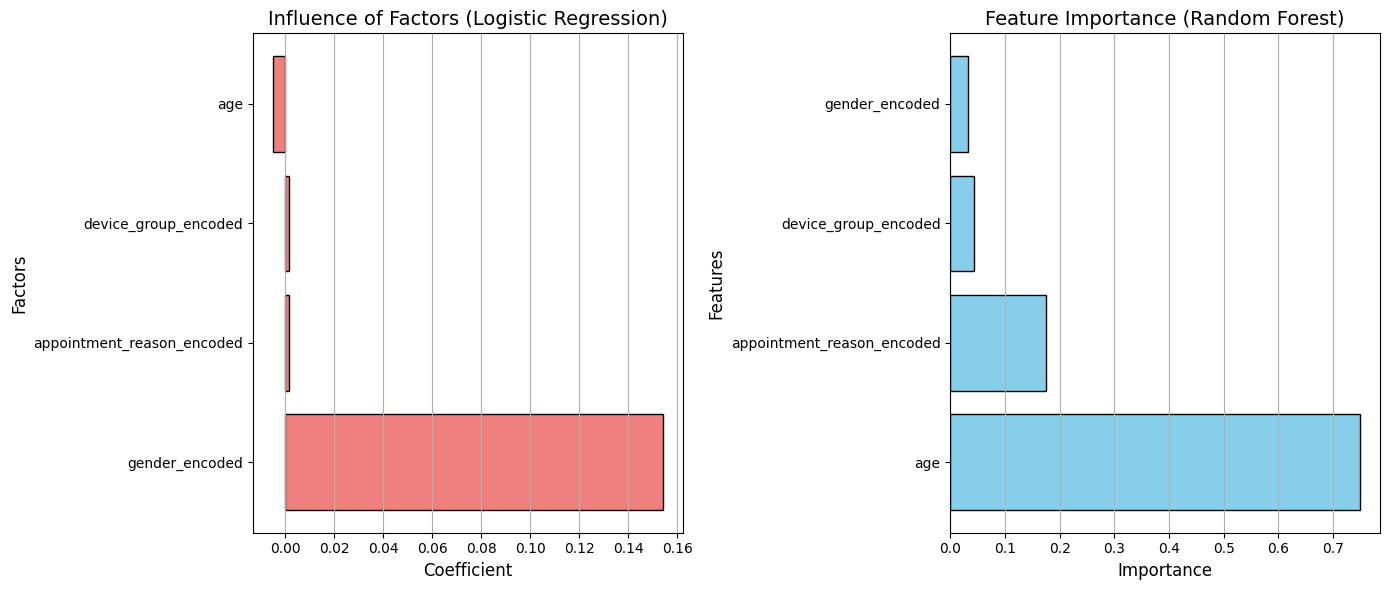

In [36]:
# Plot the logistic regression coefficients
plt.figure(figsize=(14, 6))

# Subplot 1: Logistic Regression Coefficients
plt.subplot(1, 2, 1)
plt.barh(coefficients['Factor'], coefficients['Coefficient'], color='lightcoral', edgecolor='black')
plt.title('Influence of Factors (Logistic Regression)', fontsize=14)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Factors', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='x')

# Subplot 2: Random Forest Feature Importance
plt.subplot(1, 2, 2)
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue', edgecolor='black')
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='x')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


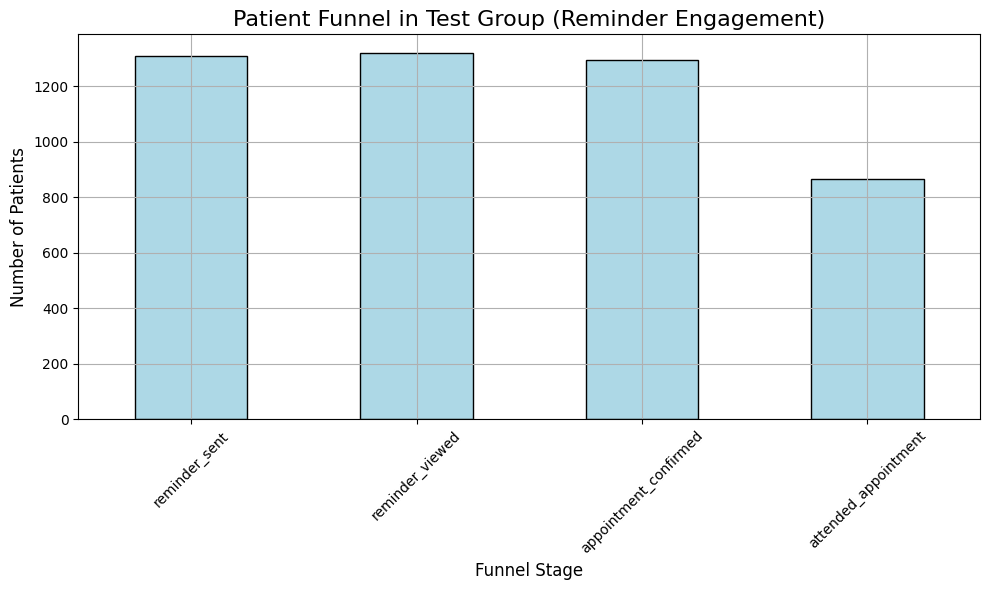

In [37]:

# Merge the data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter for Test group
test_group = merged_data[merged_data['group'] == 'Test']

# Calculate how many patients went through each funnel stage
funnel_counts = test_group['event_name'].value_counts()

# Creating the funnel stages order
funnel_order = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_counts = funnel_counts.reindex(funnel_order).fillna(0)

# Plotting the funnel
plt.figure(figsize=(10, 6))
funnel_counts.plot(kind='bar', color='lightblue', edgecolor='black')

# Adding titles and labels
plt.title('Patient Funnel in Test Group (Reminder Engagement)', fontsize=16)
plt.xlabel('Funnel Stage', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


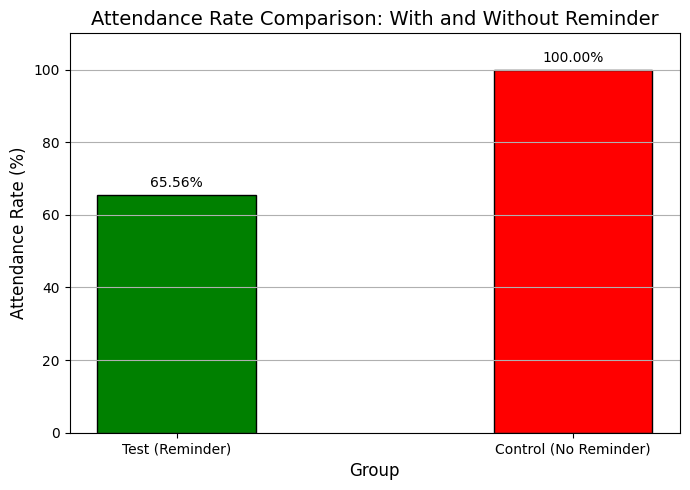

Test Group (With Reminder) Attendance Rate: 65.56%
Control Group (Without Reminder) Attendance Rate: 100.00%


In [38]:

# Merge the data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Calculate attendance rates for Test group (Reminder sent)
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()
test_attendance_rate = (test_attended / test_total) * 100

# Calculate attendance rates for Control group (No reminder)
control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()
control_attendance_rate = (control_attended / control_total) * 100

# Create a DataFrame to store the attendance rates for both groups
attendance_data = pd.DataFrame({
    'Group': ['Test (Reminder)', 'Control (No Reminder)'],
    'Attendance Rate (%)': [test_attendance_rate, control_attendance_rate]
})

# Plot the attendance rates comparison
plt.figure(figsize=(7, 5))
plt.bar(attendance_data['Group'], attendance_data['Attendance Rate (%)'], color=['green', 'red'], edgecolor='black', width=0.4)

# Add titles and labels with reasonable fonts
plt.title('Attendance Rate Comparison: With and Without Reminder', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.ylim(0, 110)  # Adjust the limit to fit 100% for control
plt.grid(True, axis='y')

# Display the attendance rate for each group on the bars
for i, rate in enumerate(attendance_data['Attendance Rate (%)']):
    plt.text(i, rate + 2, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print out the calculated rates
print(f"Test Group (With Reminder) Attendance Rate: {test_attendance_rate:.2f}%")
print(f"Control Group (Without Reminder) Attendance Rate: {control_attendance_rate:.2f}%")


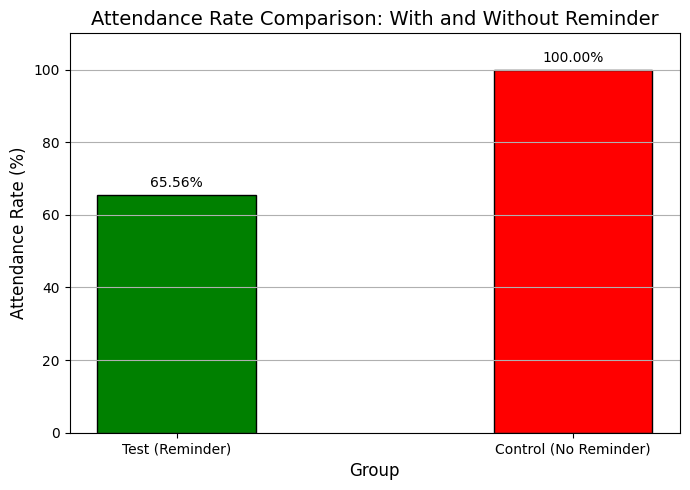

Test Group (With Reminder) Attendance Rate: 65.56%
Control Group (Without Reminder) Attendance Rate: 100.00%


In [39]:

# Merge the data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Calculate attendance rates for Test group (Reminder sent)
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()
test_attendance_rate = (test_attended / test_total) * 100

# Calculate attendance rates for Control group (No reminder)
control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()
control_attendance_rate = (control_attended / control_total) * 100

# Create a DataFrame to store the attendance rates for both groups
attendance_data = pd.DataFrame({
    'Group': ['Test (Reminder)', 'Control (No Reminder)'],
    'Attendance Rate (%)': [test_attendance_rate, control_attendance_rate]
})

# Plot the attendance rates comparison
plt.figure(figsize=(7, 5))
plt.bar(attendance_data['Group'], attendance_data['Attendance Rate (%)'], color=['green', 'red'], edgecolor='black', width=0.4)

# Add titles and labels with reasonable fonts
plt.title('Attendance Rate Comparison: With and Without Reminder', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.ylim(0, 110)  # Adjust the limit to fit 100% for control
plt.grid(True, axis='y')

# Display the attendance rate for each group on the bars
for i, rate in enumerate(attendance_data['Attendance Rate (%)']):
    plt.text(i, rate + 2, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print out the calculated rates
print(f"Test Group (With Reminder) Attendance Rate: {test_attendance_rate:.2f}%")
print(f"Control Group (Without Reminder) Attendance Rate: {control_attendance_rate:.2f}%")


Test Group Appointment Status Distribution:
appointment_status
Attended        3457
Not Attended    1334
Name: count, dtype: int64

Control Group Appointment Status Distribution:
appointment_status
Attended    869
Name: count, dtype: int64

Test Group (With Reminder) Attendance Rate: 866/1321 (65.56%)
Control Group (Without Reminder) Attendance Rate: 869/869 (100.00%)


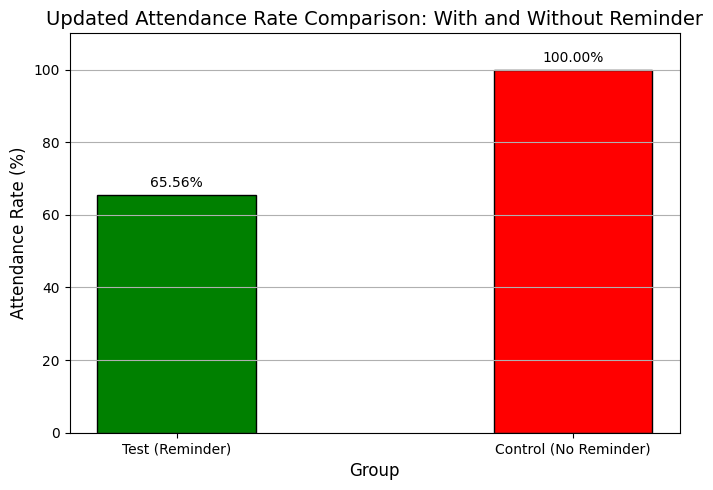

In [40]:
# Step 1: Inspect the appointment_status distribution in both Test and Control groups
test_appointment_status_dist = test_group['appointment_status'].value_counts()
control_appointment_status_dist = control_group['appointment_status'].value_counts()

print("Test Group Appointment Status Distribution:")
print(test_appointment_status_dist)

print("\nControl Group Appointment Status Distribution:")
print(control_appointment_status_dist)

# Step 2: Double check attendance rates with more transparency
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()
test_attendance_rate = (test_attended / test_total) * 100

control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()
control_attendance_rate = (control_attended / control_total) * 100

print(f"\nTest Group (With Reminder) Attendance Rate: {test_attended}/{test_total} ({test_attendance_rate:.2f}%)")
print(f"Control Group (Without Reminder) Attendance Rate: {control_attended}/{control_total} ({control_attendance_rate:.2f}%)")

# Step 3: Check for potential patterns in the Control group that might lead to 100% attendance
# If the Control Group really has 100%, investigate why.

# Visualize the attendance distribution for each group again if necessary
attendance_data = pd.DataFrame({
    'Group': ['Test (Reminder)', 'Control (No Reminder)'],
    'Attendance Rate (%)': [test_attendance_rate, control_attendance_rate]
})

# Plot the updated attendance rates comparison
plt.figure(figsize=(7, 5))
plt.bar(attendance_data['Group'], attendance_data['Attendance Rate (%)'], color=['green', 'red'], edgecolor='black', width=0.4)
plt.title('Updated Attendance Rate Comparison: With and Without Reminder', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.ylim(0, 110)
plt.grid(True, axis='y')

# Annotate the bars
for i, rate in enumerate(attendance_data['Attendance Rate (%)']):
    plt.text(i, rate + 2, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


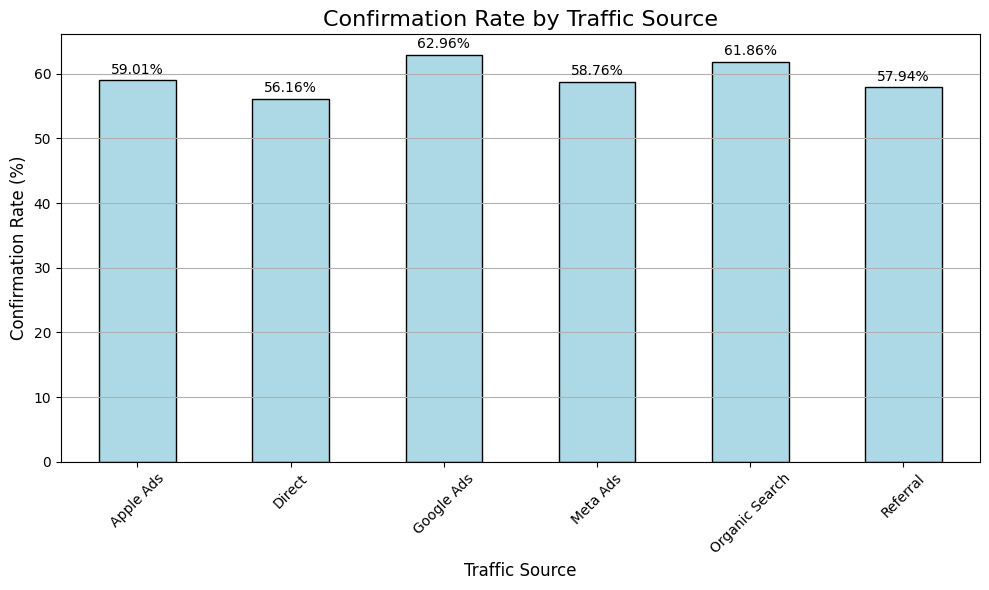

traffic_source
Apple Ads         59.006211
Direct            56.156716
Google Ads        62.962963
Meta Ads          58.757062
Organic Search    61.859583
Referral          57.940663
Name: patient_id, dtype: float64


In [41]:

# Merge the datasets on patient_id
merged_data = pd.merge(pd.merge(ab_test_data, appointments_data, on='patient_id', how='left'), app_data, on='patient_id', how='left')

# Filter for confirmed appointments
confirmed_appointments = merged_data[merged_data['event_name'] == 'appointment_confirmed']

# Calculate the number of confirmed appointments by traffic source
confirmed_by_traffic_source = confirmed_appointments.groupby('traffic_source')['patient_id'].nunique()

# Calculate the total number of patients by traffic source
total_by_traffic_source = merged_data.groupby('traffic_source')['patient_id'].nunique()

# Calculate confirmation rate by traffic source
confirmation_rate_by_traffic_source = (confirmed_by_traffic_source / total_by_traffic_source) * 100

# Plot the confirmation rates by traffic source
plt.figure(figsize=(10, 6))
confirmation_rate_by_traffic_source.plot(kind='bar', color='lightblue', edgecolor='black')

# Add titles and labels
plt.title('Confirmation Rate by Traffic Source', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Confirmation Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')

# Display the confirmation rate for each traffic source on the bars
for i, rate in enumerate(confirmation_rate_by_traffic_source):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the confirmation rates by traffic source
print(confirmation_rate_by_traffic_source)


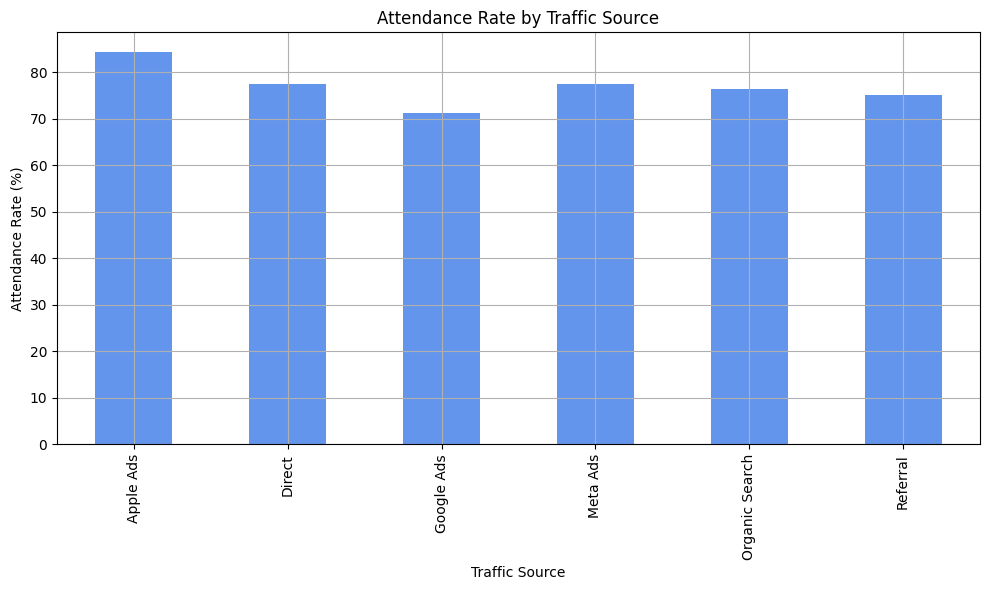

In [42]:

# Ensure that the merged data includes traffic_source and appointment_status
# Group by traffic_source and calculate the attendance rate
traffic_source_attendance = merged_data.groupby('traffic_source')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance rate by traffic source
plt.figure(figsize=(10, 6))
traffic_source_attendance.plot(kind='bar', color='cornflowerblue')
plt.title('Attendance Rate by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


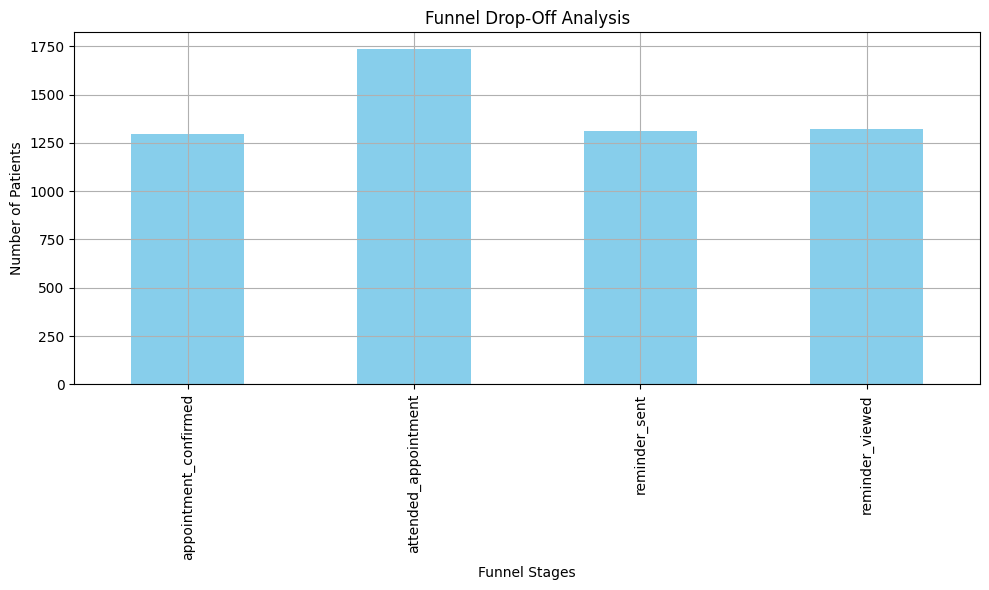

In [43]:
# Funnel stages drop-off rates
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_counts = merged_data[merged_data['event_name'].isin(funnel_stages)].groupby('event_name')['patient_id'].nunique()

# Plot the funnel analysis
plt.figure(figsize=(10, 6))
funnel_counts.plot(kind='bar', color='skyblue')
plt.title('Funnel Drop-Off Analysis')
plt.xlabel('Funnel Stages')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/1406951011.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/1406951011.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_age_group = merged_data.groupby('age_group')['patient_id'].nunique()


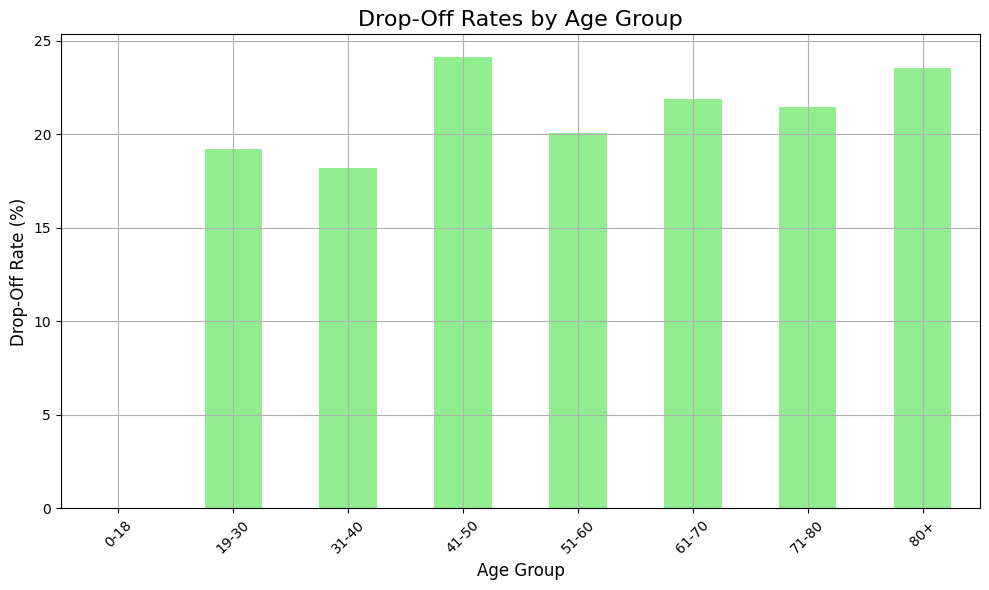

In [44]:

# Reload the necessary data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Drop-off rates by age group
age_group_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
total_age_group = merged_data.groupby('age_group')['patient_id'].nunique()
dropoff_rate_age = (age_group_dropoff / total_age_group) * 100

# Plot drop-off by age group
plt.figure(figsize=(10, 6))
dropoff_rate_age.plot(kind='bar', color='lightgreen')
plt.title('Drop-Off Rates by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Drop-Off Rate (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


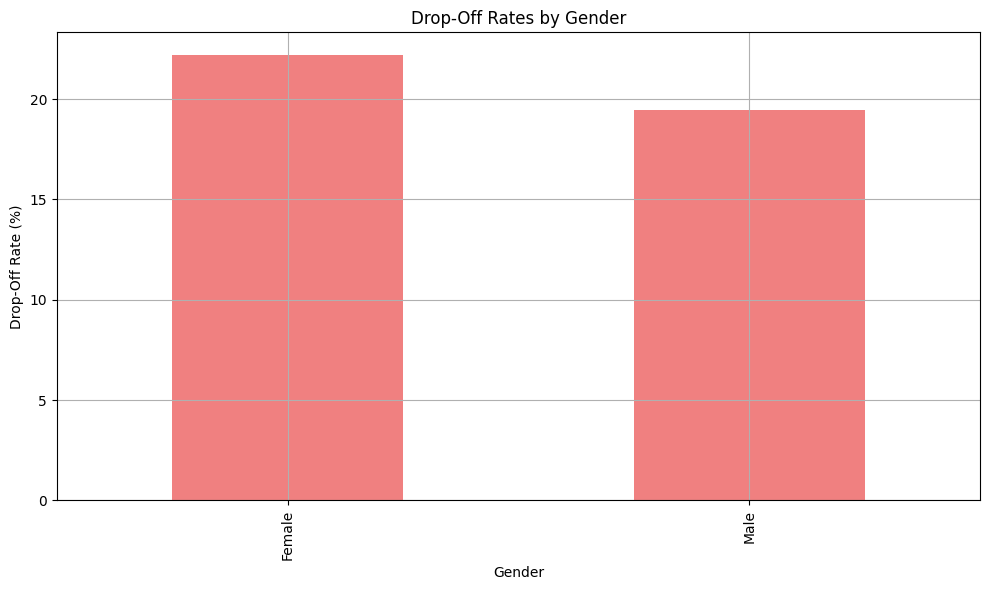

In [45]:
# Drop-off rates by gender
gender_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('gender')['patient_id'].nunique()
total_gender = merged_data.groupby('gender')['patient_id'].nunique()
dropoff_rate_gender = (gender_dropoff / total_gender) * 100

# Plot drop-off by gender
plt.figure(figsize=(10, 6))
dropoff_rate_gender.plot(kind='bar', color='lightcoral')
plt.title('Drop-Off Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


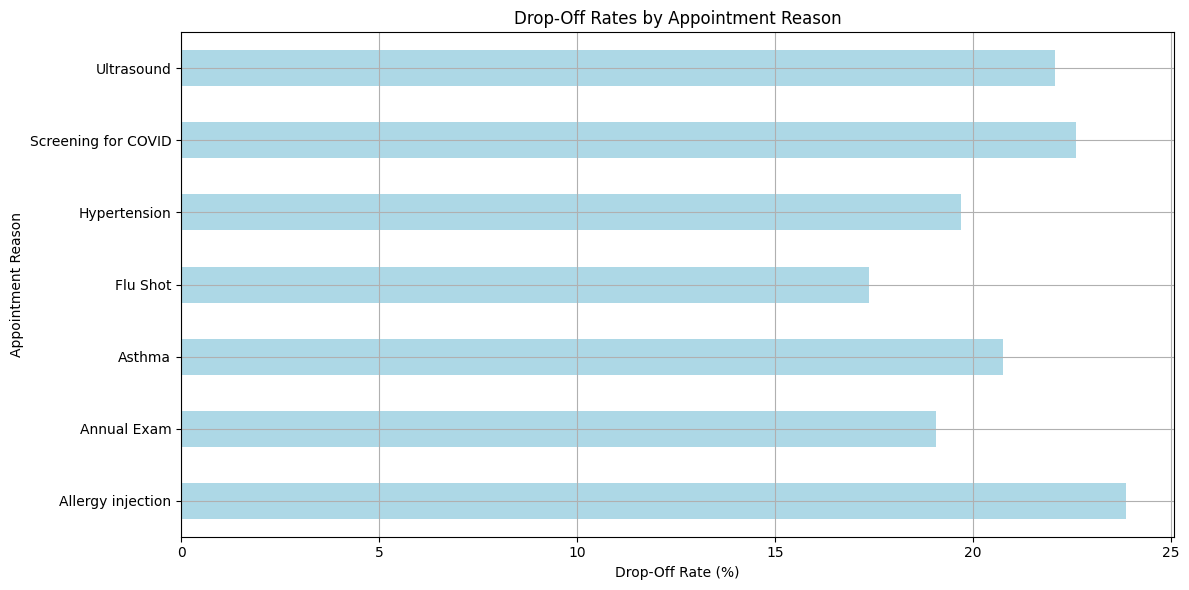

In [46]:
# Drop-off rates by appointment reason
reason_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('appointment_reason')['patient_id'].nunique()
total_reason = merged_data.groupby('appointment_reason')['patient_id'].nunique()
dropoff_rate_reason = (reason_dropoff / total_reason) * 100

# Plot drop-off by appointment reason
plt.figure(figsize=(12, 6))
dropoff_rate_reason.plot(kind='barh', color='lightblue')
plt.title('Drop-Off Rates by Appointment Reason')
plt.xlabel('Drop-Off Rate (%)')
plt.ylabel('Appointment Reason')
plt.grid(True)
plt.tight_layout()
plt.show()


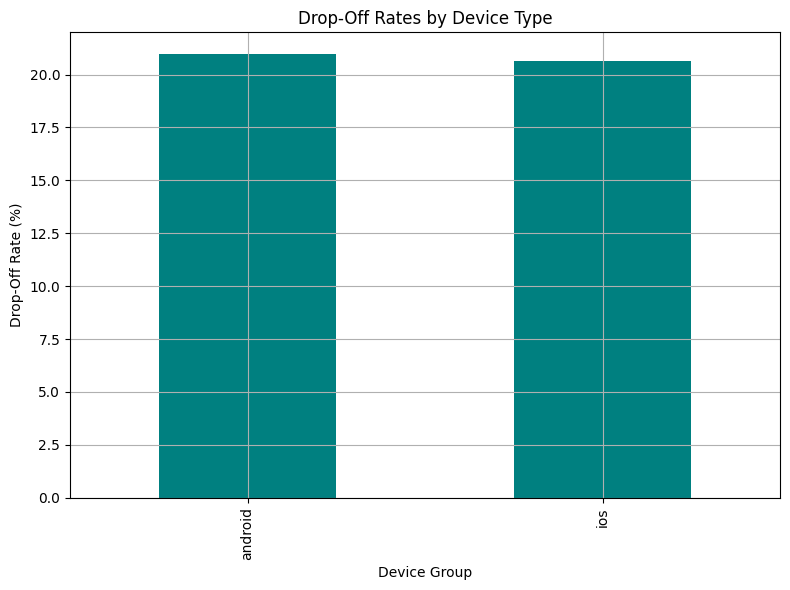

In [47]:
# Drop-off rates by device type
device_group_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('device_group')['patient_id'].nunique()
total_device_group = merged_data.groupby('device_group')['patient_id'].nunique()
dropoff_rate_device = (device_group_dropoff / total_device_group) * 100

# Plot drop-off by device group
plt.figure(figsize=(8, 6))
dropoff_rate_device.plot(kind='bar', color='teal')
plt.title('Drop-Off Rates by Device Type')
plt.xlabel('Device Group')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


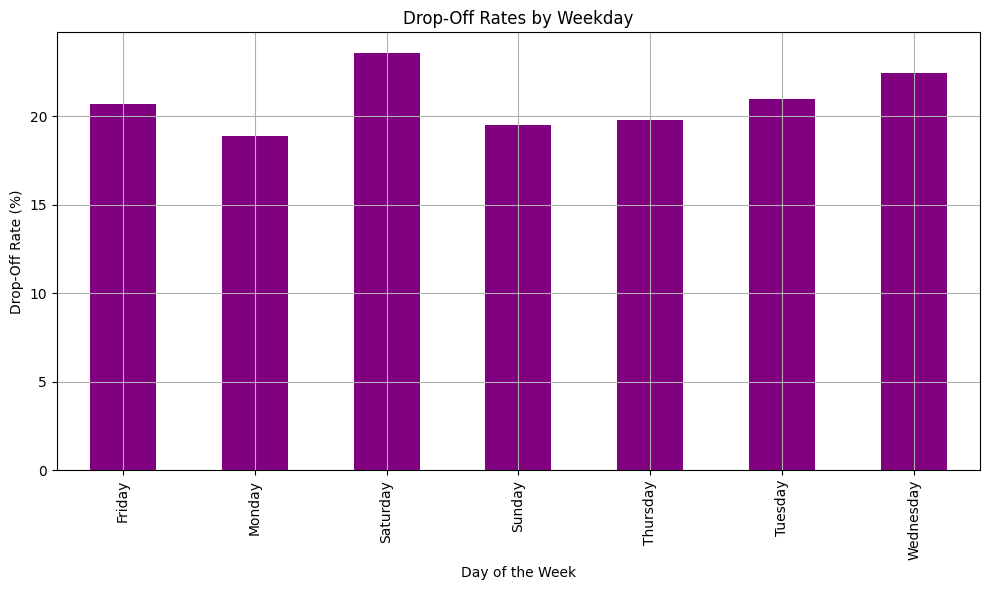

In [48]:
# Drop-off rates by day of the week
merged_data['weekday'] = pd.to_datetime(merged_data['appointment_date']).dt.day_name()
weekday_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('weekday')['patient_id'].nunique()
total_weekday = merged_data.groupby('weekday')['patient_id'].nunique()
dropoff_rate_weekday = (weekday_dropoff / total_weekday) * 100

# Plot drop-off by weekday
plt.figure(figsize=(10, 6))
dropoff_rate_weekday.plot(kind='bar', color='purple')
plt.title('Drop-Off Rates by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


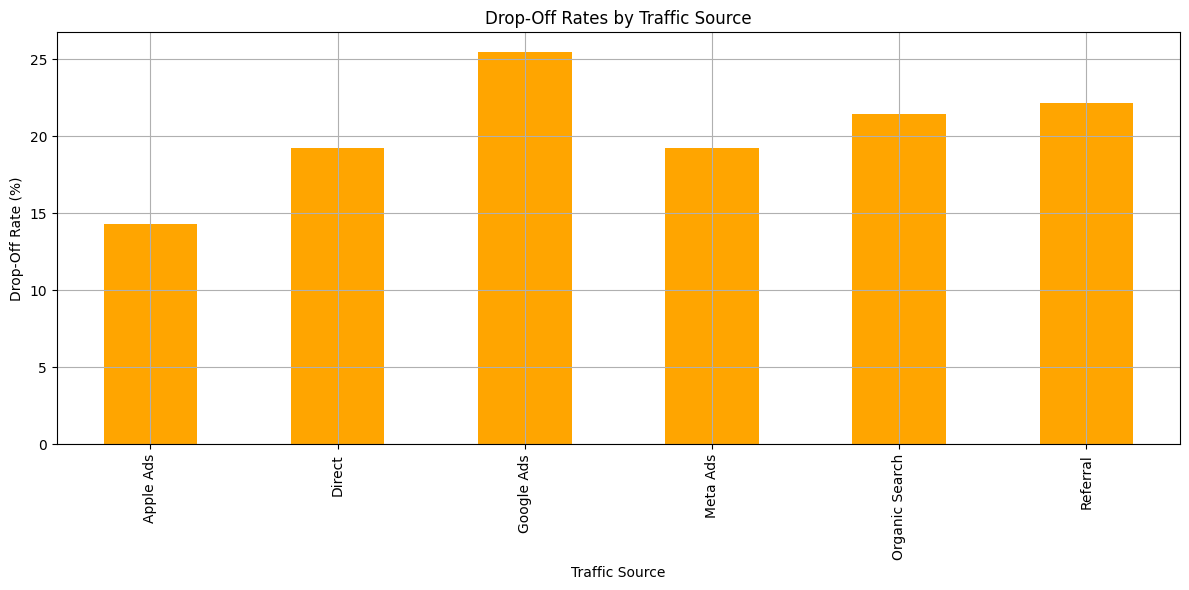

In [49]:
# Drop-off rates by traffic source
traffic_source_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('traffic_source')['patient_id'].nunique()
total_traffic_source = merged_data.groupby('traffic_source')['patient_id'].nunique()
dropoff_rate_traffic = (traffic_source_dropoff / total_traffic_source) * 100

# Plot drop-off by traffic source
plt.figure(figsize=(12, 6))
dropoff_rate_traffic.plot(kind='bar', color='orange')
plt.title('Drop-Off Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


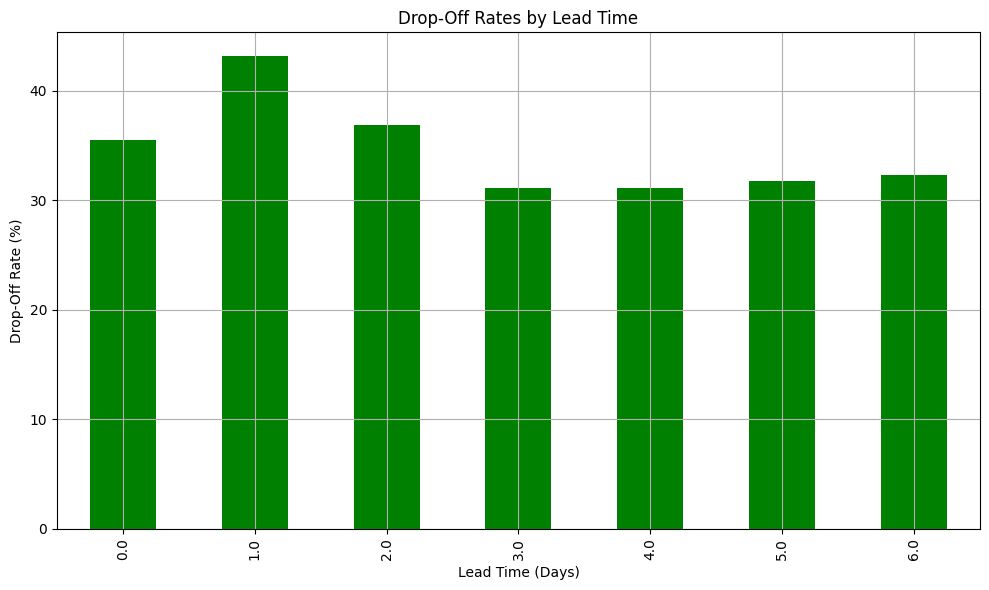

In [50]:
# Convert the necessary columns to datetime
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Extract reminder_sent and appointment_confirmed from ab_test_data
reminder_sent_data = ab_test_data[ab_test_data['event_name'] == 'reminder_sent'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'reminder_sent_datetime'})
appointment_confirmed_data = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'appointment_confirmed_datetime'})

# Merge the reminder and confirmed data into appointments_data
merged_data = pd.merge(appointments_data, reminder_sent_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, appointment_confirmed_data, on='patient_id', how='left')

# Calculate the lead time (in days) between reminder_sent and appointment_date
merged_data['lead_time'] = (merged_data['appointment_date'] - merged_data['reminder_sent_datetime']).dt.days
merged_data['lead_time'] = merged_data['lead_time'].clip(lower=0)

# Drop-off rates by lead time
lead_time_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('lead_time')['patient_id'].nunique()
total_lead_time = merged_data.groupby('lead_time')['patient_id'].nunique()
dropoff_rate_lead_time = (lead_time_dropoff / total_lead_time) * 100

# Plot drop-off by lead time
plt.figure(figsize=(10, 6))
dropoff_rate_lead_time.plot(kind='bar', color='green')
plt.title('Drop-Off Rates by Lead Time')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

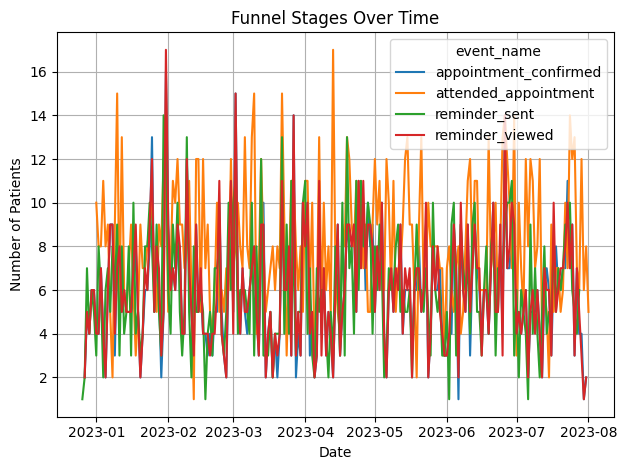

In [51]:

ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Ensure the datetime column exists or rename it accordingly (e.g., event_datetime could be a different column)
# In this case, we'll assume the column exists in ab_test_data as 'event_datetime'
# Convert event_datetime to datetime format
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'], errors='coerce')

# Define funnel stages
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter the data for funnel stages and group by date and event name
funnel_time = merged_data[merged_data['event_name'].isin(funnel_stages)].groupby([merged_data['event_datetime'].dt.date, 'event_name'])['patient_id'].nunique().unstack()

# Plot funnel stages over time
plt.figure(figsize=(12, 6))
funnel_time.plot(kind='line')
plt.title('Funnel Stages Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


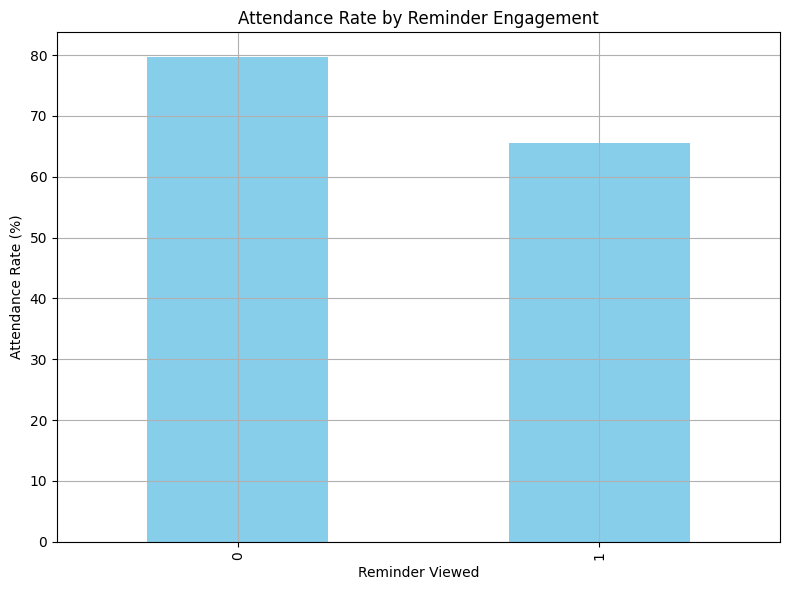

In [52]:
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Ensure the reminder_viewed column exists or adjust accordingly
# Assuming 'reminder_viewed' is a binary indicator (True/False or 1/0) in the dataset
# If 'reminder_viewed' is an event, you'll need to check for that event in 'event_name' instead
if 'reminder_viewed' not in merged_data.columns:
    # Create a binary indicator if reminder_viewed is based on event_name
    merged_data['reminder_viewed'] = merged_data['event_name'].apply(lambda x: 1 if x == 'reminder_viewed' else 0)

# Calculate attendance rates by reminder engagement
reminder_viewed_attendance = merged_data.groupby('reminder_viewed')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Plot reminder engagement and attendance rates
plt.figure(figsize=(8, 6))
reminder_viewed_attendance.plot(kind='bar', color='skyblue')
plt.title('Attendance Rate by Reminder Engagement')
plt.xlabel('Reminder Viewed')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/715144669.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_attendance = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100


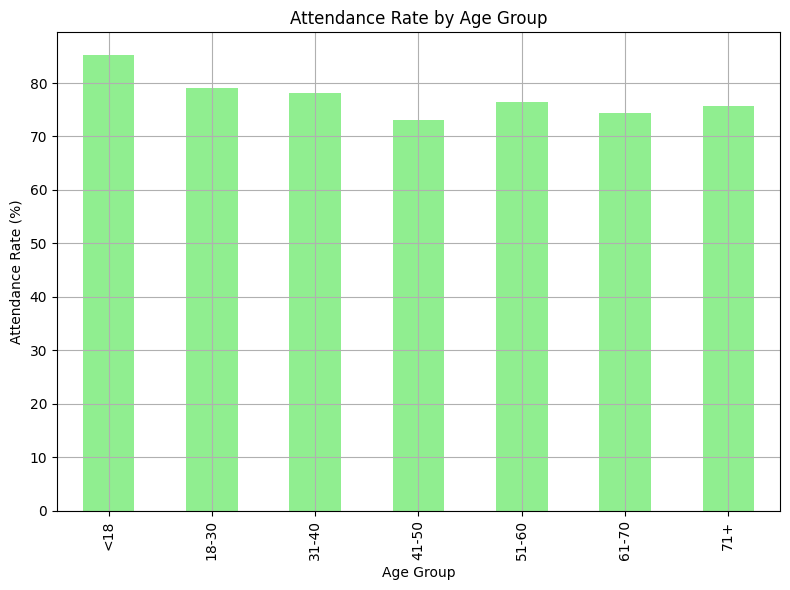

In [53]:

# Load your datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Create age groups using pd.cut
merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 18, 30, 40, 50, 60, 70, 100], 
                                  labels=['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '71+'])

# Group by age group and calculate attendance rate
age_group_attendance = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance by age group
plt.figure(figsize=(8, 6))
age_group_attendance.plot(kind='bar', color='lightgreen')
plt.title('Attendance Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


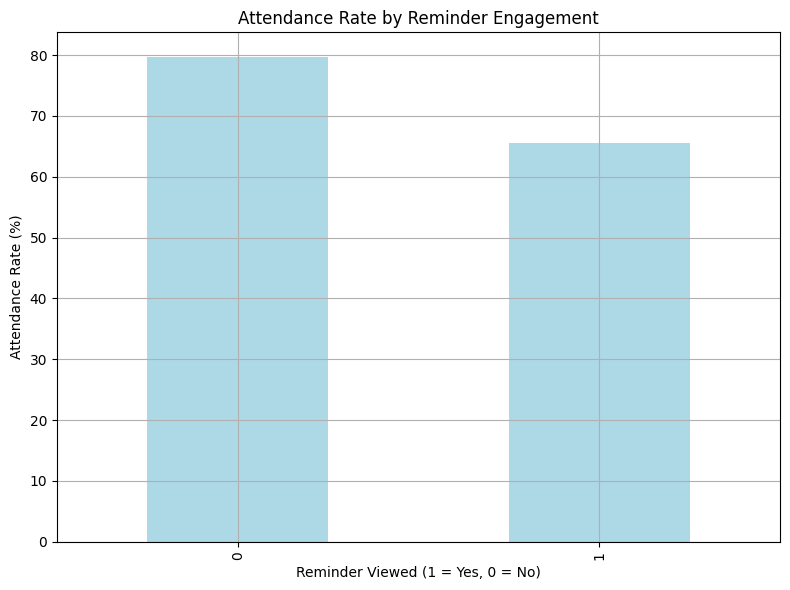

In [54]:

# Load your datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Create a binary column 'reminder_viewed' based on event_name
merged_data['reminder_viewed'] = merged_data['event_name'].apply(lambda x: 1 if x == 'reminder_viewed' else 0)

# Group by reminder_viewed and calculate attendance rate
reminder_attendance = merged_data.groupby('reminder_viewed')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance by reminder engagement
plt.figure(figsize=(8, 6))
reminder_attendance.plot(kind='bar', color='lightblue')
plt.title('Attendance Rate by Reminder Engagement')
plt.xlabel('Reminder Viewed (1 = Yes, 0 = No)')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


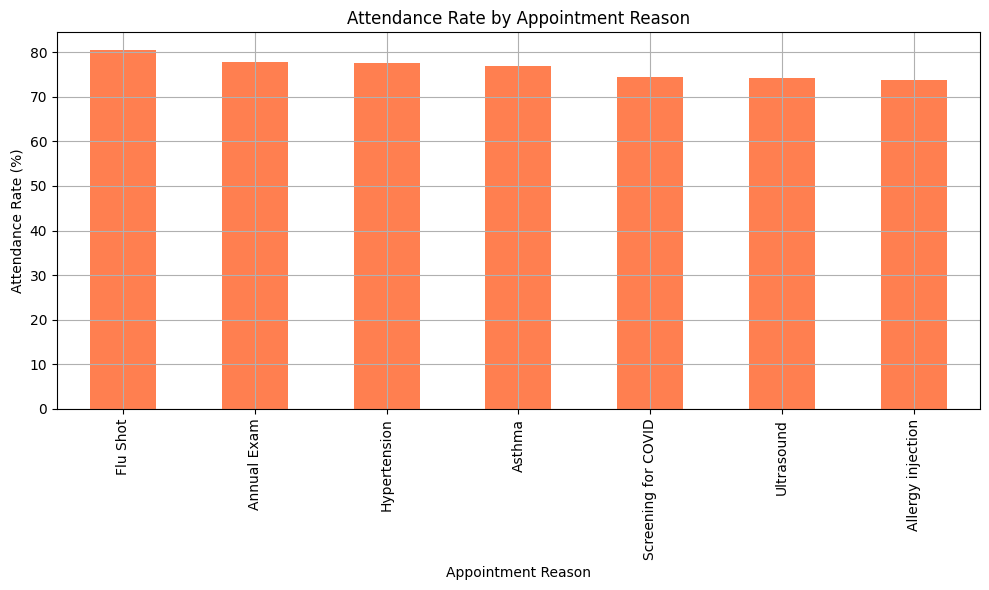

In [55]:

# Load your datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Group by appointment_reason and calculate attendance rate
reason_attendance = merged_data.groupby('appointment_reason')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance by appointment reason
plt.figure(figsize=(10, 6))
reason_attendance.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Attendance Rate by Appointment Reason')
plt.xlabel('Appointment Reason')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


      patient_id  time_to_confirm
0              2        19.123056
1              3        15.434167
2              7        23.312222
3              9        10.961944
4             12        29.717500
...          ...              ...
1279        2659         3.248333
1280        2661        23.098333
1281        2663         4.670278
1282        2666         7.453889
1283        2670        13.495833

[1284 rows x 2 columns]


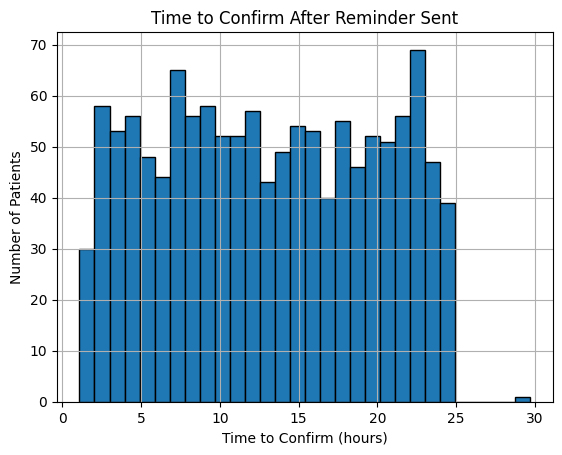

In [56]:

# Step 1: Filter for the Test group
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Step 2: Extract 'reminder_sent' and 'appointment_confirmed' events
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Step 3: Merge reminder_sent and appointment_confirmed on patient_id to get both events for each patient
merged_reminders = pd.merge(reminder_sent[['patient_id', 'event_datetime']], 
                            appointment_confirmed[['patient_id', 'event_datetime']], 
                            on='patient_id', 
                            suffixes=('_reminder_sent', '_confirmed'))

# Step 4: Convert event_datetime columns to datetime objects
merged_reminders['event_datetime_reminder_sent'] = pd.to_datetime(merged_reminders['event_datetime_reminder_sent'])
merged_reminders['event_datetime_confirmed'] = pd.to_datetime(merged_reminders['event_datetime_confirmed'])

# Step 5: Calculate the time difference (in hours) between reminder sent and appointment confirmed
merged_reminders['time_to_confirm'] = (merged_reminders['event_datetime_confirmed'] - merged_reminders['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Step 6: Analyze the distribution of confirmation times
print(merged_reminders[['patient_id', 'time_to_confirm']])

# Step 7: Visualize the distribution of confirmation times

plt.hist(merged_reminders['time_to_confirm'], bins=30, edgecolor='black')
plt.title('Time to Confirm After Reminder Sent')
plt.xlabel('Time to Confirm (hours)')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


age_group
0-20     11.303841
21-40    13.043721
41-60    13.119204
61-80    13.297668
81+      13.316989
Name: time_to_confirm, dtype: float64


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2261157746.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_response_time = merged_reminders_with_age.groupby('age_group')['time_to_confirm'].mean()


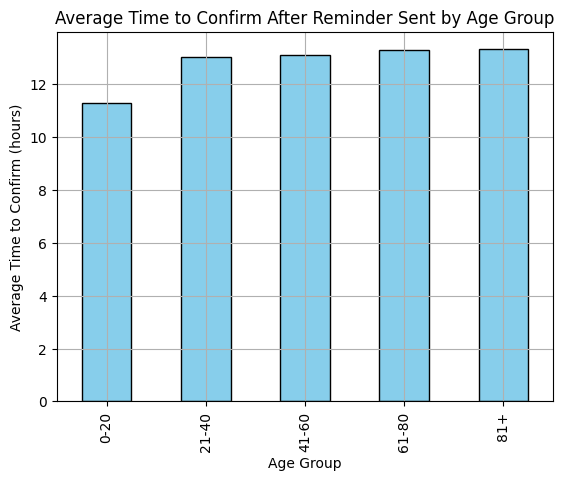

In [57]:
# Step 1: Filter for the Test group
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Step 2: Extract 'reminder_sent' and 'appointment_confirmed' events
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Step 3: Merge reminder_sent and appointment_confirmed on patient_id to get both events for each patient
merged_reminders = pd.merge(reminder_sent[['patient_id', 'event_datetime']], 
                            appointment_confirmed[['patient_id', 'event_datetime']], 
                            on='patient_id', 
                            suffixes=('_reminder_sent', '_confirmed'))

# Step 4: Convert event_datetime columns to datetime objects
merged_reminders['event_datetime_reminder_sent'] = pd.to_datetime(merged_reminders['event_datetime_reminder_sent'])
merged_reminders['event_datetime_confirmed'] = pd.to_datetime(merged_reminders['event_datetime_confirmed'])

# Step 5: Calculate the time difference (in hours) between reminder sent and appointment confirmed
merged_reminders['time_to_confirm'] = (merged_reminders['event_datetime_confirmed'] - 
                                       merged_reminders['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Step 6: Merge the age information from appointments_data with the merged_reminders
merged_reminders_with_age = pd.merge(merged_reminders, appointments_data[['patient_id', 'age']], on='patient_id', how='left')

# Step 7: Create age groups
merged_reminders_with_age['age_group'] = pd.cut(merged_reminders_with_age['age'], 
                                                bins=[0, 20, 40, 60, 80, 100], 
                                                labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Step 8: Group by age group and calculate the average time to confirm
age_group_response_time = merged_reminders_with_age.groupby('age_group')['time_to_confirm'].mean()

# Step 9: Display the average time to confirm for each age group
print(age_group_response_time)

# Step 10: Visualize the results

age_group_response_time.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Time to Confirm After Reminder Sent by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Time to Confirm (hours)')
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/1699781158.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_off_by_age = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/1699781158.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_patients_by_age = merged_data.groupby('age_group')['patient_id'].nunique()


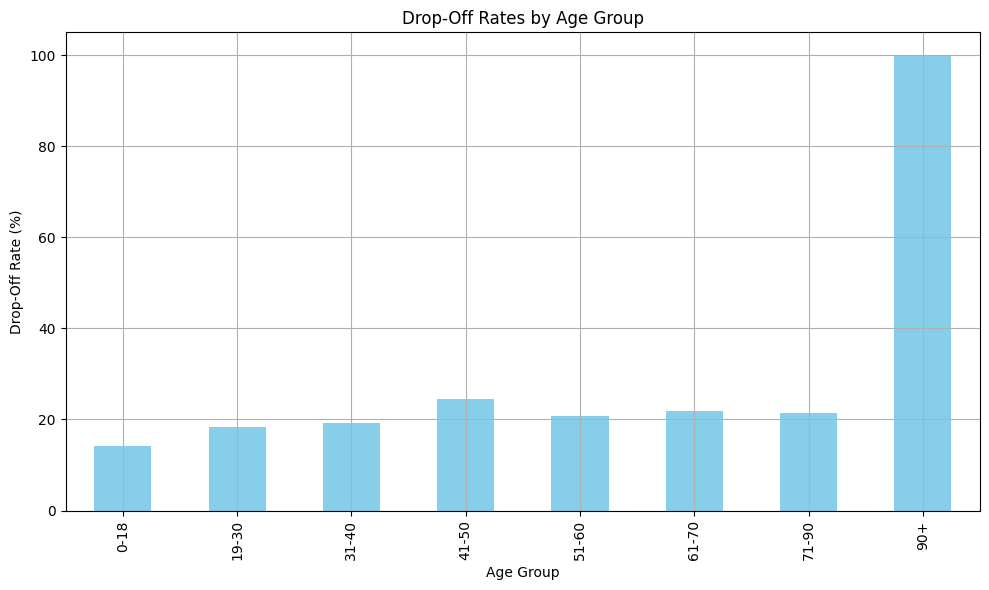

In [58]:

# Segment patients by age group
merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 18, 30, 40, 50, 60, 70, 90, 120], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-90', '90+'])

# Calculate drop-off rates by age group
drop_off_by_age = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
total_patients_by_age = merged_data.groupby('age_group')['patient_id'].nunique()
drop_off_rate_by_age = (drop_off_by_age / total_patients_by_age) * 100

# Visualize drop-off rates by age group
plt.figure(figsize=(10, 6))
drop_off_rate_by_age.plot(kind='bar', color='skyblue')
plt.title('Drop-Off Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


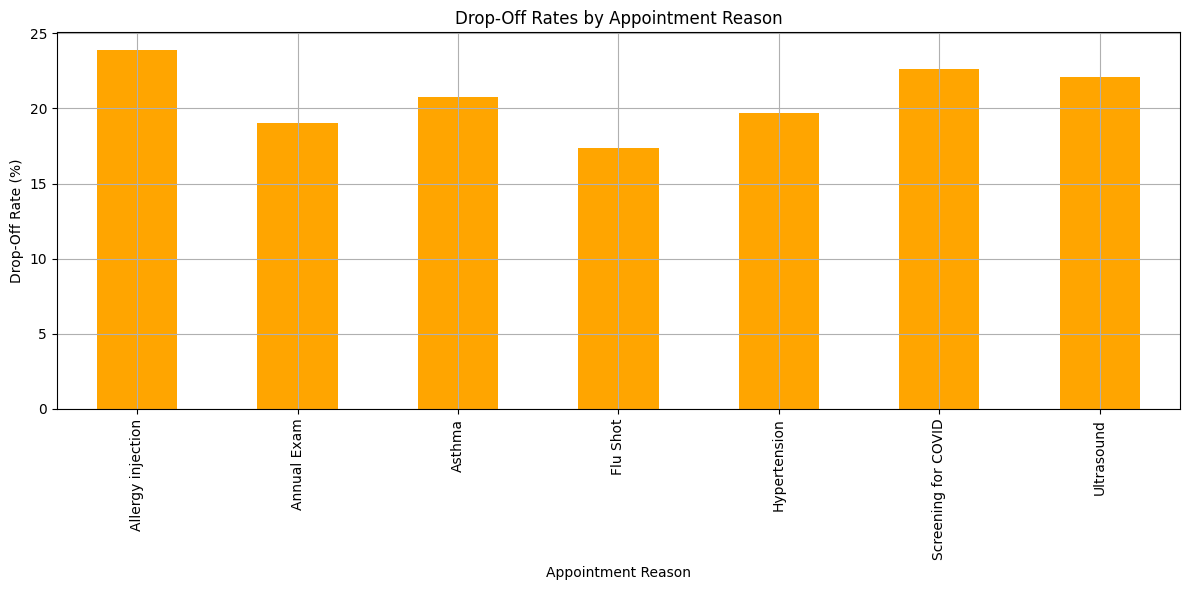

In [59]:
# Calculate drop-off rates by appointment reason
drop_off_by_reason = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('appointment_reason')['patient_id'].nunique()
total_patients_by_reason = merged_data.groupby('appointment_reason')['patient_id'].nunique()
drop_off_rate_by_reason = (drop_off_by_reason / total_patients_by_reason) * 100

# Visualize drop-off rates by appointment reason
plt.figure(figsize=(12, 6))
drop_off_rate_by_reason.plot(kind='bar', color='orange')
plt.title('Drop-Off Rates by Appointment Reason')
plt.xlabel('Appointment Reason')
plt.ylabel('Drop-Off Rate (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


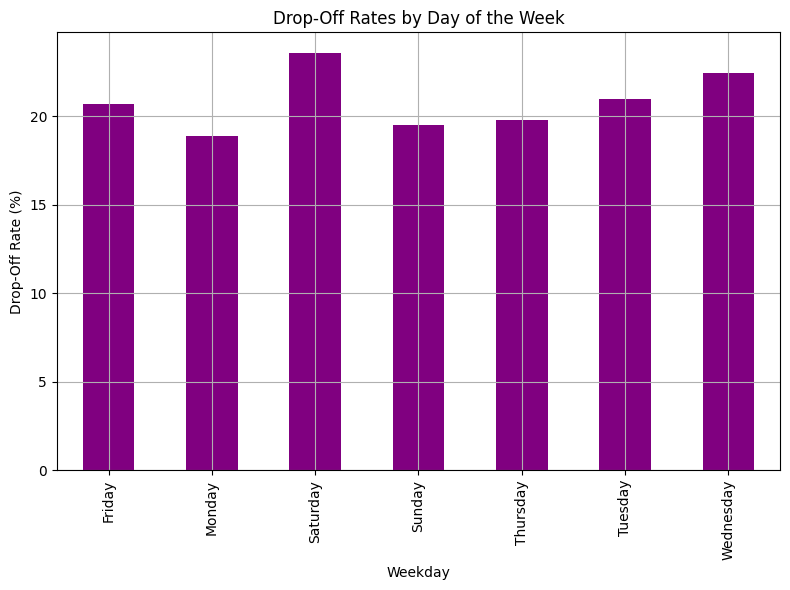

In [60]:
# Extract the weekday from the appointment date
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])
merged_data['weekday'] = merged_data['appointment_date'].dt.day_name()

# Calculate drop-off rates by day of the week
drop_off_by_weekday = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('weekday')['patient_id'].nunique()
total_patients_by_weekday = merged_data.groupby('weekday')['patient_id'].nunique()
drop_off_rate_by_weekday = (drop_off_by_weekday / total_patients_by_weekday) * 100

# Visualize drop-off rates by weekday
plt.figure(figsize=(8, 6))
drop_off_rate_by_weekday.plot(kind='bar', color='purple')
plt.title('Drop-Off Rates by Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


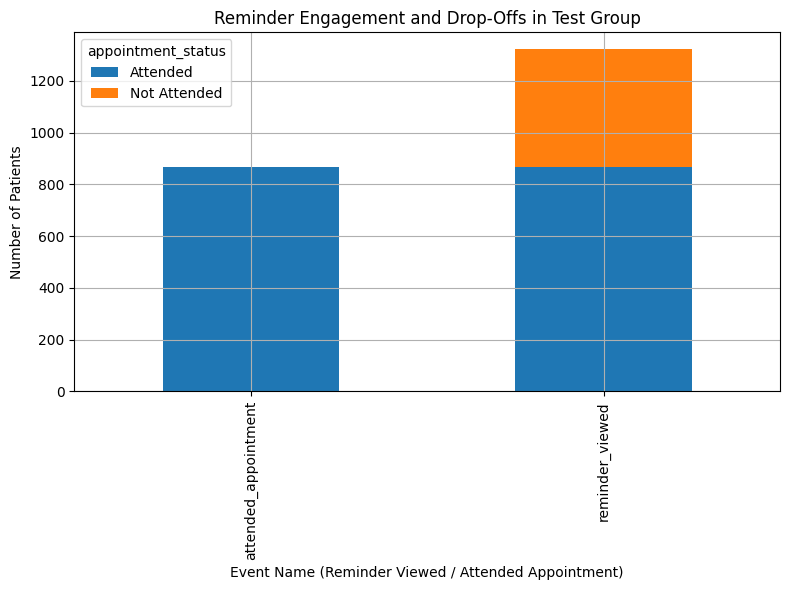

In [61]:

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Check if 'appointment_status' column exists
if 'appointment_status' not in merged_data.columns:
    print("Error: 'appointment_status' column not found in the merged data.")
else:
    # Filter for the test group and relevant events
    test_group = merged_data[merged_data['group'] == 'Test']

    # Assuming 'event_name' contains 'reminder_viewed' events
    reminder_engagement = test_group[test_group['event_name'].isin(['reminder_viewed', 'attended_appointment'])]

    # Group by 'event_name' and 'appointment_status'
    reminder_engagement = reminder_engagement.groupby(['event_name', 'appointment_status'])['patient_id'].nunique().unstack().fillna(0)

    # Visualize reminder engagement vs. drop-offs
    reminder_engagement.plot(kind='bar', stacked=True, figsize=(8, 6))
    plt.title('Reminder Engagement and Drop-Offs in Test Group')
    plt.xlabel('Event Name (Reminder Viewed / Attended Appointment)')
    plt.ylabel('Number of Patients')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


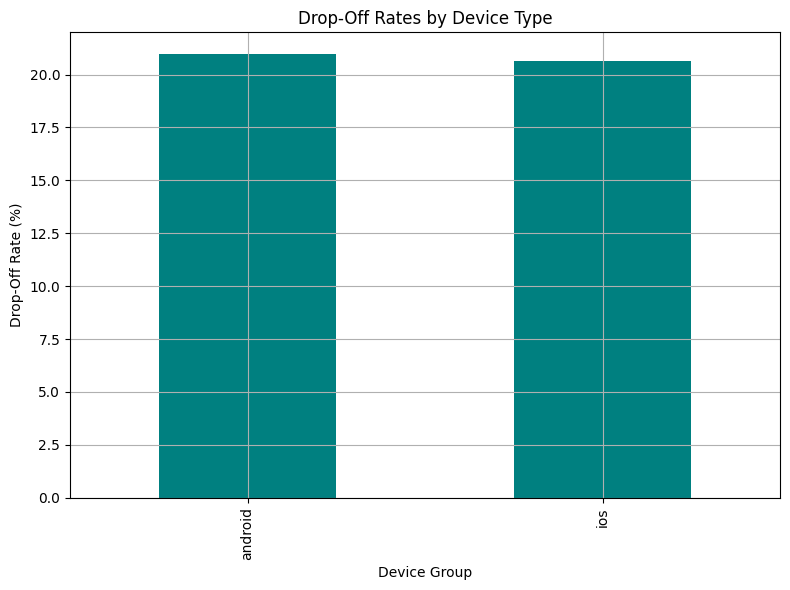

In [62]:

# First, map devices into groups: Android, iOS, and Other
app_data['device'] = app_data['device'].str.lower()  # Ensure all device names are in lowercase
app_data['device_group'] = app_data['device'].apply(lambda x: 'android' if 'android' in x else 'ios' if 'ios' in x else 'other')

# Reload and merge the datasets
# ab_test_data = pd.read_csv('/mnt/data/ab_test_data.csv')
# appointments_data = pd.read_csv('/mnt/data/appointments_data.csv')
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Ensure 'device_group' exists in the final merged_data
# Group by device type (Android, iOS, Other) and calculate drop-off rates
drop_off_by_device = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('device_group')['patient_id'].nunique()
total_patients_by_device = merged_data.groupby('device_group')['patient_id'].nunique()
drop_off_rate_by_device = (drop_off_by_device / total_patients_by_device) * 100

# Visualize drop-off rates by device type
plt.figure(figsize=(8, 6))
drop_off_rate_by_device.plot(kind='bar', color='teal')
plt.title('Drop-Off Rates by Device Type')
plt.xlabel('Device Group')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/700758032.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_off_by_lead_time = merged_data[merged_data['appointment_status'] != 'Attended'].groupby(lead_time_bins)['patient_id'].nunique()
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/700758032.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_patients_by_lead_time = merged_data.groupby(lead_time_bins)['patient_id'].nunique()


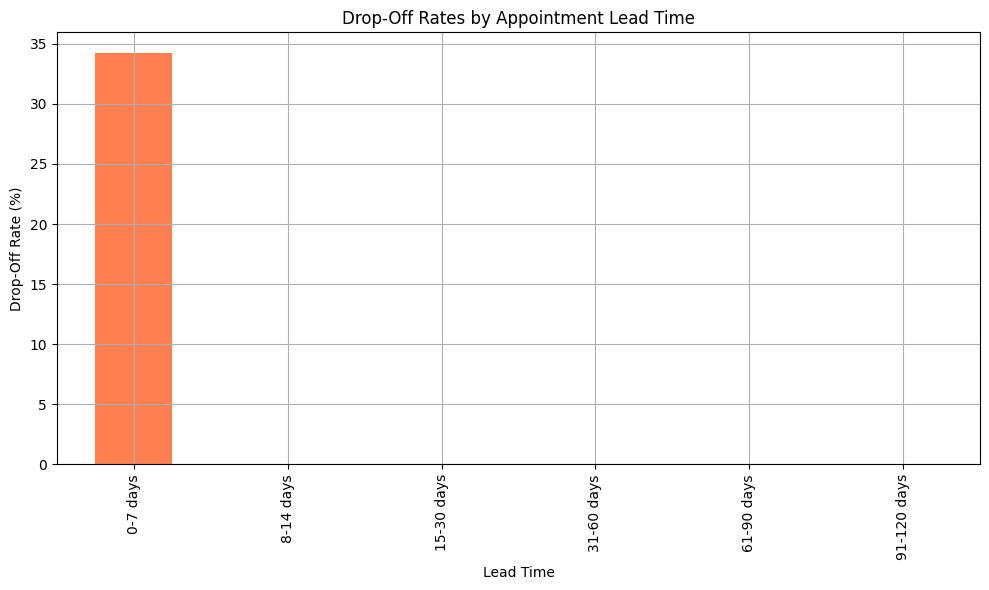

In [63]:
# Calculate the lead time (days between booking the appointment and the appointment date)
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])
merged_data['lead_time_days'] = (merged_data['appointment_date'] - pd.to_datetime(merged_data['event_datetime'])).dt.days

# Group by lead time ranges and calculate drop-off rates
lead_time_bins = pd.cut(merged_data['lead_time_days'], bins=[0, 7, 14, 30, 60, 90, 120], labels=['0-7 days', '8-14 days', '15-30 days', '31-60 days', '61-90 days', '91-120 days'])
drop_off_by_lead_time = merged_data[merged_data['appointment_status'] != 'Attended'].groupby(lead_time_bins)['patient_id'].nunique()
total_patients_by_lead_time = merged_data.groupby(lead_time_bins)['patient_id'].nunique()
drop_off_rate_by_lead_time = (drop_off_by_lead_time / total_patients_by_lead_time) * 100

# Visualize drop-off rates by lead time
plt.figure(figsize=(10, 6))
drop_off_rate_by_lead_time.plot(kind='bar', color='coral')
plt.title('Drop-Off Rates by Appointment Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/382455120.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_off_by_confirmation_time = test_group_times.groupby(confirmation_time_bins)['patient_id'].nunique()


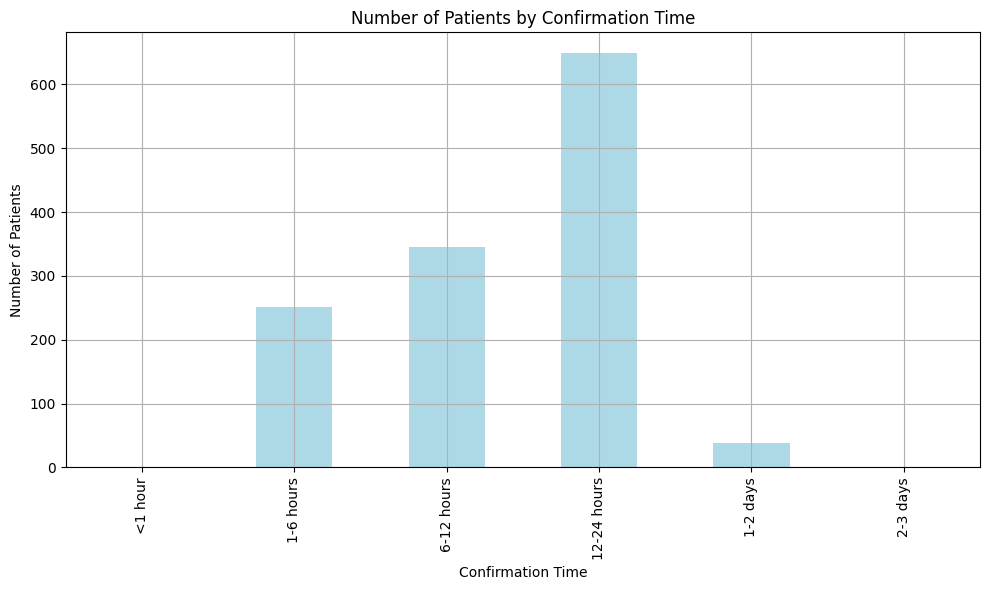

In [64]:
# Filter for the test group
test_group = merged_data[merged_data['group'] == 'Test']

# Extract the datetime for reminder_sent and appointment_confirmed events
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'reminder_sent_datetime'})
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'appointment_confirmed_datetime'})

# Merge the reminder_sent and appointment_confirmed data to calculate the time difference
test_group_times = pd.merge(reminder_sent, appointment_confirmed, on='patient_id', how='inner')

# Calculate the time difference between reminder_sent and appointment_confirmed in hours
test_group_times['confirmation_time'] = (pd.to_datetime(test_group_times['appointment_confirmed_datetime']) - pd.to_datetime(test_group_times['reminder_sent_datetime'])).dt.total_seconds() / 3600

# Group by confirmation time ranges and calculate drop-off rates
confirmation_time_bins = pd.cut(test_group_times['confirmation_time'], bins=[0, 1, 6, 12, 24, 48, 72], labels=['<1 hour', '1-6 hours', '6-12 hours', '12-24 hours', '1-2 days', '2-3 days'])
drop_off_by_confirmation_time = test_group_times.groupby(confirmation_time_bins)['patient_id'].nunique()

# Visualize drop-off rates by confirmation time
plt.figure(figsize=(10, 6))
drop_off_by_confirmation_time.plot(kind='bar', color='lightblue')
plt.title('Number of Patients by Confirmation Time')
plt.xlabel('Confirmation Time')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


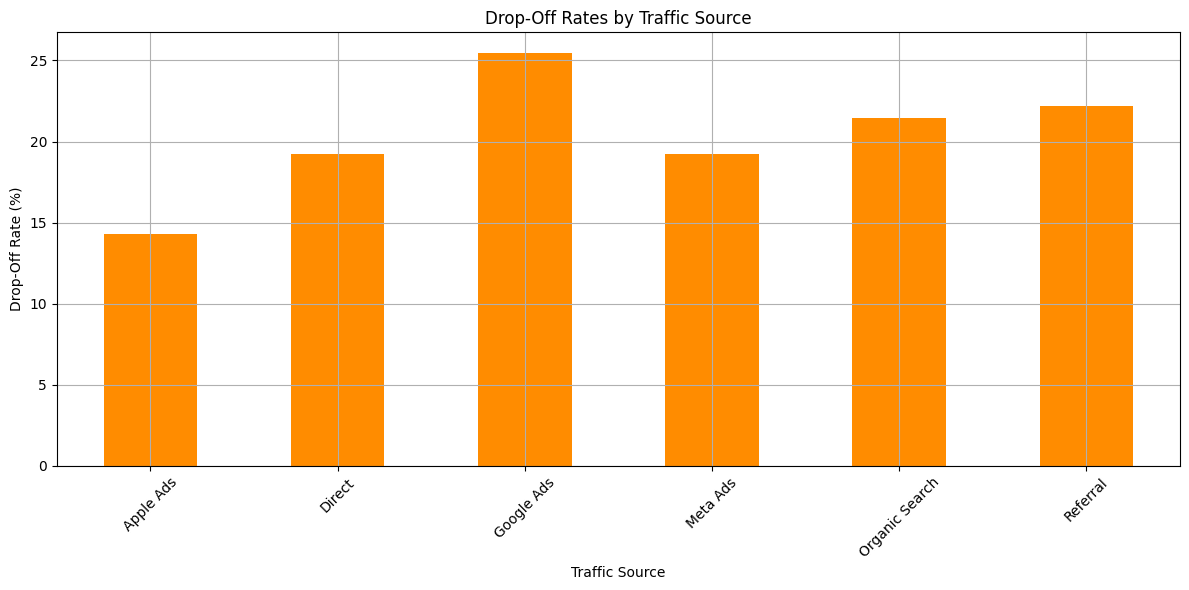

In [65]:
# Group by traffic source and calculate drop-off rates
drop_off_by_traffic = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('traffic_source')['patient_id'].nunique()
total_patients_by_traffic = merged_data.groupby('traffic_source')['patient_id'].nunique()
drop_off_rate_by_traffic = (drop_off_by_traffic / total_patients_by_traffic) * 100

# Visualize drop-off rates by traffic source
plt.figure(figsize=(12, 6))
drop_off_rate_by_traffic.plot(kind='bar', color='darkorange')
plt.title('Drop-Off Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Drop-Off Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3976619324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_appointments['event_datetime'] = pd.to_datetime(confirmed_appointments['event_datetime'])
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3976619324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_appointments['confirmation_date'] = confirmed_appointments['event_datetime'].dt.date


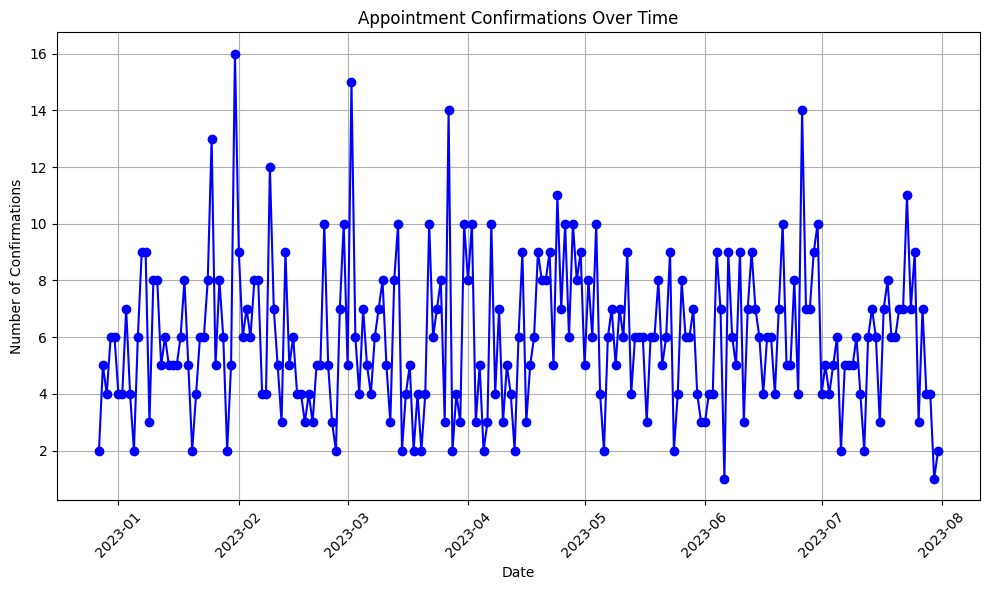

In [66]:
# Step 1: Filter for 'appointment_confirmed' events in both Test and Control groups
confirmed_appointments = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']

# Step 2: Convert event_datetime to datetime format
confirmed_appointments['event_datetime'] = pd.to_datetime(confirmed_appointments['event_datetime'])

# Step 3: Extract the date (or week) from event_datetime to group by day (or week)
confirmed_appointments['confirmation_date'] = confirmed_appointments['event_datetime'].dt.date

# Step 4: Group by the confirmation date and count the number of confirmations per day
confirmations_over_time = confirmed_appointments.groupby('confirmation_date')['patient_id'].count()

# Step 5: Visualize the confirmation trend over time
plt.figure(figsize=(10, 6))
confirmations_over_time.plot(kind='line', marker='o', linestyle='-', color='blue')
plt.title('Appointment Confirmations Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Confirmations')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


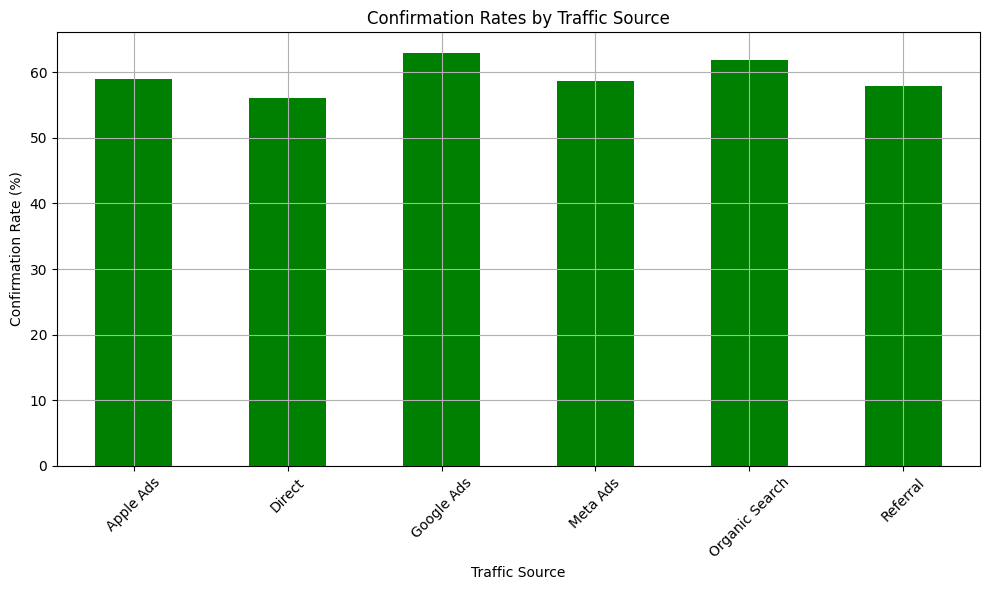

In [67]:

# Merge the data: ab_test_data with appointments_data and app_data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Step 1: Filter for 'appointment_confirmed' events
confirmed_data = merged_data[merged_data['event_name'] == 'appointment_confirmed']

# Step 2: Calculate the number of confirmed appointments per traffic source
confirmations_by_source = confirmed_data.groupby('traffic_source')['patient_id'].nunique()

# Step 3: Calculate the total number of patients per traffic source
total_patients_by_source = merged_data.groupby('traffic_source')['patient_id'].nunique()

# Step 4: Calculate confirmation rate by traffic source
confirmation_rate_by_source = (confirmations_by_source / total_patients_by_source) * 100

# Step 5: Visualize the confirmation rates by traffic source
confirmation_rate_by_source.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Confirmation Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Confirmation Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


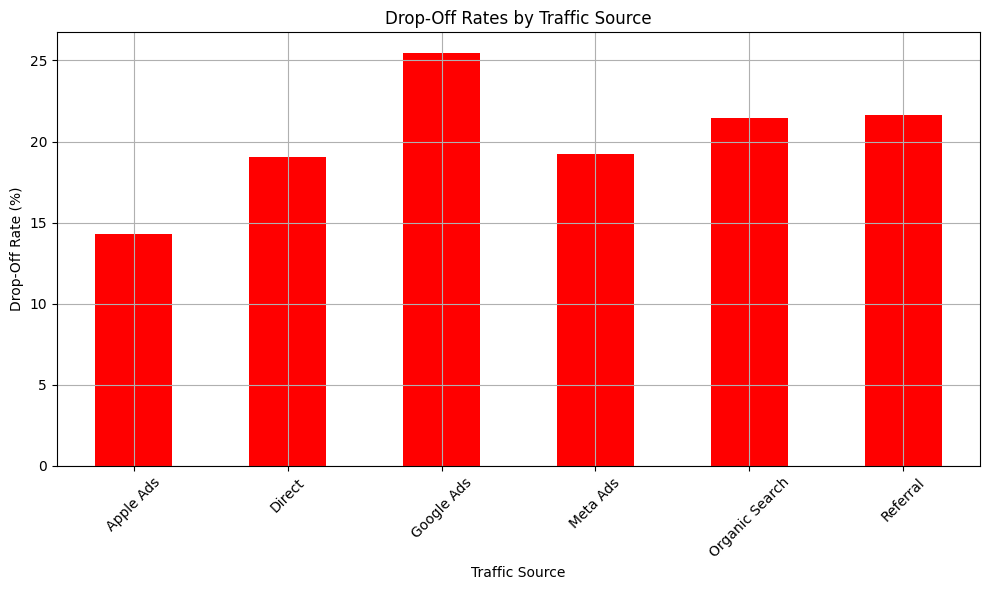

In [68]:

# Merge the data: ab_test_data with appointments_data and app_data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Step 1: Define drop-offs
# Drop-offs: Patients who were sent a reminder but did not confirm or attend the appointment
merged_data['drop_off'] = merged_data.apply(lambda x: 1 if (x['event_name'] == 'reminder_sent') and 
                                             (x['appointment_status'] != 'Attended') and 
                                             (x['event_name'] != 'appointment_confirmed') else 0, axis=1)

# Step 2: Group by traffic source and calculate total drop-offs and total patients
drop_offs_by_source = merged_data.groupby('traffic_source')['drop_off'].sum()
total_patients_by_source = merged_data.groupby('traffic_source')['patient_id'].nunique()

# Step 3: Calculate drop-off rate by traffic source
drop_off_rate_by_source = (drop_offs_by_source / total_patients_by_source) * 100

# Step 4: Visualize the drop-off rates by traffic source
drop_off_rate_by_source.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Drop-Off Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Drop-Off Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


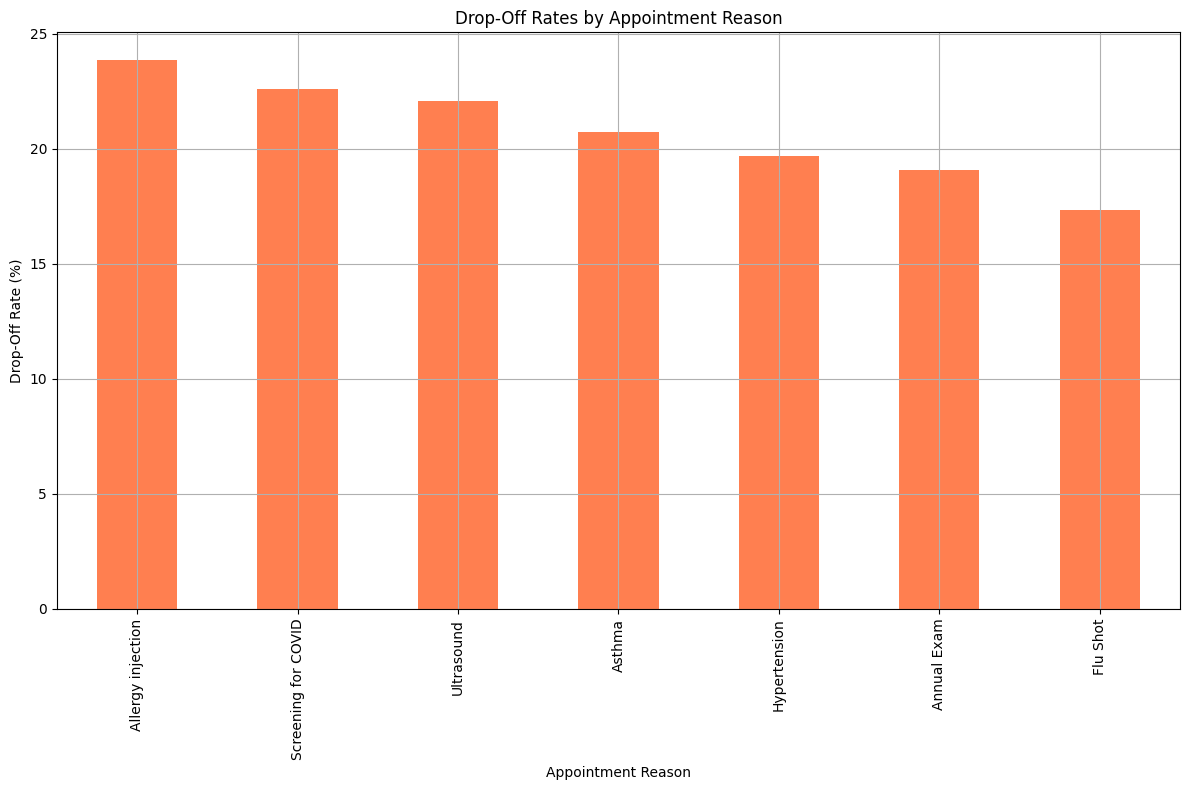

In [69]:
# Group by appointment reason and calculate attendance and drop-offs
attendance_by_reason = merged_data.groupby(['appointment_reason', 'appointment_status'])['patient_id'].nunique().unstack().fillna(0)

# Calculate drop-off rate as the percentage of patients who did not attend out of the total patients
attendance_by_reason['drop_off_rate'] = (attendance_by_reason['Not Attended'] / (attendance_by_reason['Attended'] + attendance_by_reason['Not Attended'])) * 100

# Visualize the drop-off rates by appointment reason
plt.figure(figsize=(12, 8))
attendance_by_reason['drop_off_rate'].sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Drop-Off Rates by Appointment Reason')
plt.xlabel('Appointment Reason')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


Control Group Attendance Rate: 100.0
Test Group Attendance Rate: 18.07555833855145
Control Group Counts: {'Total Control Group': 869, 'Attended Control Group': 869}
Test Group Counts: {'Total Test Group': 4791, 'Attended Test Group': 866}


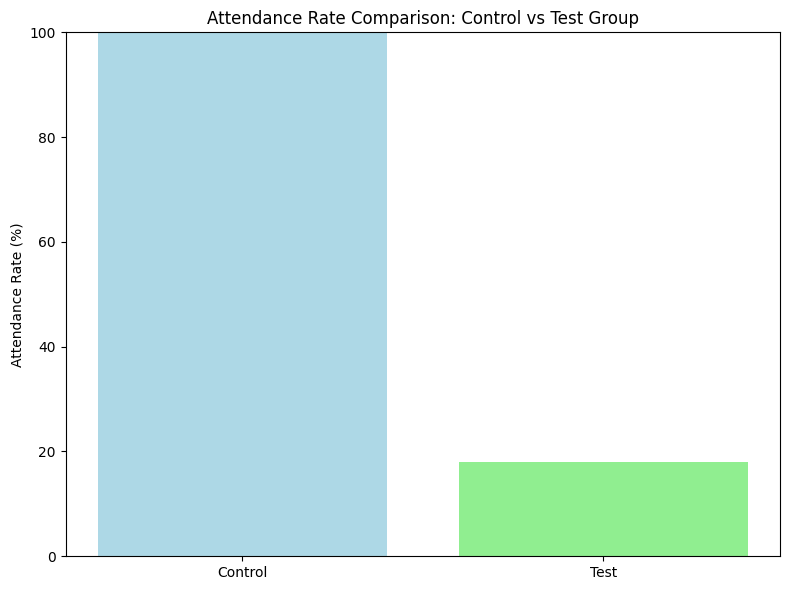

In [70]:
# Group the data
control_attended = ab_test_data[(ab_test_data['group'] == 'Control') & (ab_test_data['event_name'] == 'attended_appointment')]
test_attended = ab_test_data[(ab_test_data['group'] == 'Test') & (ab_test_data['event_name'] == 'attended_appointment')]

# Total number of entries in each group
total_control = ab_test_data[ab_test_data['group'] == 'Control'].shape[0]
total_test = ab_test_data[ab_test_data['group'] == 'Test'].shape[0]

# Number of attended appointments in each group
attended_control = control_attended.shape[0]
attended_test = test_attended.shape[0]

# Attendance rates
control_attendance_rate = (attended_control / total_control) * 100
test_attendance_rate = (attended_test / total_test) * 100

# Provide the counts for total and attended appointments in both groups
control_attendance_counts = {
    'Total Control Group': total_control,
    'Attended Control Group': attended_control
}

test_attendance_counts = {
    'Total Test Group': total_test,
    'Attended Test Group': attended_test
}

# Display the results
print("Control Group Attendance Rate:", control_attendance_rate)
print("Test Group Attendance Rate:", test_attendance_rate)

print("Control Group Counts:", control_attendance_counts)
print("Test Group Counts:", test_attendance_counts)

# Visualizing attendance rate comparison between Control and Test groups

# Data for visualization
groups = ['Control', 'Test']
attendance_rates = [control_attendance_rate, test_attendance_rate]

# Plotting the bar chart for attendance rates comparison
plt.figure(figsize=(8, 6))
plt.bar(groups, attendance_rates, color=['lightblue', 'lightgreen'])
plt.ylabel('Attendance Rate (%)')
plt.title('Attendance Rate Comparison: Control vs Test Group')
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.show()



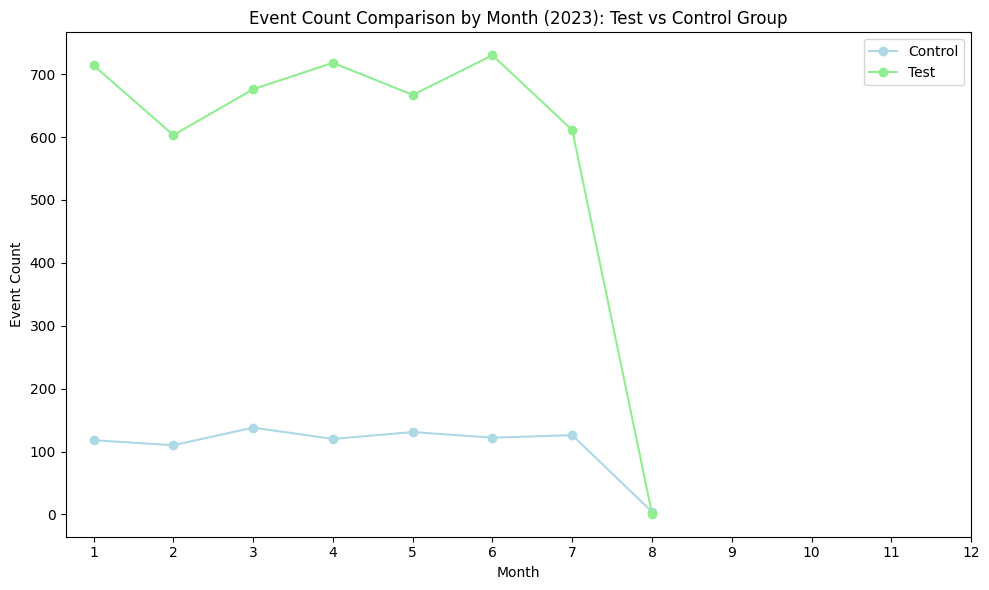

In [71]:
# Ensure 'event_datetime' is in datetime format
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Extract the year from the 'event_datetime' for time-based analysis
ab_test_data['year'] = ab_test_data['event_datetime'].dt.year
ab_test_data['month'] = ab_test_data['event_datetime'].dt.month

# Filter data for the year 2023
data_2023 = ab_test_data[ab_test_data['year'] == 2023]

# Grouping by 'group' and 'month' for 2023
monthly_data_2023 = data_2023.groupby(['group', 'month']).size().reset_index(name='count')

# Plotting comparison for Test and Control groups by month in 2023
plt.figure(figsize=(10, 6))

# Plotting for Control group
control_data_2023 = monthly_data_2023[monthly_data_2023['group'] == 'Control']
plt.plot(control_data_2023['month'], control_data_2023['count'], label='Control', marker='o', color='lightblue')

# Plotting for Test group
test_data_2023 = monthly_data_2023[monthly_data_2023['group'] == 'Test']
plt.plot(test_data_2023['month'], test_data_2023['count'], label='Test', marker='o', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Event Count Comparison by Month (2023): Test vs Control Group')
plt.xticks(range(1, 13))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


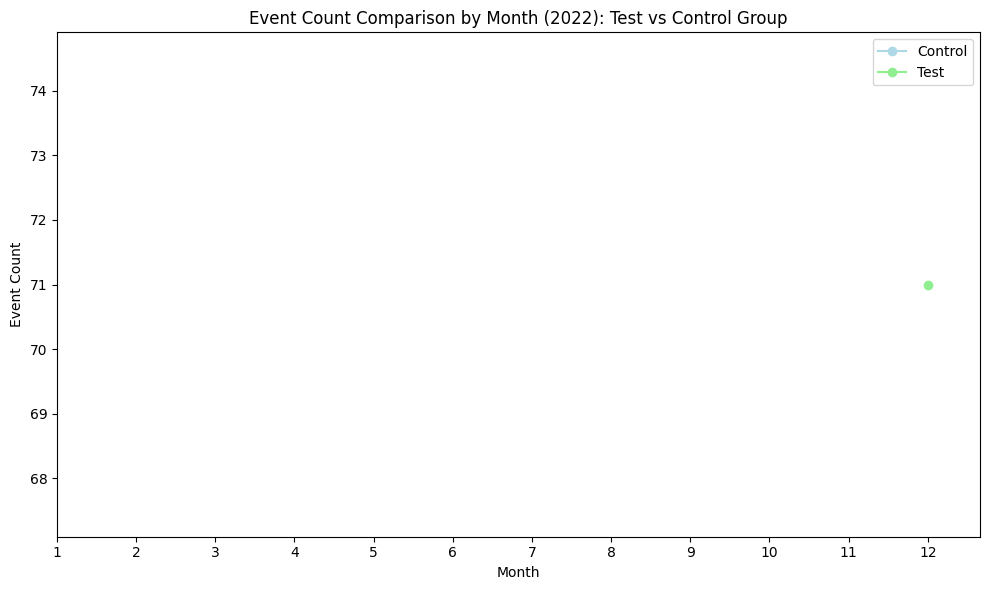

In [72]:
# Filter data for the year 2022
data_2022 = ab_test_data[ab_test_data['year'] == 2022]

# Grouping by 'group' and 'month' for 2022
monthly_data_2022 = data_2022.groupby(['group', 'month']).size().reset_index(name='count')

# Plotting comparison for Test and Control groups by month in 2022
plt.figure(figsize=(10, 6))

# Plotting for Control group
control_data_2022 = monthly_data_2022[monthly_data_2022['group'] == 'Control']
plt.plot(control_data_2022['month'], control_data_2022['count'], label='Control', marker='o', color='lightblue')

# Plotting for Test group
test_data_2022 = monthly_data_2022[monthly_data_2022['group'] == 'Test']
plt.plot(test_data_2022['month'], test_data_2022['count'], label='Test', marker='o', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Event Count Comparison by Month (2022): Test vs Control Group')
plt.xticks(range(1, 13))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


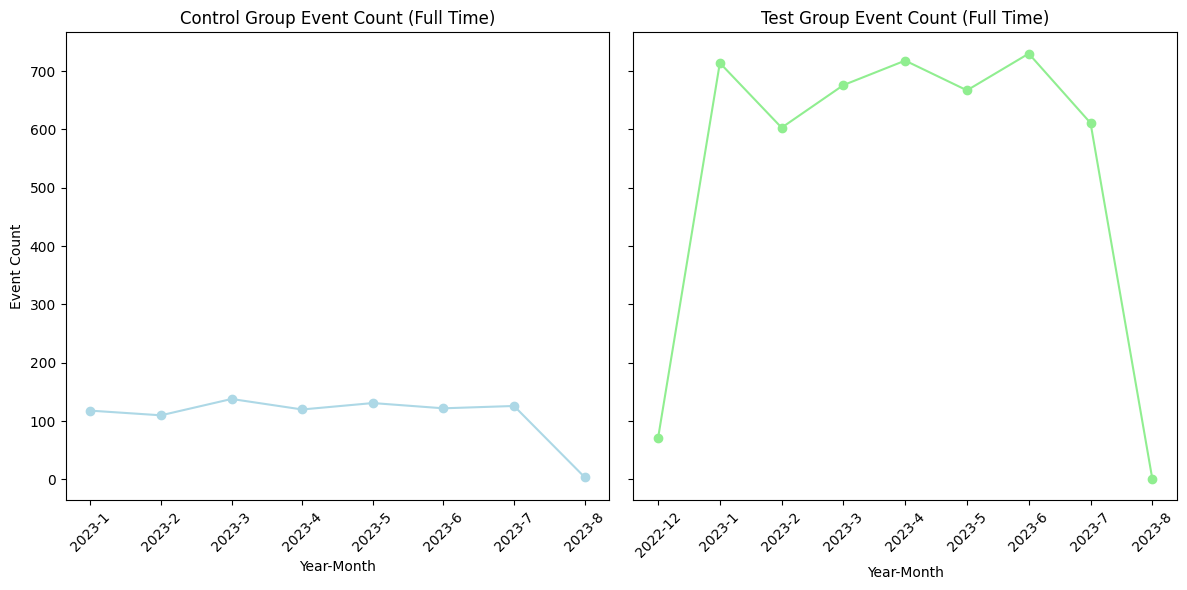

In [73]:
# Group the data by 'group', 'year', and 'month' to visualize the entire time span for Control and Test groups
full_time_data = ab_test_data.groupby(['group', 'year', 'month']).size().reset_index(name='count')

# Plot separate line charts for Control and Test groups for all available years and months
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Control group
control_full_time = full_time_data[full_time_data['group'] == 'Control']
axes[0].plot(control_full_time['year'].astype(str) + '-' + control_full_time['month'].astype(str), 
             control_full_time['count'], marker='o', color='lightblue')
axes[0].set_title('Control Group Event Count (Full Time)')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Event Count')
axes[0].set_xticks(control_full_time['year'].astype(str) + '-' + control_full_time['month'].astype(str))
axes[0].tick_params(axis='x', rotation=45)

# Test group
test_full_time = full_time_data[full_time_data['group'] == 'Test']
axes[1].plot(test_full_time['year'].astype(str) + '-' + test_full_time['month'].astype(str), 
             test_full_time['count'], marker='o', color='lightgreen')
axes[1].set_title('Test Group Event Count (Full Time)')
axes[1].set_xlabel('Year-Month')
axes[1].set_xticks(test_full_time['year'].astype(str) + '-' + test_full_time['month'].astype(str))
axes[1].tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout()
plt.show()


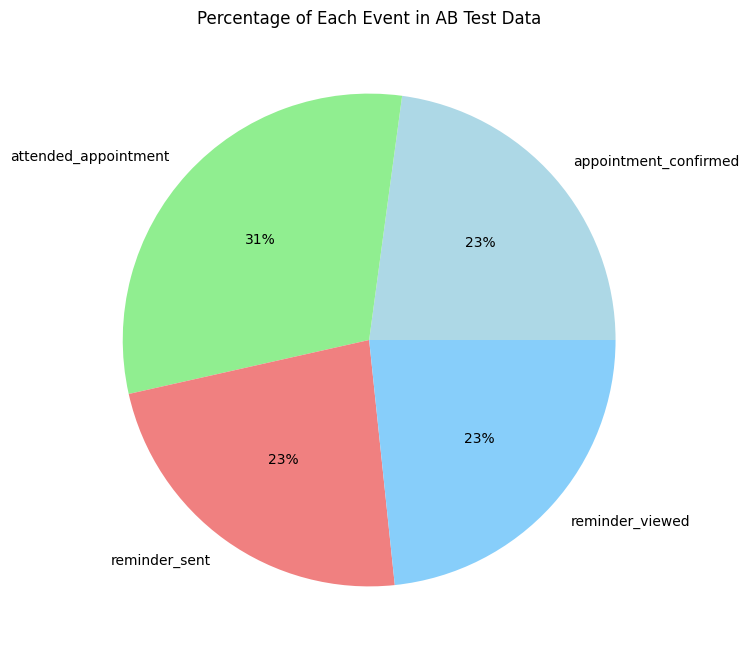

In [74]:
# Grouping by 'event_name' and calculating the count
grouped_ab_test_data = ab_test_data.groupby('event_name').size().reset_index(name='count')

# Calculate the percentage for each event
grouped_ab_test_data['percentage'] = (grouped_ab_test_data['count'] / grouped_ab_test_data['count'].sum()) * 100

# Plotting the pie chart with percentages for each event
plt.figure(figsize=(8, 8))
plt.pie(grouped_ab_test_data['percentage'], labels=grouped_ab_test_data['event_name'], autopct='%1.0f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Event in AB Test Data')

# Display the pie chart
plt.show()


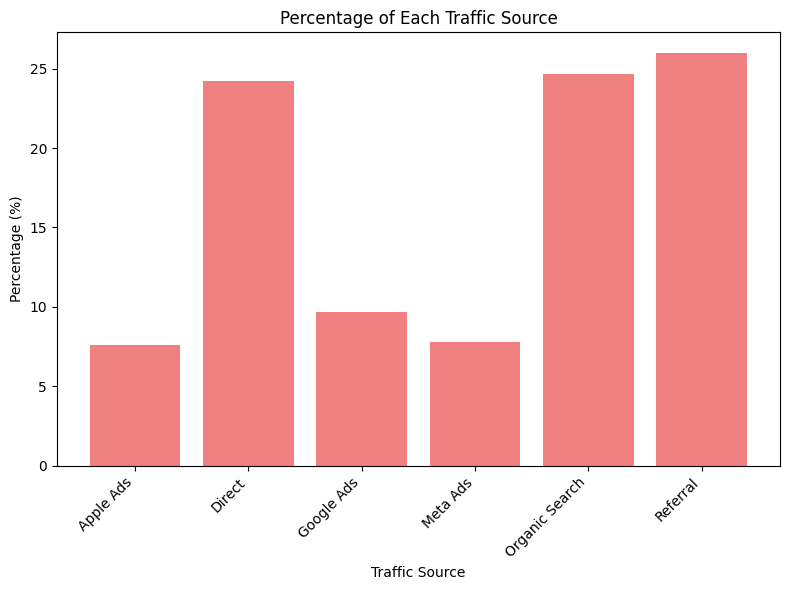

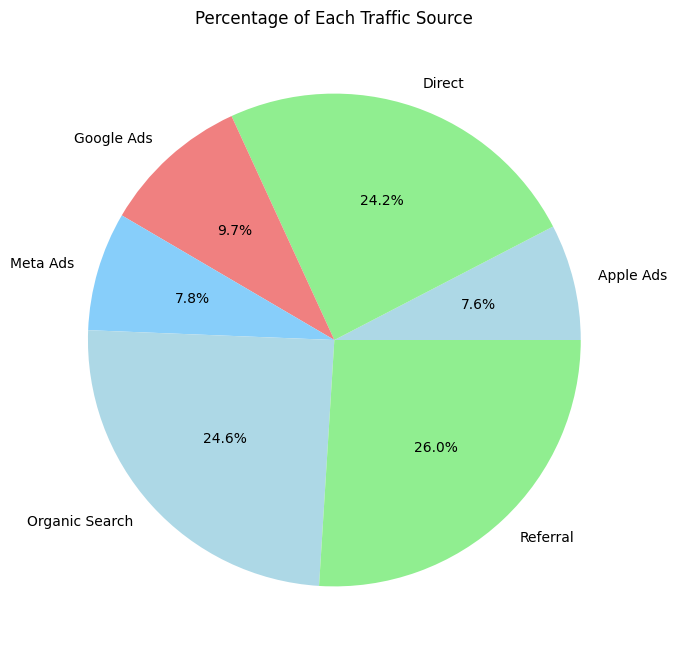

In [75]:
# Grouping the app_data by 'traffic_source' and calculating the count and percentages
grouped_traffic_source = app_data.groupby('traffic_source').size().reset_index(name='count')
grouped_traffic_source['percentage'] = (grouped_traffic_source['count'] / grouped_traffic_source['count'].sum()) * 100

# Plotting the bar chart for traffic source with percentages
plt.figure(figsize=(8, 6))
plt.bar(grouped_traffic_source['traffic_source'], grouped_traffic_source['percentage'], color='lightcoral')
plt.xlabel('Traffic Source')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Each Traffic Source')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the pie chart for traffic source
plt.figure(figsize=(8, 8))
plt.pie(grouped_traffic_source['percentage'], labels=grouped_traffic_source['traffic_source'], autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Traffic Source')
plt.show()


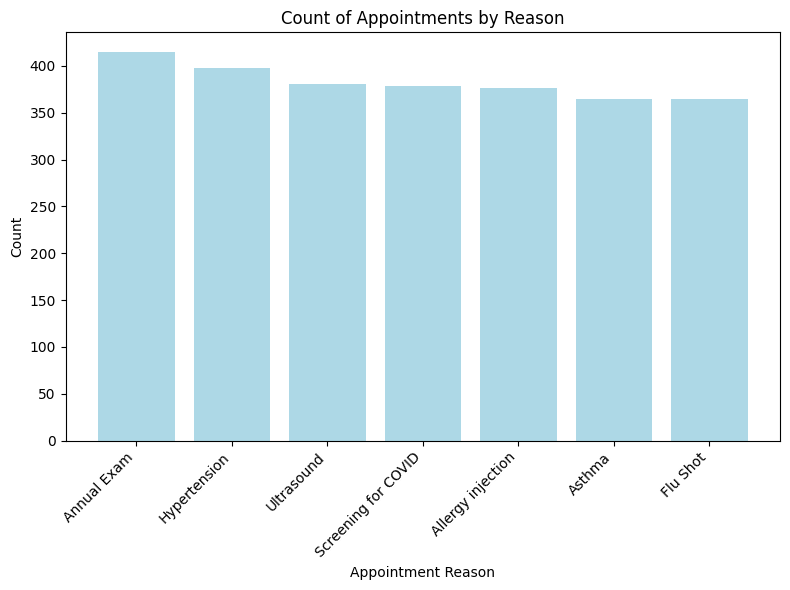

In [76]:
# Grouping by 'appointment_reason' and counting, then ordering by count from most to least
grouped_appointments = appointments_data.groupby('appointment_reason').size().reset_index(name='count')
grouped_appointments = grouped_appointments.sort_values(by='count', ascending=False)

grouped_appointments.reset_index(drop=True)
# Visualizing the appointment reason counts with a bar chart
plt.figure(figsize=(8, 6))
plt.bar(grouped_appointments['appointment_reason'], grouped_appointments['count'], color='lightblue')
plt.xlabel('Appointment Reason')
plt.ylabel('Count')
plt.title('Count of Appointments by Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


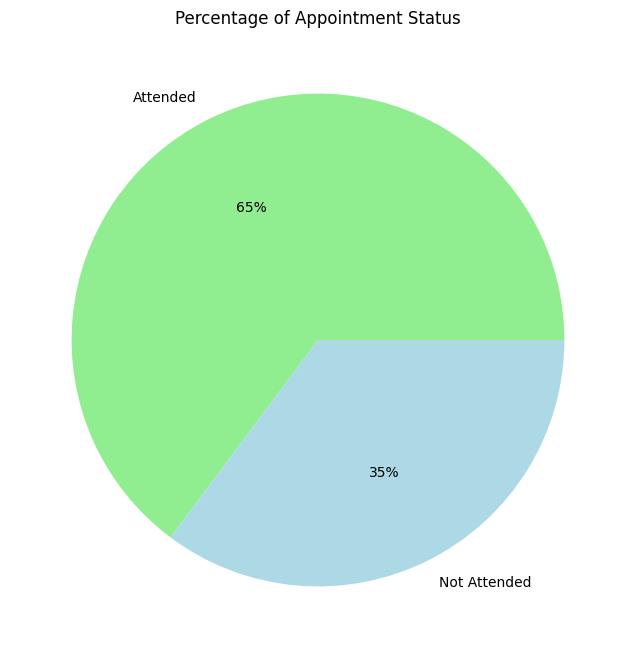

In [77]:
# Grouping by 'appointment_status' and counting, then ordering by count from highest to lowest
grouped_status = appointments_data.groupby('appointment_status').size().reset_index(name='count')
grouped_status = grouped_status.sort_values(by='count', ascending=False).reset_index(drop=True)

# Calculate the percentage for each appointment status
grouped_status['percentage'] = (grouped_status['count'] / grouped_status['count'].sum()) * 100

# Plotting the pie chart with percentages for appointment status
plt.figure(figsize=(8, 8))
plt.pie(grouped_status['percentage'], labels=grouped_status['appointment_status'], autopct='%1.0f%%', colors=['lightgreen', 'lightblue'])
plt.title('Percentage of Appointment Status')

# Display the pie chart
plt.show()


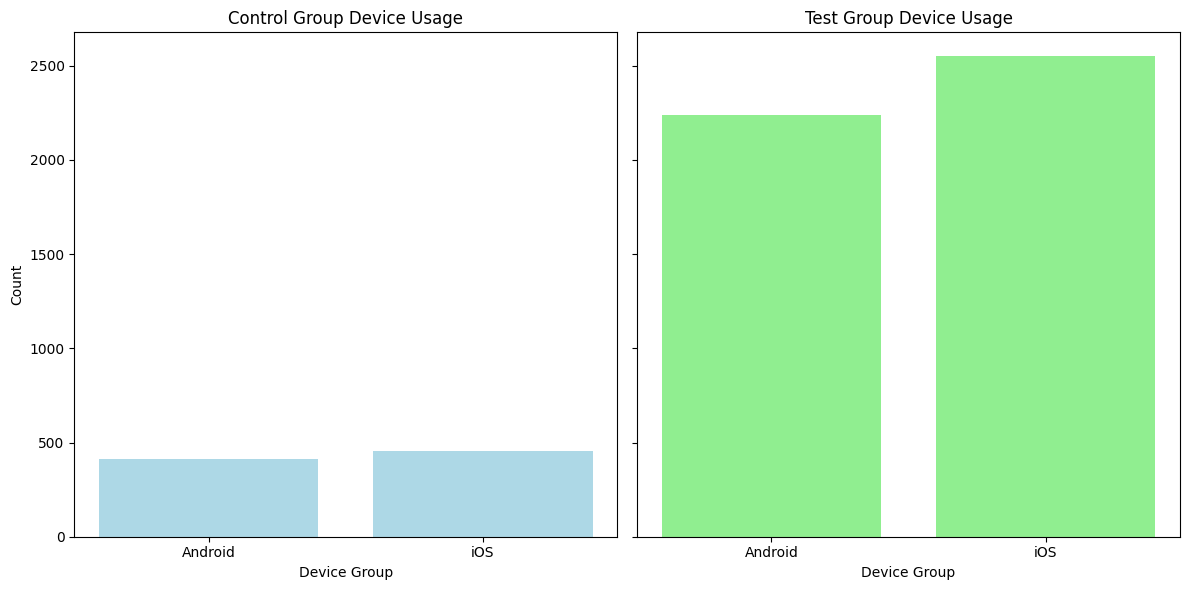

In [78]:
# Group devices into Android and iOS
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'Android' if 'android' in x else 'iOS')

# Grouping by 'group' and 'device_group' to get the counts for Control and Test groups
device_group_counts = merged_data.groupby(['group', 'device_group']).size().reset_index(name='count')

# Separate data for Control and Test groups
control_devices_grouped = device_group_counts[device_group_counts['group'] == 'Control']
test_devices_grouped = device_group_counts[device_group_counts['group'] == 'Test']

# Plotting separate bar charts for Control and Test groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Control group plot
axes[0].bar(control_devices_grouped['device_group'], control_devices_grouped['count'], color='lightblue')
axes[0].set_title('Control Group Device Usage')
axes[0].set_xlabel('Device Group')
axes[0].set_ylabel('Count')

# Test group plot
axes[1].bar(test_devices_grouped['device_group'], test_devices_grouped['count'], color='lightgreen')
axes[1].set_title('Test Group Device Usage')
axes[1].set_xlabel('Device Group')

# Display the plots
plt.tight_layout()
plt.show()


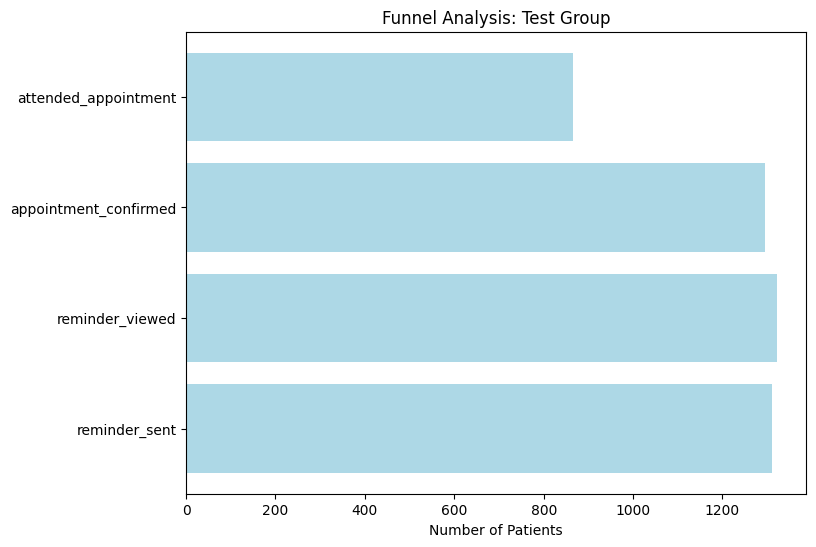

In [79]:
funnel = merged_data[merged_data['group'] == 'Test']
funnel_stages = funnel['event_name'].value_counts()

# Plot funnel
stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
values = [funnel_stages[stage] if stage in funnel_stages else 0 for stage in stages]

plt.figure(figsize=(8, 6))
plt.barh(stages, values, color='lightblue')
plt.xlabel('Number of Patients')
plt.title('Funnel Analysis: Test Group')
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/2522552422.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100


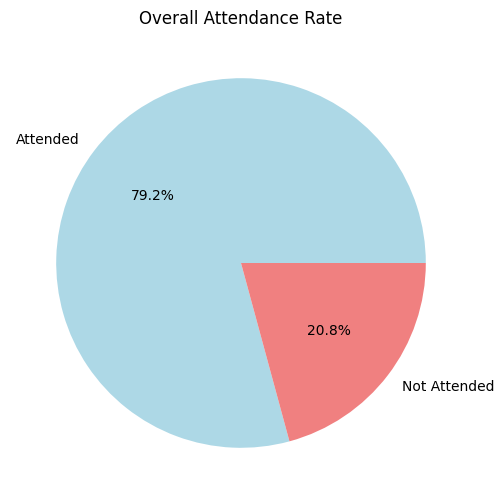

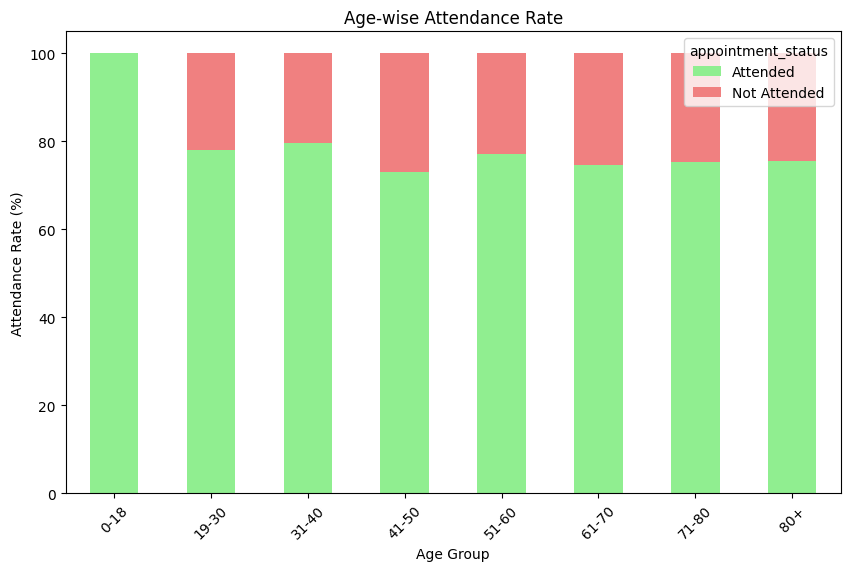

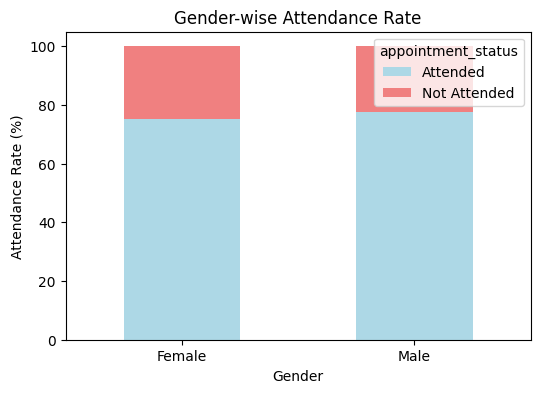

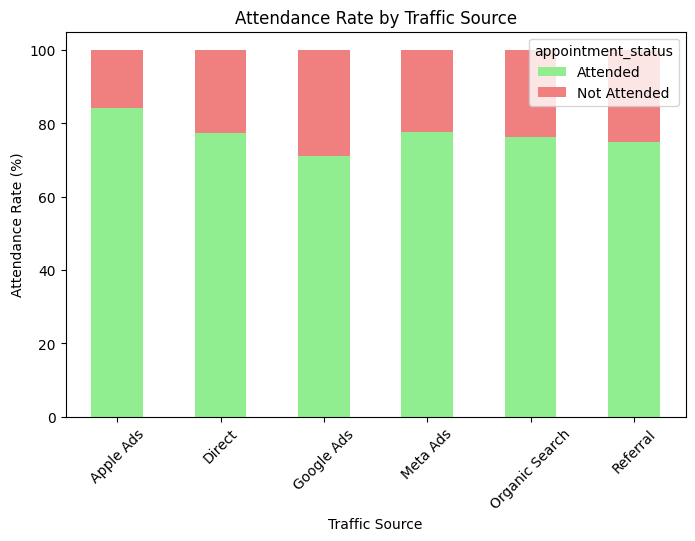

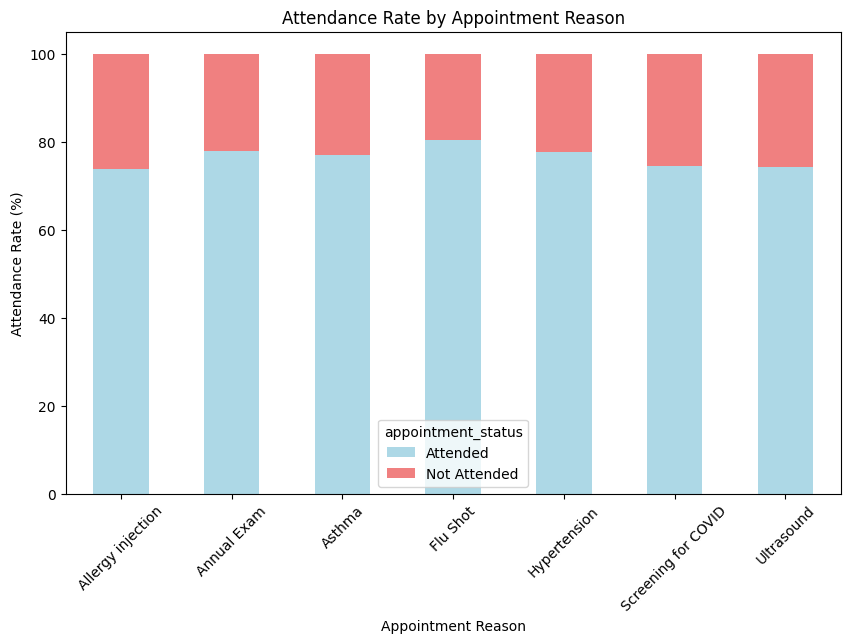

In [80]:

# Load the necessary data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Attendance rate
attended = merged_data[merged_data['appointment_status'] == 'Attended']['patient_id'].nunique()
total_patients = merged_data['patient_id'].nunique()
attendance_rate = (attended / total_patients) * 100

# Age-wise attendance rate
age_analysis = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Gender-wise attendance rate
gender_analysis = merged_data.groupby('gender')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Traffic source-wise attendance rate
traffic_source_analysis = merged_data.groupby('traffic_source')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Appointment reason-wise attendance rate
appointment_reason_analysis = merged_data.groupby('appointment_reason')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Visualization

# Overall attendance rate
plt.figure(figsize=(6, 6))
plt.pie([attendance_rate, 100 - attendance_rate], labels=['Attended', 'Not Attended'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Overall Attendance Rate')
plt.show()

# Age-wise attendance rate visualization
age_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgreen', 'lightcoral'])
plt.title('Age-wise Attendance Rate')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.show()

# Gender-wise attendance rate visualization
gender_analysis.plot(kind='bar', stacked=True, figsize=(6, 4), color=['lightblue', 'lightcoral'])
plt.title('Gender-wise Attendance Rate')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.show()

# Traffic source-wise attendance rate visualization
traffic_source_analysis.plot(kind='bar', stacked=True, figsize=(8, 5), color=['lightgreen', 'lightcoral'])
plt.title('Attendance Rate by Traffic Source')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Traffic Source')
plt.xticks(rotation=45)
plt.show()

# Appointment reason-wise attendance rate visualization
appointment_reason_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title('Attendance Rate by Appointment Reason')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Appointment Reason')
plt.xticks(rotation=45)
plt.show()


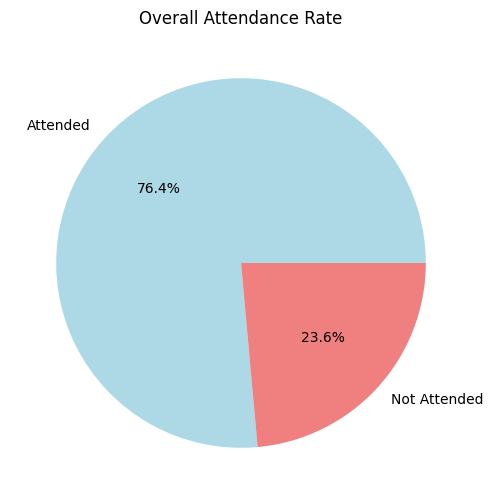

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/688033264.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_attendance = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)


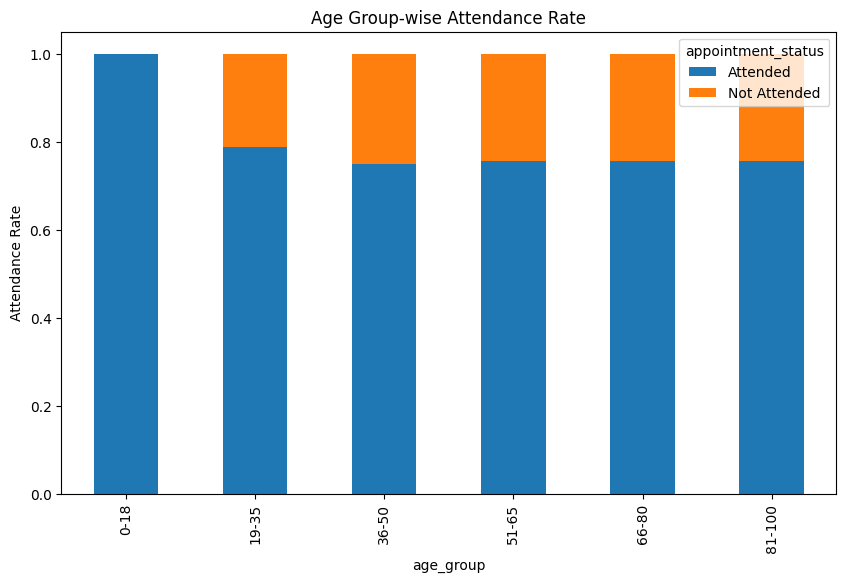

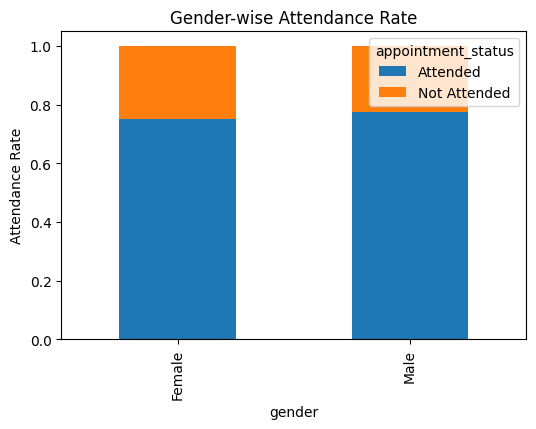

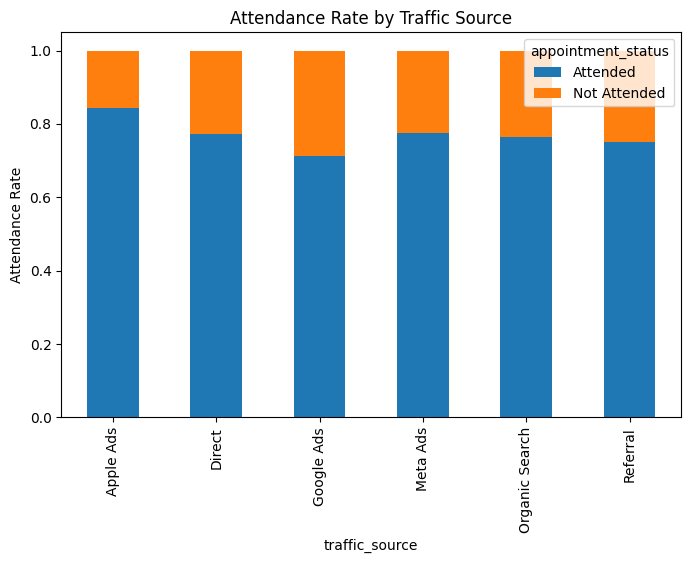

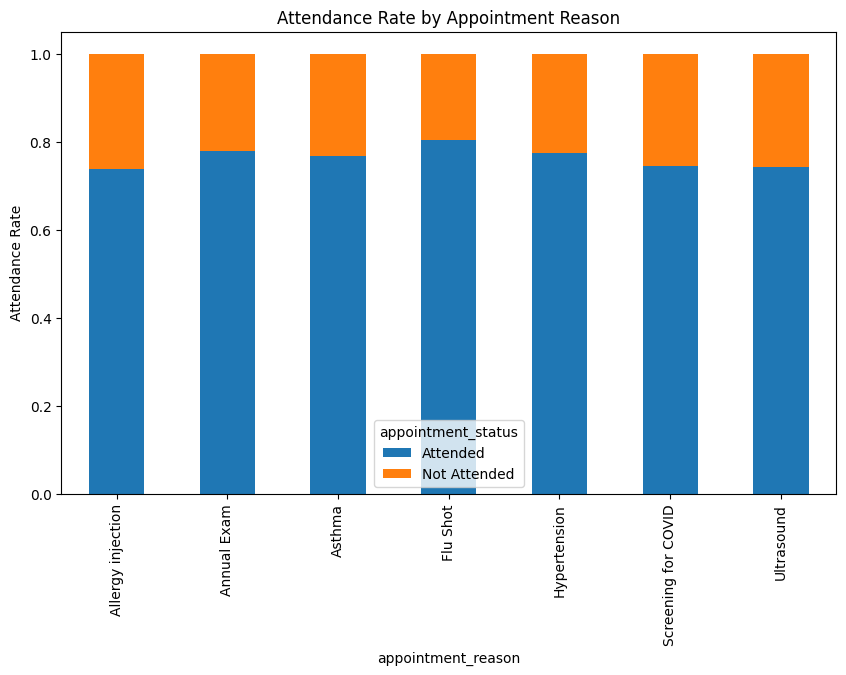

In [81]:

# Load the datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Define age groups and create a new 'age_group' column
bins = [0, 18, 35, 50, 65, 80, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-100']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Calculate attendance rate for overall data
attendance_rate = merged_data['appointment_status'].value_counts(normalize=True)['Attended'] * 100

# Visualize overall attendance rate
plt.figure(figsize=(6, 6))
plt.pie([attendance_rate, 100 - attendance_rate], labels=['Attended', 'Not Attended'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Overall Attendance Rate')
plt.show()

# Group by age group and appointment status
age_group_attendance = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)

# Visualize age group attendance rates
age_group_attendance.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Age Group-wise Attendance Rate')
plt.ylabel('Attendance Rate')
plt.show()

# Group by gender and appointment status
gender_analysis = merged_data.groupby('gender')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)

# Visualize gender-wise attendance rates
gender_analysis.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Gender-wise Attendance Rate')
plt.ylabel('Attendance Rate')
plt.show()

# Group by traffic source and appointment status
traffic_source_analysis = merged_data.groupby('traffic_source')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)

# Visualize traffic source-wise attendance rates
traffic_source_analysis.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Attendance Rate by Traffic Source')
plt.ylabel('Attendance Rate')
plt.show()

# Group by appointment reason and appointment status
appointment_reason_analysis = merged_data.groupby('appointment_reason')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)

# Visualize appointment reason-wise attendance rates
appointment_reason_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Attendance Rate by Appointment Reason')
plt.ylabel('Attendance Rate')
plt.show()


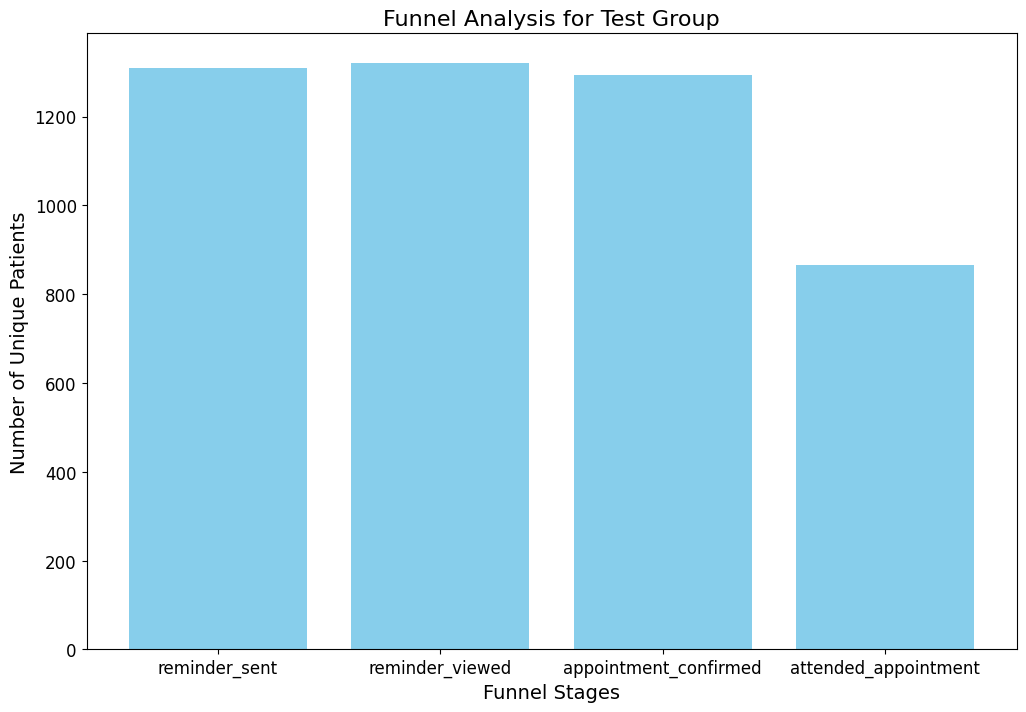

In [82]:
# Load actual dataset
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for Test group only
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Define the funnel stages
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter for relevant stages and group by event_name to count unique patient_id's at each stage
funnel_counts = test_group[test_group['event_name'].isin(funnel_stages)]\
    .groupby('event_name')['patient_id'].nunique().reindex(funnel_stages)

# Visualization - Extended size funnel plot
plt.figure(figsize=(12, 8))  # Extended figure size for larger plot
plt.bar(funnel_counts.index, funnel_counts.values, color='skyblue')
plt.xlabel('Funnel Stages', fontsize=14)
plt.ylabel('Number of Unique Patients', fontsize=14)
plt.title('Funnel Analysis for Test Group', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


traffic_source
Apple Ads         138
Direct            433
Google Ads        161
Meta Ads          143
Organic Search    414
Referral          446
Name: patient_id, dtype: int64


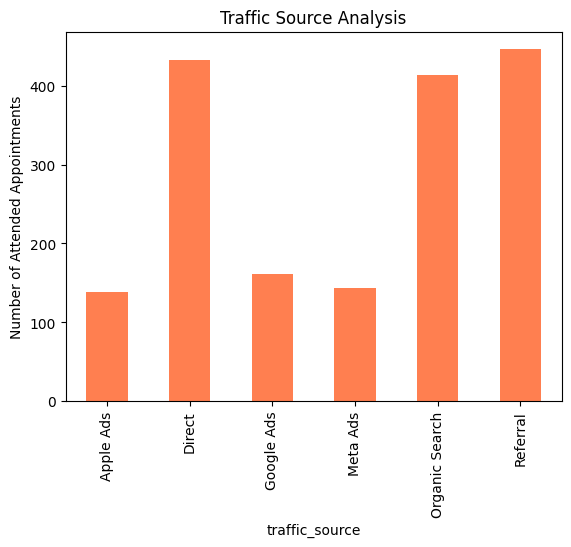

In [83]:
# Merge app_data with appointments_data to analyze traffic sources
merged_data = pd.merge(app_data, appointments_data, on='patient_id')

# Group by traffic source and count attended appointments
traffic_source_analysis = merged_data[merged_data['appointment_status'] == 'Attended'] \
    .groupby('traffic_source')['patient_id'].nunique()

print(traffic_source_analysis)

# Plot the results
traffic_source_analysis.plot(kind='bar', color='coral')
plt.title('Traffic Source Analysis')
plt.ylabel('Number of Attended Appointments')
plt.show()


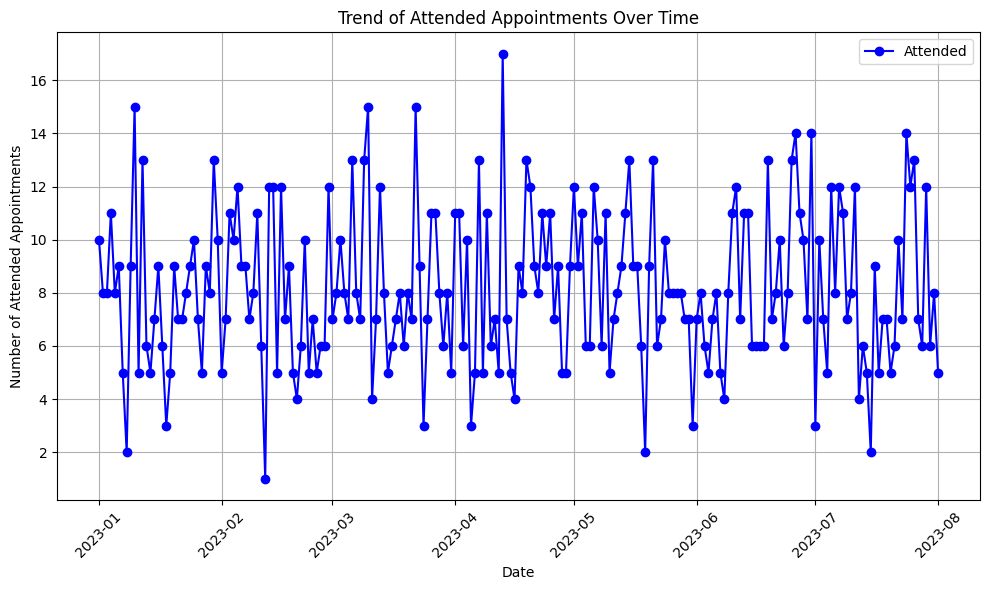

In [84]:
# Load the appointments data
appointments_data = pd.read_csv('data/appointments_data.csv')

# Convert appointment_date to datetime format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Calculate the trend of attended appointments over time
attended_trend = appointments_data[appointments_data['appointment_status'] == 'Attended']\
    .groupby('appointment_date').size()

# Plot the line chart for attended appointments over time
plt.figure(figsize=(10, 6))
plt.plot(attended_trend.index, attended_trend.values, marker='o', linestyle='-', color='blue', label='Attended')
plt.xlabel('Date')
plt.ylabel('Number of Attended Appointments')
plt.title('Trend of Attended Appointments Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()



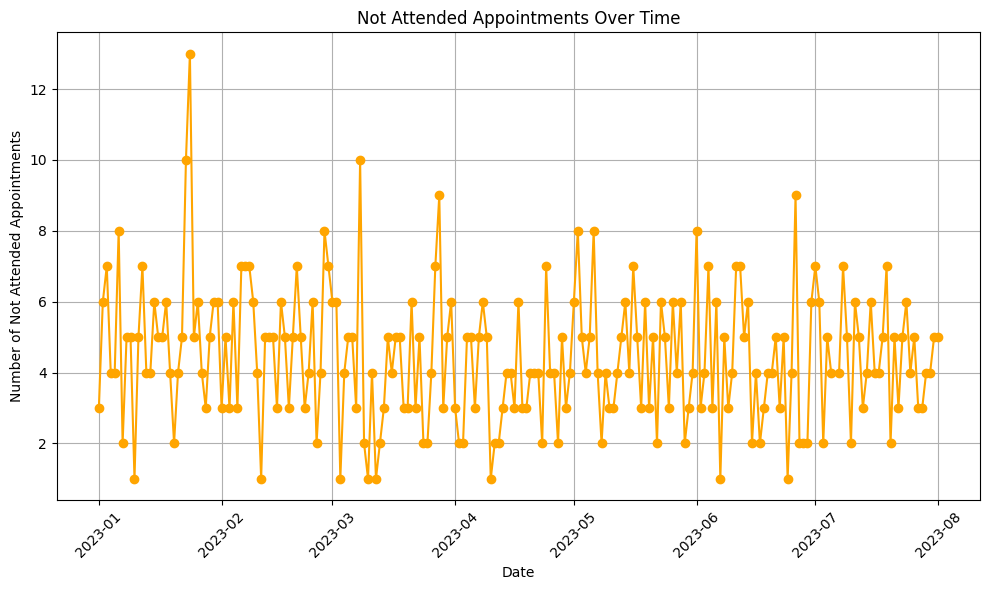

In [85]:

# First, calculate the number of not attended appointments over time
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Filter for not attended appointments
not_attended_data = appointments_data[appointments_data['appointment_status'] != 'Attended']

# Group by appointment date to count not attended appointments
not_attended_over_time = not_attended_data.groupby('appointment_date').size()

# Plotting the line chart for non-attended appointments over time
plt.figure(figsize=(10, 6))
plt.plot(not_attended_over_time.index, not_attended_over_time.values, label="Not Attended", color='orange', marker='o')
plt.title('Not Attended Appointments Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Not Attended Appointments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


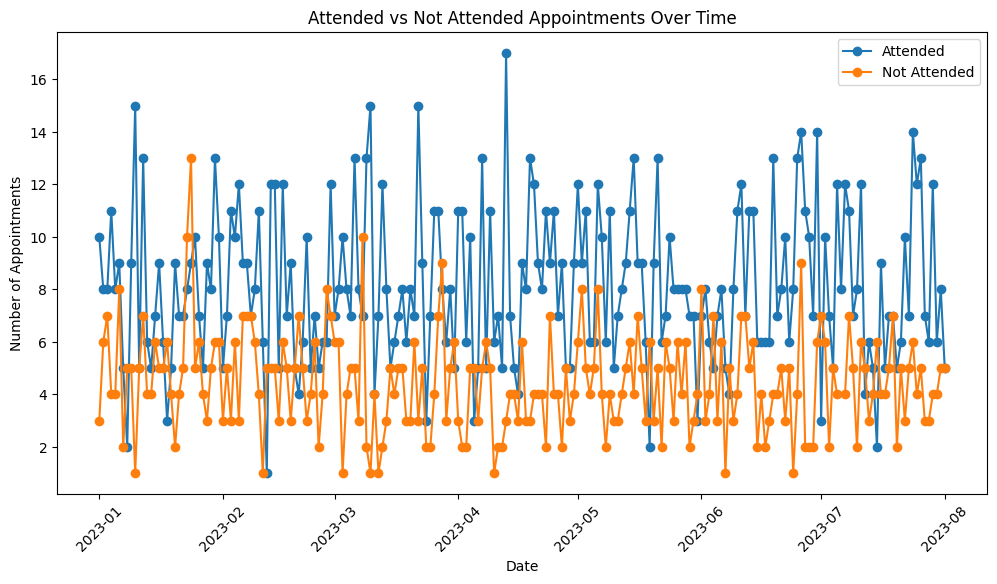

In [86]:
# Grouping by appointment_date and counting attended and not attended appointments
attended_by_date = appointments_data[appointments_data['appointment_status'] == 'Attended'].groupby('appointment_date').size()
not_attended_by_date = appointments_data[appointments_data['appointment_status'] != 'Attended'].groupby('appointment_date').size()

# Creating a chart with both attended and not attended counts over time
plt.figure(figsize=(12, 6))

# Plot for attended appointments
plt.plot(attended_by_date.index, attended_by_date, label='Attended', marker='o')

# Plot for not attended appointments
plt.plot(not_attended_by_date.index, not_attended_by_date, label='Not Attended', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of Appointments')
plt.title('Attended vs Not Attended Appointments Over Time')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.show()


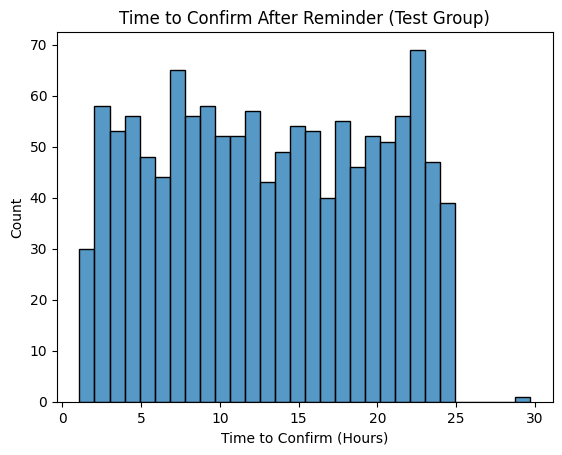

In [87]:
# Merge A/B Test Data with Appointments Data
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Ensure 'event_datetime' is in datetime format
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'])
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Filter Test group data
test_group = merged_data[merged_data['group'] == 'Test']

# Identify the reminder_sent and appointment_confirmed events for each patient
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Merge to calculate time difference between reminder_sent and appointment_confirmed
reminder_confirmed = pd.merge(reminder_sent[['patient_id', 'event_datetime']],
                              appointment_confirmed[['patient_id', 'event_datetime']],
                              on='patient_id',
                              suffixes=('_reminder_sent', '_appointment_confirmed'))

# Calculate the time difference in hours
reminder_confirmed['time_to_confirm'] = (reminder_confirmed['event_datetime_appointment_confirmed'] - 
                                         reminder_confirmed['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Plot the distribution of time to confirm after reminder
sns.histplot(reminder_confirmed['time_to_confirm'], bins=30)
plt.title('Time to Confirm After Reminder (Test Group)')
plt.xlabel('Time to Confirm (Hours)')
plt.show()

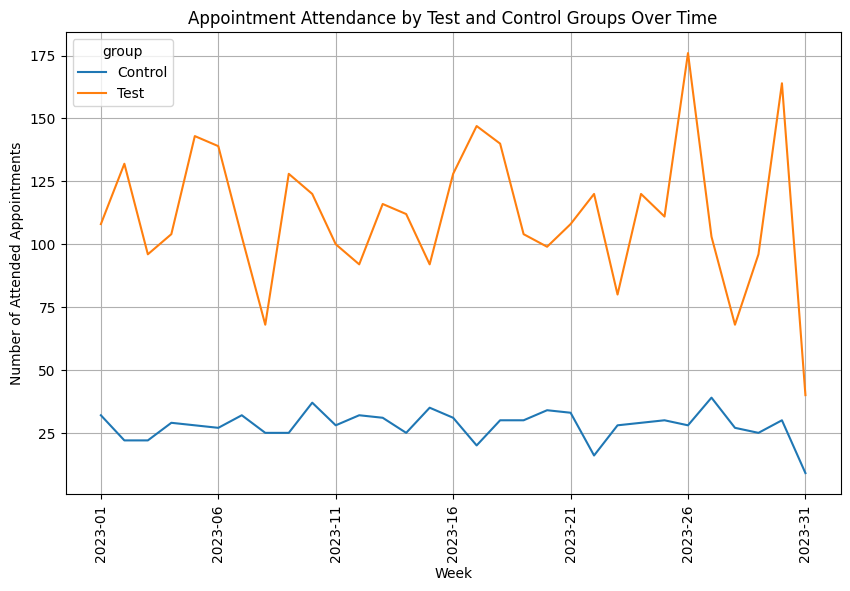

In [88]:
# Ensure 'appointment_date' is in datetime format
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Create a 'year-week' column to group by week
merged_data['year_week'] = merged_data['appointment_date'].dt.strftime('%Y-%U')

# Count attended appointments by group over time (weekly)
attendance_over_time = merged_data[merged_data['appointment_status'] == 'Attended'].groupby(['year_week', 'group'])['patient_id'].count().unstack()

# Plot the attendance rate over time for both groups
attendance_over_time.plot(figsize=(10, 6))
plt.title('Appointment Attendance by Test and Control Groups Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Attended Appointments')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


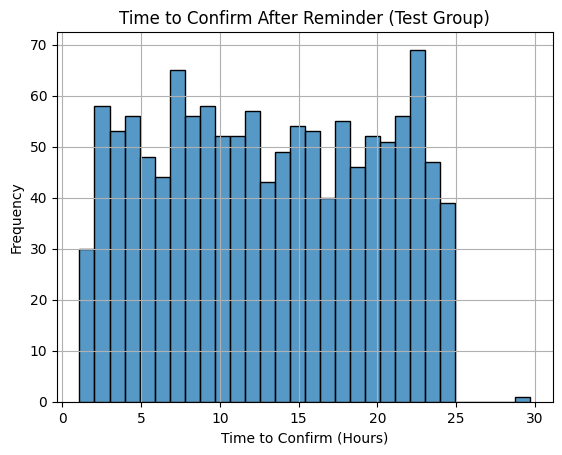

In [89]:
# Ensure 'event_datetime' is in datetime format
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'])

# Filter for Test group and necessary events
test_group = merged_data[merged_data['group'] == 'Test']
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Merge on patient_id to calculate time between reminder_sent and appointment_confirmed
reminder_confirmed = pd.merge(reminder_sent[['patient_id', 'event_datetime']],
                              appointment_confirmed[['patient_id', 'event_datetime']],
                              on='patient_id',
                              suffixes=('_reminder_sent', '_appointment_confirmed'))

# Calculate the time difference in hours
reminder_confirmed['time_to_confirm'] = (reminder_confirmed['event_datetime_appointment_confirmed'] - 
                                         reminder_confirmed['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Plot the distribution of confirmation times
sns.histplot(reminder_confirmed['time_to_confirm'], bins=30)
plt.title('Time to Confirm After Reminder (Test Group)')
plt.xlabel('Time to Confirm (Hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


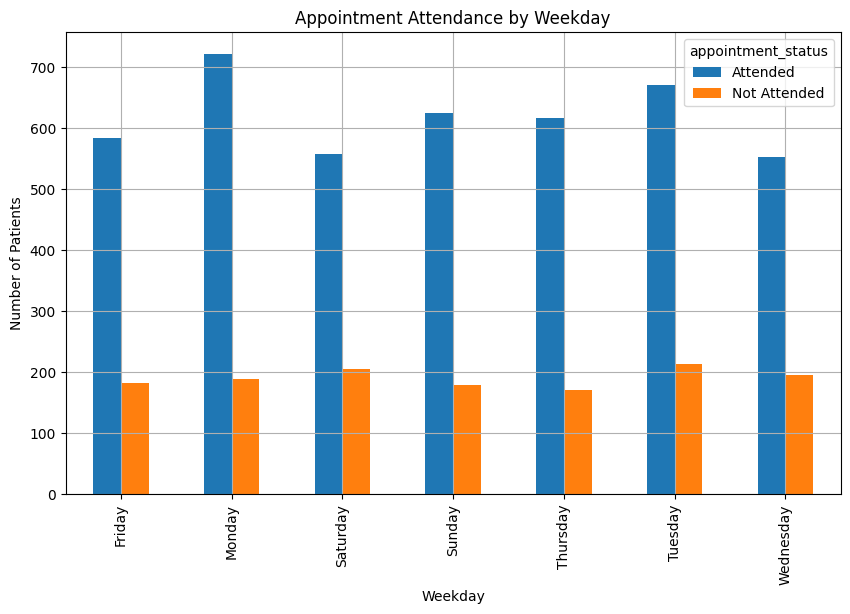

In [90]:
# Extract the weekday from the appointment date
merged_data['weekday'] = merged_data['appointment_date'].dt.day_name()

# Group by weekday and appointment status
attendance_by_weekday = merged_data.groupby(['weekday', 'appointment_status'])['patient_id'].count().unstack()

# Plot attendance vs. non-attendance by weekday
attendance_by_weekday.plot(kind='bar', figsize=(10, 6))
plt.title('Appointment Attendance by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


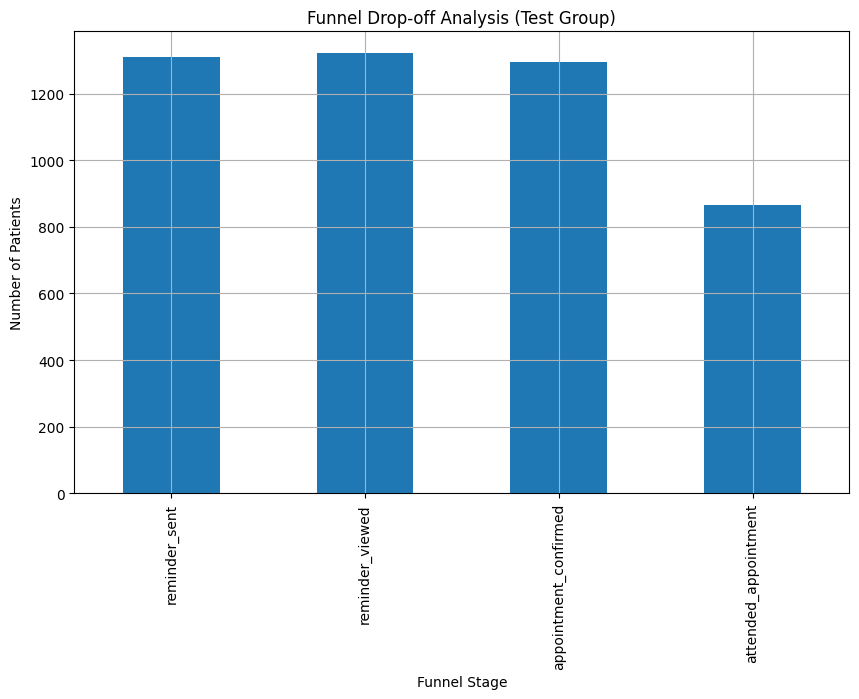

In [91]:
# Define funnel stages
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter Test group data for funnel stages
funnel_data = test_group[test_group['event_name'].isin(funnel_stages)]

# Group by event name to count unique patient_id at each funnel stage
funnel_counts = funnel_data.groupby('event_name')['patient_id'].nunique().reindex(funnel_stages)

# Plot the funnel
funnel_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Funnel Drop-off Analysis (Test Group)')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


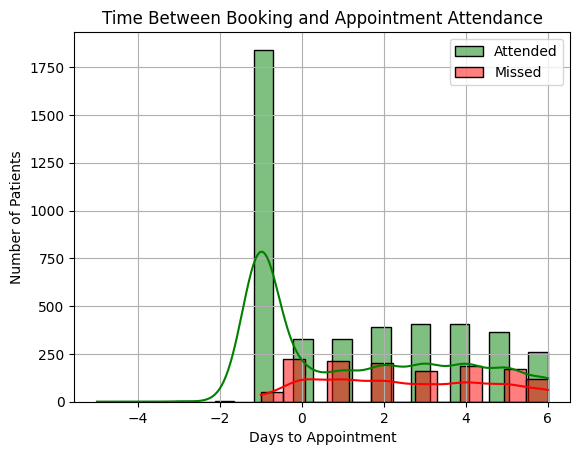

In [92]:
# Calculate the difference between appointment_date and event_datetime for appointment booking
merged_data['time_to_appointment'] = (merged_data['appointment_date'] - merged_data['event_datetime']).dt.days

# Filter for attended and missed appointments
attended_data = merged_data[merged_data['appointment_status'] == 'Attended']
missed_data = merged_data[merged_data['appointment_status'] != 'Attended']

# Plot the time to appointment for both attended and missed appointments
sns.histplot(attended_data['time_to_appointment'], color='green', label='Attended', kde=True)
sns.histplot(missed_data['time_to_appointment'], color='red', label='Missed', kde=True)
plt.title('Time Between Booking and Appointment Attendance')
plt.xlabel('Days to Appointment')
plt.ylabel('Number of Patients')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/1088639237.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()


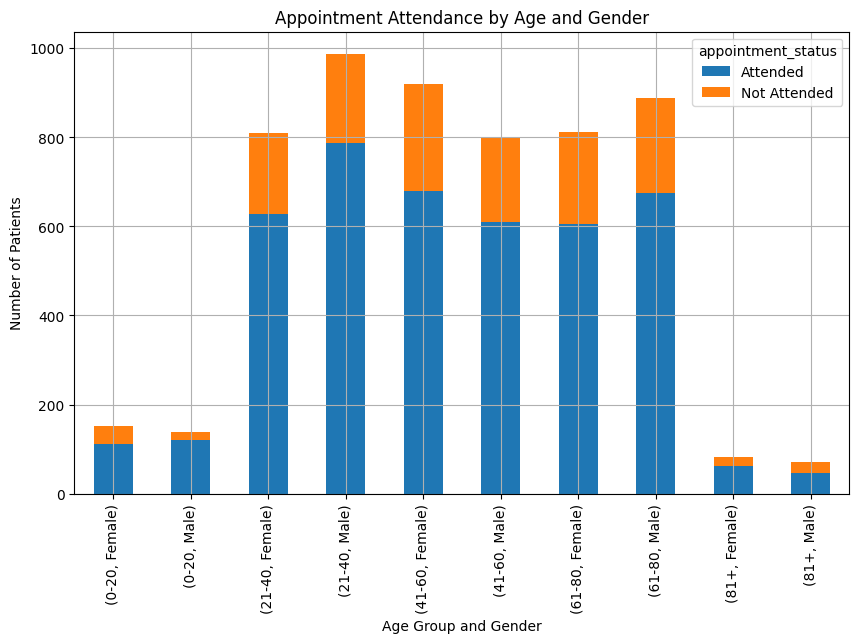

In [93]:
# Create age groups
merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Group by age group, gender, and appointment status
attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()

# Plot the attendance rates by age and gender
attendance_by_age_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Age and Gender')
plt.xlabel('Age Group and Gender')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3525221404.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()


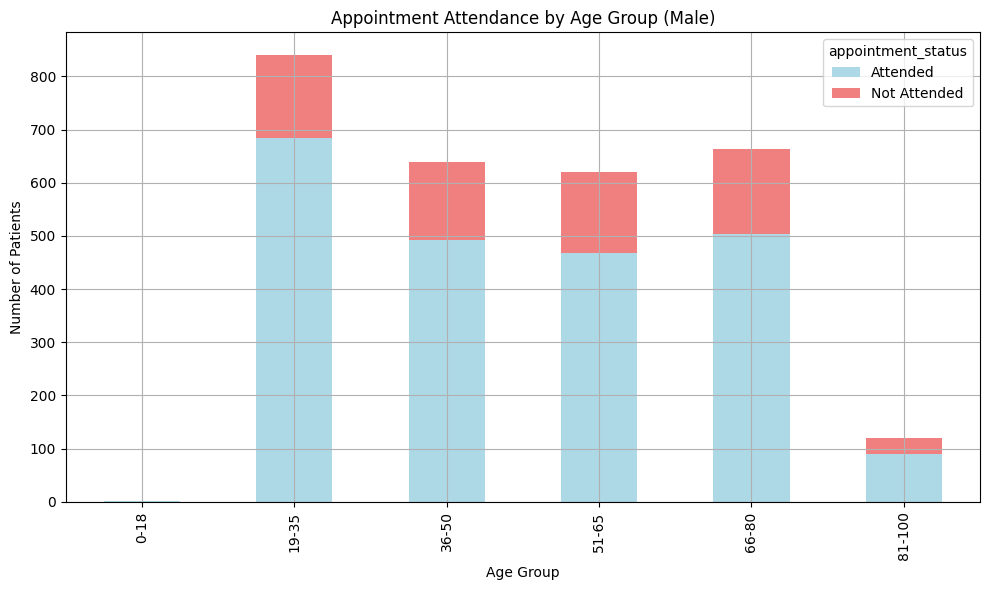

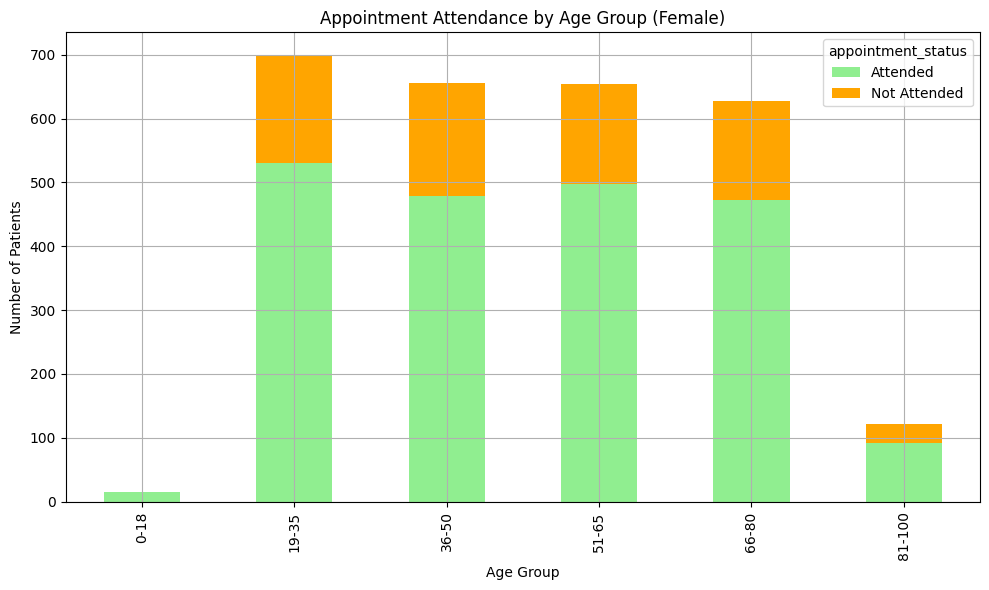

In [94]:

ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Define age groups and create a new 'age_group' column
bins = [0, 18, 35, 50, 65, 80, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-100']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Group the data by age group, gender, and appointment status
attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()

# Separate the data by gender
attendance_by_age_male = attendance_by_age_gender.xs('Male', level='gender')
attendance_by_age_female = attendance_by_age_gender.xs('Female', level='gender')

# Plot for Male
attendance_by_age_male.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title('Appointment Attendance by Age Group (Male)')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Female
attendance_by_age_female.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgreen', 'orange'])
plt.title('Appointment Attendance by Age Group (Female)')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


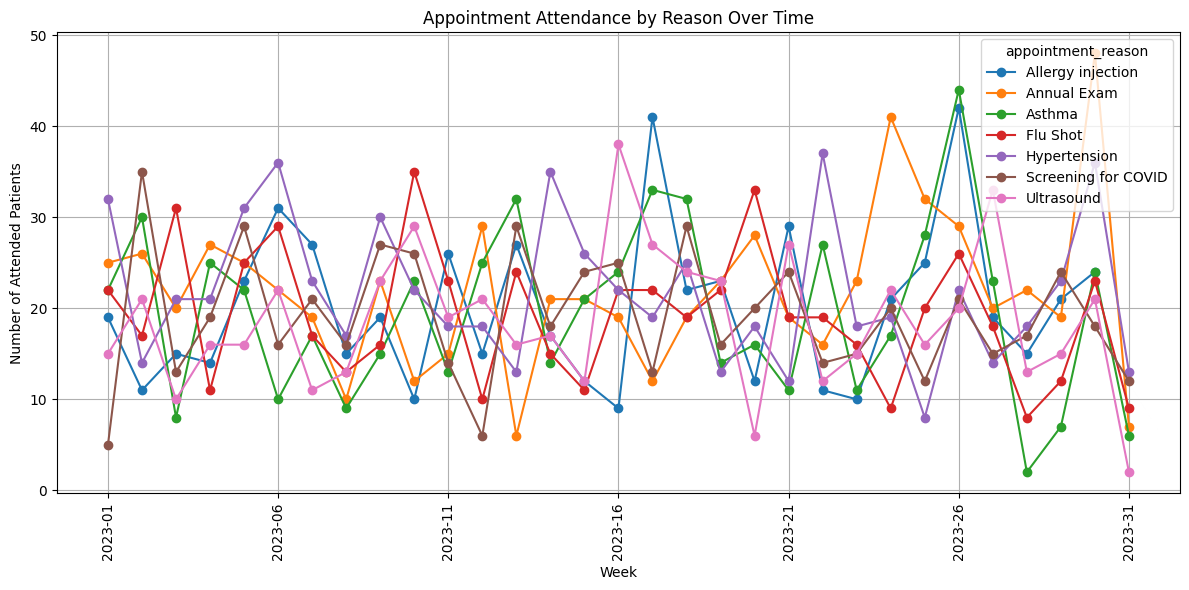

In [95]:

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Convert appointment_date to datetime format
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Create 'year_week' column by extracting the year and week number from the appointment date
merged_data['year_week'] = merged_data['appointment_date'].dt.strftime('%Y-%U')

# Group by year_week, appointment reason, and appointment status
attendance_by_reason = merged_data.groupby(['year_week', 'appointment_reason', 'appointment_status'])['patient_id'].count().unstack()

# Plot attendance over time for different reasons
attendance_by_reason['Attended'].unstack().plot(figsize=(12, 6), marker='o')
plt.title('Appointment Attendance by Reason Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Attended Patients')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


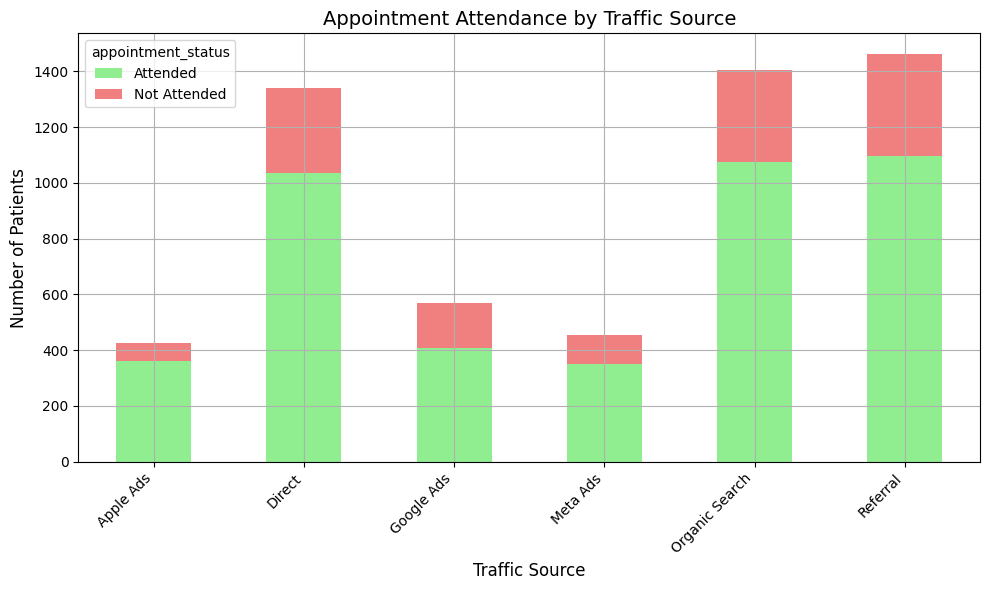

In [96]:

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Check if 'traffic_source' column exists
if 'traffic_source' in merged_data.columns:
    # Group by traffic_source and appointment status
    traffic_source_analysis = merged_data.groupby(['traffic_source', 'appointment_status'])['patient_id'].count().unstack().fillna(0)

    # Plot the attendance rates by traffic source
    traffic_source_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgreen', 'lightcoral'])
    plt.title('Appointment Attendance by Traffic Source', fontsize=14)
    plt.xlabel('Traffic Source', fontsize=12)
    plt.ylabel('Number of Patients', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

else:
    print("The 'traffic_source' column is missing in the dataset.")


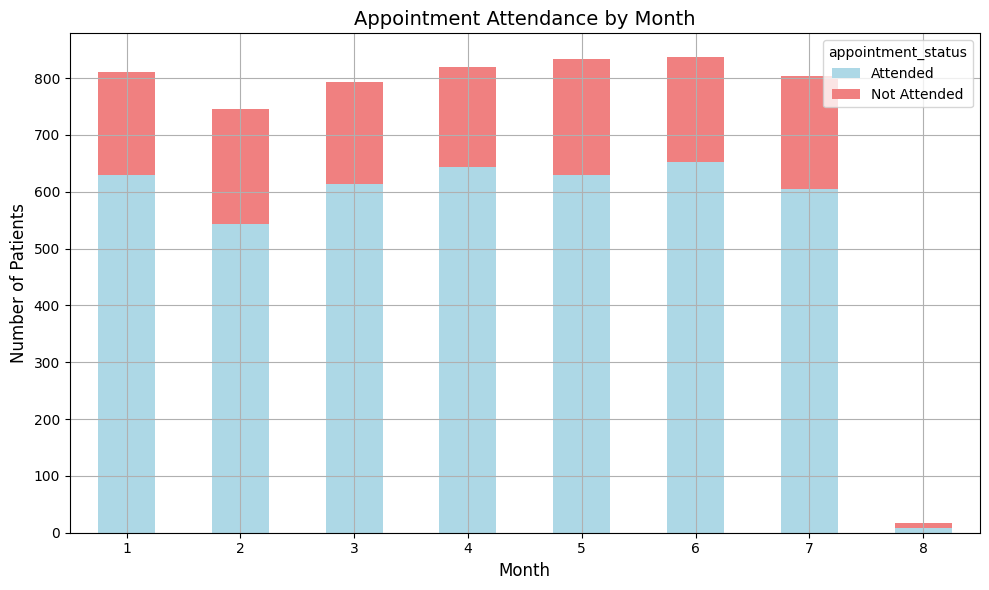

In [97]:

ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Convert appointment_date to datetime format
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'], errors='coerce')

# Extract month from appointment_date
merged_data['month'] = merged_data['appointment_date'].dt.month

# Group by month and appointment status
attendance_by_month = merged_data.groupby(['month', 'appointment_status'])['patient_id'].count().unstack().fillna(0)

# Plot the attendance rates by month
attendance_by_month.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title('Appointment Attendance by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


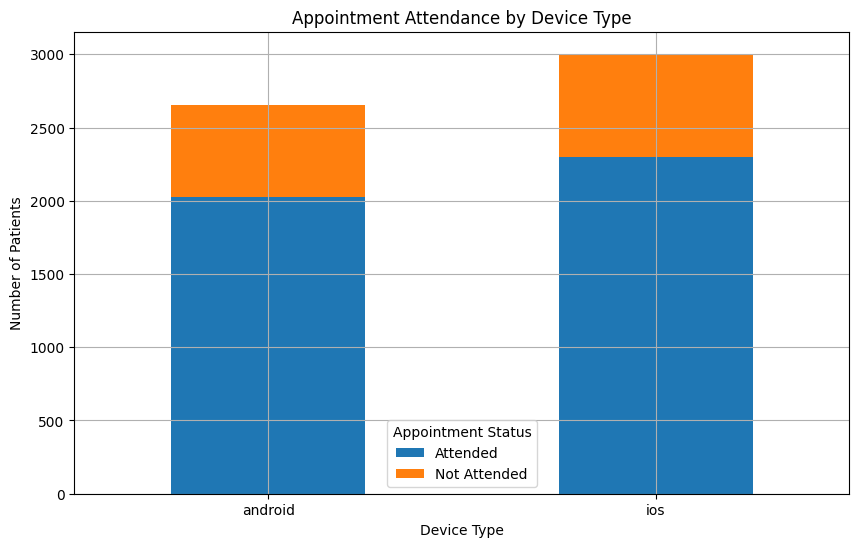

In [98]:

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert devices to lowercase and group into Android/iOS/Other
app_data['device'] = app_data['device'].str.lower()
app_data['device_group'] = app_data['device'].apply(lambda x: 'android' if 'android' in x else 'ios' if 'ios' in x else 'other')

# Merge datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_app_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group by device type and appointment status
device_drop_off = merged_app_data.groupby(['device_group', 'appointment_status'])['patient_id'].count().unstack()

# Plotting the result
device_drop_off.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Appointment Status')
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_3773/3691504966.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funnel_counts = {stage: df[df['event_name'] == stage].groupby('age_group')['patient_id'].nunique() for stage in funnel_stages}


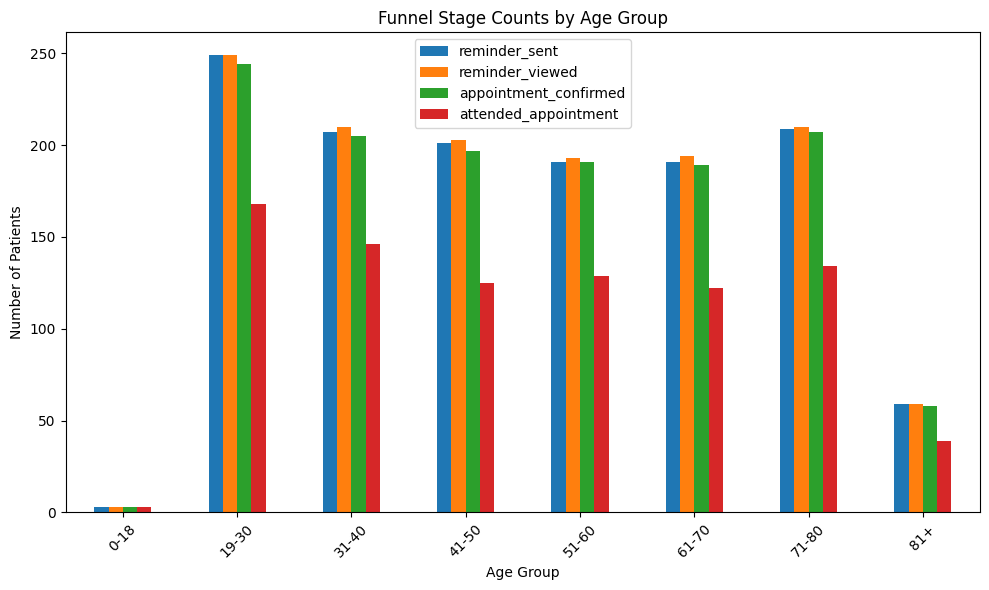

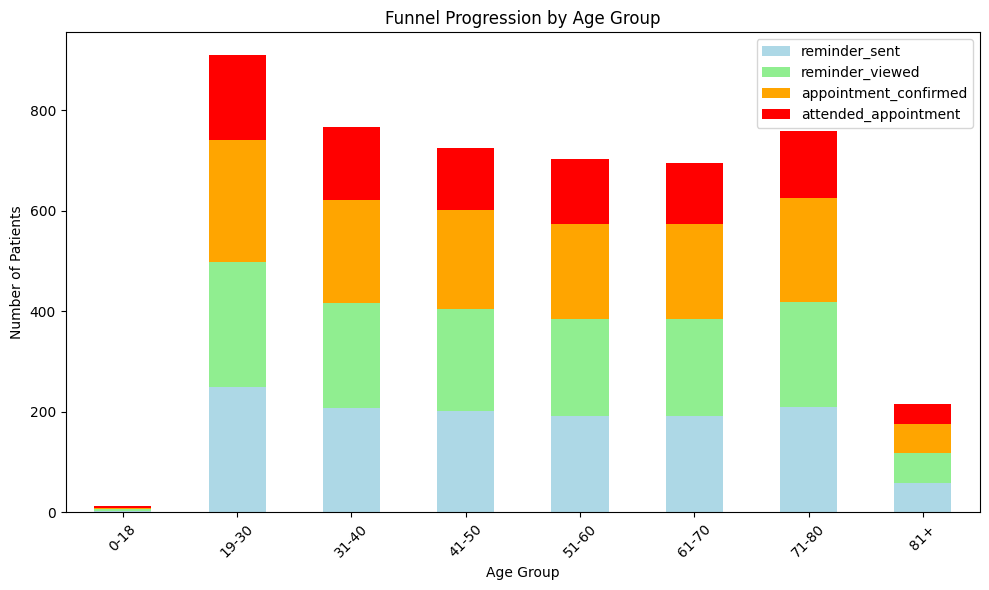

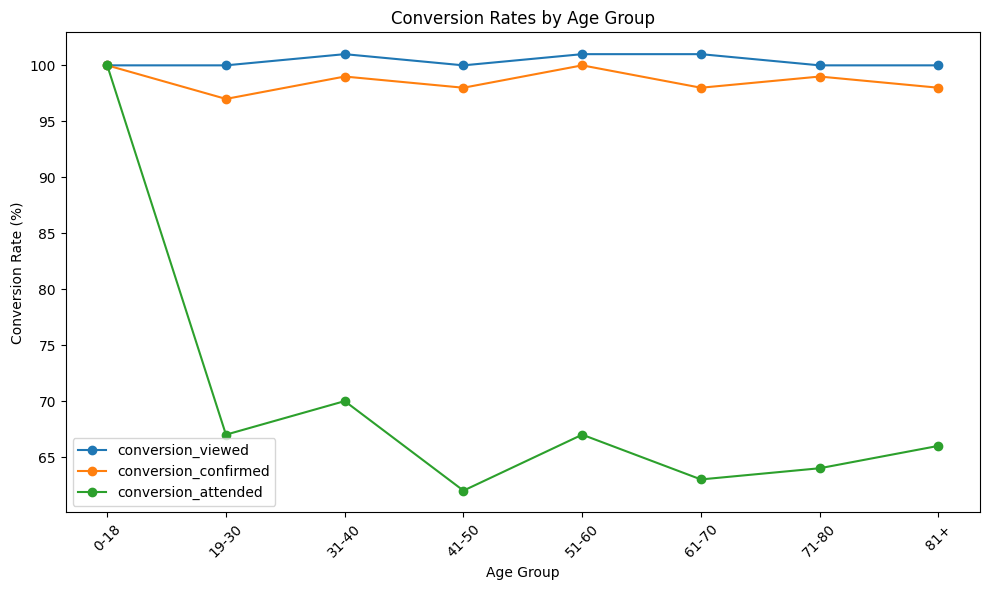

In [99]:


# Load your datasets (replace the file paths as needed)
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the datasets to get the complete data for analysis
ab_appointments_merged = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Create a copy of the merged dataframe for further analysis
df = ab_appointments_merged.copy()

# Now continue with the analysis steps

# Merge datasets
df = ab_appointments_merged.copy()
df = df[df['group'] == 'Test']
# Define age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Step 1: Analyze funnel stages by age group
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Create a dictionary to store funnel counts for each stage
funnel_counts = {stage: df[df['event_name'] == stage].groupby('age_group')['patient_id'].nunique() for stage in funnel_stages}

# Convert the funnel_counts dictionary to a DataFrame 
funnel_df = pd.DataFrame(funnel_counts).fillna(0)  
# Fill missing values with 0

# Step 2: Calculate conversion rates for each age group
funnel_df['conversion_viewed'] = (funnel_df['reminder_viewed'] / funnel_df['reminder_sent']) * 100
funnel_df['conversion_confirmed'] = (funnel_df['appointment_confirmed'] / funnel_df['reminder_sent']) * 100
funnel_df['conversion_attended'] = (funnel_df['attended_appointment'] / funnel_df['reminder_sent']) * 100

# Step 3: Display the funnel data for each age group
funnel_df = funnel_df[['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment', 'conversion_viewed', 'conversion_confirmed', 'conversion_attended']]
funnel_df = funnel_df.astype(int, errors='ignore')  # Convert counts to integer for cleaner display

# Bar chart for Funnel Stage Counts
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_df[funnel_stages].plot(kind='bar', figsize=(10, 6))
plt.title('Funnel Stage Counts by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Stacked bar chart for Funnel Progression
funnel_df[funnel_stages].plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightgreen', 'orange', 'red'])
plt.title('Funnel Progression by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line chart for Conversion Rates
conversion_columns = ['conversion_viewed', 'conversion_confirmed', 'conversion_attended']
funnel_df[conversion_columns].plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Conversion Rates by Age Group')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

